In [1]:
from config import settings
from hannover_pylon.data import datamodules as dm
from pathlib import Path
from hannover_pylon.modelling.backbone.utils import FromBuffer , CutPSD, NormLayer
import matplotlib.pyplot as plt
from torch import nn 
%load_ext autoreload
%autoreload 2

/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


In [2]:
db_path = Path(settings.path.processed,'Welch(n_fft=16392, fs=1651, max_freq=825.5).db')


In [3]:
import numpy as np
from pathlib import Path
from torch import nn
freq_axis = np.linspace(0, 825.5, 8197)
columns= ['psd','level','direction']
transform_func = [nn.Sequential(FromBuffer(),CutPSD(freq_axis=freq_axis,freq_range=(0,150)),NormLayer(min_val=-5.46,max_val=4.96))] + [nn.Identity()]*2
query_key = f'''
    SELECT id FROM data
    WHERE date BETWEEN "{settings.state.healthy_train.start}" AND "{settings.state.healthy_train.end}"
    AND corrupted = 0
    AND sensor = "accel"
'''
data_loader = dm.PSDDataModule(db_path= db_path,table_name='data', columns=columns,transform_func=transform_func, query_key=query_key, batch_size=512, return_dict=True, cached=True,num_workers=16)


In [4]:
import sqlite3 
import pandas as pd
import torch
con = sqlite3.connect(db_path) 
query = f'''
    SELECT * FROM data
    WHERE date BETWEEN "{settings.state.damage5.start}" AND "{settings.state.damage5.end}"
    AND corrupted = 0
    AND sensor = "accel"
    AND level = 1
'''
df = pd.read_sql_query(query, con)

df['psd'] = df['psd'].apply(lambda x: transform_func[0](x))
anoumalous_psd = torch.from_numpy(np.stack(df['psd'].values))

In [5]:
import sqlite3 
import pandas as pd
import torch
con = sqlite3.connect(db_path) 
query = f'''
    SELECT * FROM data
    WHERE date BETWEEN "{settings.state.healthy_test.start}" AND "{settings.state.healthy_test.end}"
    AND corrupted = 0
    AND sensor = "accel"
    AND level = 1
'''
df = pd.read_sql_query(query, con)

df['psd'] = df['psd'].apply(lambda x: transform_func[0](x))
healthy_psd = torch.from_numpy(np.stack(df['psd'].values))

In [6]:
import torch
import torch.nn as nn
from hannover_pylon.modelling.backbone import utils as ut

class OneToOneAutoEncoder(nn.Module):
    def __init__(self, psd_length=1490, hidden_dims=[512, 128, 64], latent_dim=32,
                 activation_str:str ="relu",
                 final_activation:str ="sigmoid"):
        """
        A one-to-one autoencoder for a single sensor.
        
        Args:
            psd_length (int): Length of the PSD vector.
            hidden_dims (list): Hidden layer sizes for the encoder.
            latent_dim (int): Dimension of the latent space.
        """
        super().__init__()
        # Encoder: input (PSD vector) -> hidden layers -> latent vector
        self.encoder = ut.build_layers(
            hidden_dims=[psd_length] + hidden_dims,
            activation_list=[activation_str] * (len(hidden_dims)-1)+[None],
            batch_norm=False,
        )
        self.latent_layer = nn.Linear(hidden_dims[-1], latent_dim)
        
        # Decoder: latent vector -> hidden layers (reverse order) -> reconstruction of PSD vector
        decoder_dims = hidden_dims[::-1]
        self.decoder = ut.build_layers(
            hidden_dims=[latent_dim] + decoder_dims + [psd_length],
            activation_list=[activation_str] * (len(decoder_dims)) + [final_activation],
            batch_norm=False,
        )
        self.device_ = None
        
    def forward(self, x_dict):
        """
        Args:
            x_dict (dict): Dictionary containing the input data under key "psd".  
                           Expected shape of x_dict["psd"]: (B, psd_length)
        
        Returns:
            dict: Contains keys:
                - "reconstruction": the reconstructed PSD vector (B, psd_length)
                - "latent": the latent vector (B, latent_dim)
        """
        # Extract the PSD vector from the dict.
        x = x_dict["psd"]
        # to device 
        if self.device_ is None :
            self.device_ = next(self.parameters()).device
        x = x.to(self.device_)
        encoded = self.encoder(x)
        latent = self.latent_layer(encoded)
        reconstruction = self.decoder(latent)
        return {"reconstruction": reconstruction, "latent": latent}
    
import pytorch_lightning as pl

class OneToOneTrainingModule(pl.LightningModule):
    def __init__(self, psd_length=1490, hidden_dims=[512,128,64], latent_dim=32,
                 activation_str:str ="relu",
                 final_activation:str ="sigmoid", lr=1e-3):
        super().__init__()
        self.model = OneToOneAutoEncoder(psd_length=psd_length, hidden_dims=hidden_dims, latent_dim=latent_dim,
                                         activation_str=activation_str, final_activation=final_activation)
        self.loss_fn = nn.MSELoss()
        self.lr = lr
        self.save_hyperparameters(ignore="model")
        
    def forward(self, x):
        return self.model(x)
    def _common_step(self, batch, batch_idx):
        output = self(batch)
        reconstruction = output["reconstruction"]
        loss = self.loss_fn(reconstruction, batch["psd"])
        return loss
    
    def training_step(self, batch, batch_idx):
        loss = self._common_step(batch, batch_idx)
        self.log("train_loss", loss, prog_bar=True)
        return loss
    def validation_step(self, batch, batch_idx):
        loss = self._common_step(batch, batch_idx)
        self.log("val_loss", loss, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


In [7]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torch


def run_train(max_epochs=150,hidden_dims=[512,256,128], latent_dim=4, activation_str="relu", final_activation="sigmoid", lr=1e-3):  
    model = OneToOneTrainingModule(
        psd_length=1490,
        hidden_dims=hidden_dims,
        latent_dim=latent_dim,
        activation_str=activation_str,
        final_activation=final_activation,
        lr=lr
    )

    # Define a model checkpoint callback to save the best models.
    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',              # Monitor the validation loss.
        dirpath='checkpoints',           # Directory to save checkpoints.
        filename='autoencoder-{epoch:02d}-{val_loss:.4f}', 
        save_top_k=3,                    # Save the 3 best models.
        mode='min'
    )

    # Define an early stopping callback (optional).
    early_stop_callback = EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=True,
        mode='min'
    )

    # Create the Trainer instance.
    trainer = Trainer(
        max_epochs=max_epochs,
        callbacks=[checkpoint_callback, early_stop_callback],
        accelerator='gpu'
    )

    # Start training.
    trainer.fit(model,data_loader)
    best_model_path = checkpoint_callback.best_model_path
    best_model = OneToOneTrainingModule.load_from_checkpoint(best_model_path)
    best_score = checkpoint_callback.best_model_score
    best_model.eval()
    # get logger
    return best_model, best_score, best_model_path
    


In [8]:
best_model , best_score,_ = run_train(1,hidden_dims=[512,256,128],
                                    latent_dim=4, 
                                    activation_str="relu",
                                    final_activation="sigmoid",
                                    lr=1e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_

/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 512. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 103.42it/s, v_num=367, train_loss=0.00116, val_loss=0.00114]

/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 301. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
Metric val_loss improved. New best score: 0.001
`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 100.13it/s, v_num=367, train_loss=0.00116, val_loss=0.00114]


In [47]:
best_model_path = "file:///home/owilab/Documents/YacineB/Code/hannover-pylon/mlruns/0/afb6566539f641e6b1bf89a9c60e1583/artifacts/autoencoder-epoch=142-val_loss=0.0001-v6.ckpt"
best_model = OneToOneTrainingModule.load_from_checkpoint(best_model_path)


In [48]:
import torch
import torch.nn as nn

class Detector(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.model.eval()  # Set the model to evaluation mode
        self.device = next(model.parameters()).device

    def mse(self, x_dict):
        # Ensure the input tensor is on the same device as the model.
        x = x_dict["psd"].to(self.device)
        with torch.no_grad():
            # The autoencoder returns a dict; we extract the reconstruction.
            out = self.model({"psd": x})
        x_hat = out["reconstruction"]
        
        # Compute the element-wise squared error.
        error = (x - x_hat) ** 2
        
        # Compute the 90th quantile along the feature dimension (dim=1).
        quantile_error = torch.quantile(error, q=0.9, dim=1)
        return quantile_error

    def forward(self, x_dict):
        return self.mse(x_dict)

In [49]:
detector = Detector(best_model)

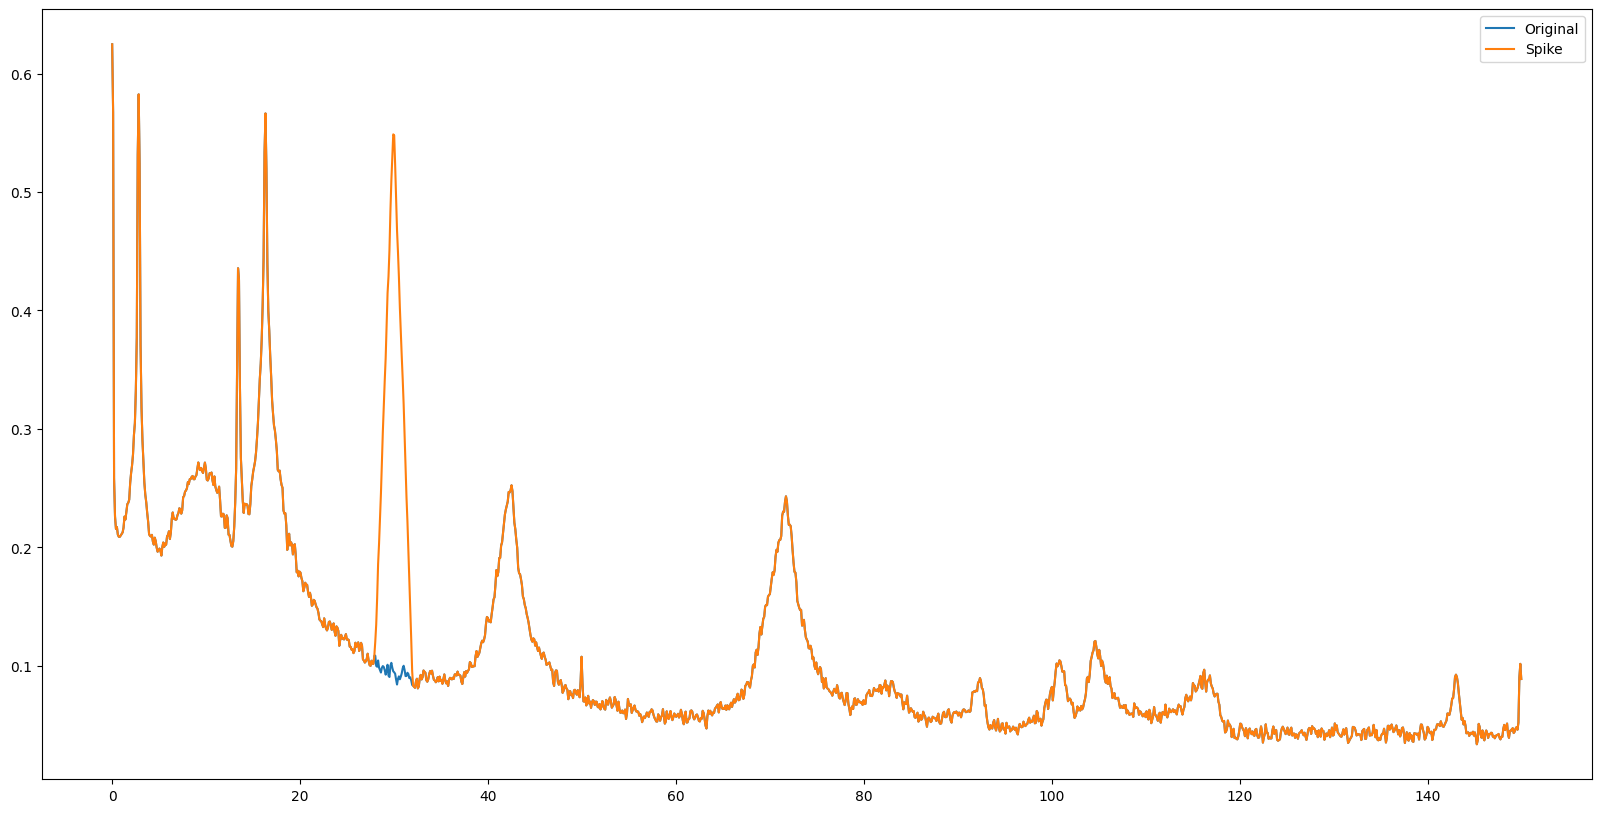

In [50]:
import virtual_anomaly as va
window_center= 30
amplitude = 0.5
psd_aff = va.AddSpike(freq_axis[0:1490],window_center,2,amplitude)(healthy_psd).T
fig,ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(freq_axis[0:1490],healthy_psd[0],label='Original')
ax.plot(freq_axis[0:1490],psd_aff[0],label='Spike')
ax.legend()

        



In [51]:
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
amplitudes = np.arange(-0.5,0.5,0.1)
# arround the amplitude to  2 decimal
amplitudes = np.round(amplitudes,2)
window_centers = np.arange(0,150,2)
df_va_list = []
healthy_score = detector({'psd':healthy_psd}).cpu().numpy()
real_anomaly_score = detector({'psd':anoumalous_psd}).cpu().numpy()
labels = np.array([1] * len(healthy_score) + [0] * len(real_anomaly_score))
scores = np.concatenate([real_anomaly_score, healthy_score])
aucs_real_anomaly = roc_auc_score(labels, scores)

for amplitude in tqdm(amplitudes):
    for window_center in window_centers:
        psd_aff = va.AddSpike(freq_axis[0:1490],window_center,2,amplitude)(healthy_psd).T
        affected_score = detector({'psd':psd_aff}).cpu().numpy()
        labels = np.array([1] * len(healthy_score) + [0] * len(affected_score))
        scores = np.concatenate([affected_score, healthy_score])
        aucs_res = roc_auc_score(labels, scores)
        df_va_list.append({'amplitude':amplitude,'window_center':window_center,'auc':aucs_res})
        df_va = pd.DataFrame(df_va_list)
        # minmum value of auc is 0.1
        df_va['auc'] = df_va['auc'].apply(lambda x: max(0.1,x))
        harmonic_mean = len(df_va['auc'])/np.sum(1/df_va['auc'])
        

100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


In [52]:
aucs_real_anomaly

np.float64(0.6761275610488527)

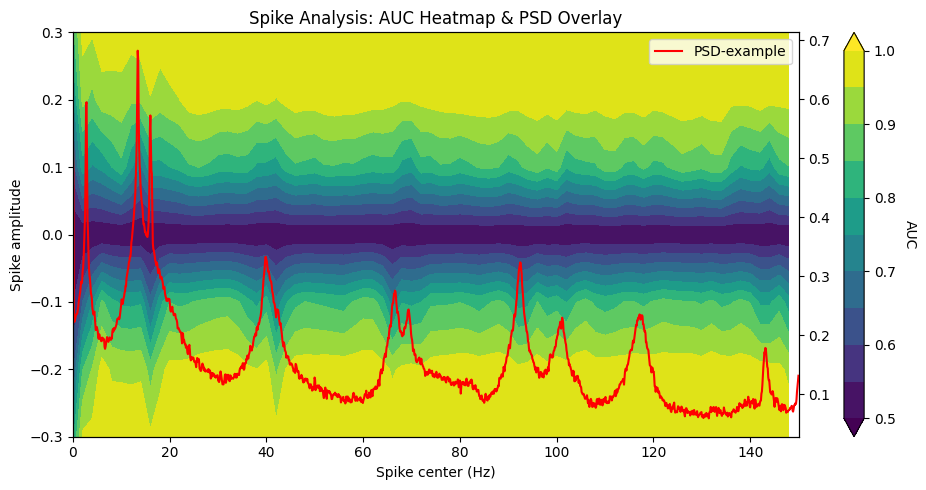

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example data pivot
df_va = pd.DataFrame(df_va)
heat = df_va.pivot_table(index='amplitude', columns='window_center', values='auc')

# Create coordinate grids
x, y = np.meshgrid(window_centers, amplitudes)
z = heat.values

fig, ax = plt.subplots(figsize=(10, 5))

# Define contour levels that don't fully cover your data range
# so the triangles can appear at both ends
# For example, if your z data is roughly in [0.3, 0.9], 
# you might pick [0.2, 1.0] or so for the min and max.
levels = np.linspace(0.5, 1, 11)

# Use 'extend="both"' to enable triangular extensions at both ends
contour = ax.contourf(
    x, y, z, 
    levels=levels, 
    cmap='viridis', 
    extend='both'
)

# Create colorbar with the same "extend" behavior
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label("AUC", rotation=270, labelpad=15)

ax.set_xlabel("Spike center (Hz)")
ax.set_ylabel("Spike amplitude")

# Plot PSD on a secondary y-axis
ax1 = ax.twinx()
ax1.plot(freq_axis[:1490], healthy_psd[5], label="PSD-example", color="red")
ax1.set_xlim(0, 150)
ax.set_ylim(-0.3, 0.3)
ax1.legend(loc="upper right")

plt.title("Spike Analysis: AUC Heatmap & PSD Overlay")
plt.tight_layout()
plt.show()


In [15]:
import numpy as np

# Ensure there are no zero values in 'auc' to avoid division by zero errors
if (df_va['auc'] == 0).any():
    raise ValueError("Zero value found in 'auc'; harmonic mean is undefined.")

# Compute the harmonic mean manually
harmonic_mean_manual = len(df_va['auc']) / np.sum(1 / df_va['auc'])
print("Harmonic Mean (Manual):", harmonic_mean_manual)


Harmonic Mean (Manual): 0.5971790045979033


In [16]:
# -- tuning -- 

In [17]:
def evaluate_on_real_anomalies(detector):
    # Evaluate on your real anomaly dataset:
    real_scores = detector({'psd': anoumalous_psd}).cpu().numpy()
    healthy_scores = detector({'psd': healthy_psd}).cpu().numpy()
    
    # Here, label 1 indicates healthy and 0 indicates anomaly.
    labels = np.array([1] * len(healthy_scores) + [0] * len(real_scores))
    scores = np.concatenate([real_scores, healthy_scores])
    aucs_real_anomaly = roc_auc_score(labels, scores)
    return aucs_real_anomaly

In [18]:
def evaluate_on_virtual_anomalies(detector):
    # Define a grid for virtual anomalies.
    amplitudes = np.round(np.arange(-0.5, 0.5, 0.1), 2)
    window_centers = np.arange(0, 150, 2)
    aucs_va_list = []
    healthy_scores = detector({'psd': healthy_psd}).cpu().numpy()
    for amplitude in amplitudes:
        for window_center in window_centers:
            psd_aff = va.AddSpike(freq_axis[0:1490], window_center, 2, amplitude)(healthy_psd).T
            affected_scores = detector({'psd': psd_aff}).cpu().numpy()
            labels = np.array([1] * len(healthy_psd) + [0] * len(affected_scores))
            scores = np.concatenate([affected_scores, healthy_scores])
            auc_va = roc_auc_score(labels, scores)
            auc_va = max(auc_va, 0.1)  # avoid division by zero
            aucs_va_list.append(auc_va)
    
    harmonic_mean_va = len(aucs_va_list) / np.sum([1 / auc for auc in aucs_va_list])
    return harmonic_mean_va

In [19]:
import optuna
import mlflow

def objective(trial: optuna.Trial) -> float:
    """
    Optuna objective function that explores variable-depth autoencoder architectures
    and logs results to MLflow.
    """
    # Let Optuna choose the number of hidden layers
    
    # Construct the hidden_dims list based on the chosen number of layers
    hidden_dims = [512,512,256]
    
    # Other hyperparameters
    latent_dim = trial.suggest_int("latent_dim", 4, 500, step=1)
    lr = 1e-3
    activation_str = trial.suggest_categorical("activation_str", ["relu", "leakyrelu", "tanh"])
    final_activation = trial.suggest_categorical("final_activation", ["sigmoid", "tanh",None])
    

    # Collect hyperparameters into a dictionary
    hparams = {
        "hidden_dims": hidden_dims,
        "latent_dim": latent_dim,
        "lr": lr,
        "activation_str": activation_str,
        "final_activation": final_activation,
    }

    # Start an MLflow run for logging (nested=True if part of a larger run)
    with mlflow.start_run():
        mlflow.log_params(hparams)

        # Train the model with the chosen hyperparameters
        best_model_module, best_model_score, best_model_path = run_train(
            hidden_dims=hidden_dims,
            latent_dim=latent_dim,
            lr=lr,
            activation_str=activation_str,
            final_activation=final_activation,
        )

        # Wrap the trained model in the Detector for evaluation
        detector = Detector(best_model_module.model)

        # Evaluate on real anomalies and virtual anomalies
        aucs_real = evaluate_on_real_anomalies(detector)
        harmonic_mean_va = evaluate_on_virtual_anomalies(detector)

        # Log relevant metrics
        mlflow.log_metric("aucs_real_anomaly", aucs_real)
        mlflow.log_metric("harmonic_mean_va", harmonic_mean_va)
        mlflow.log_metric("best_score", best_model_score)
        
        # Optionally log the best checkpoint path as an artifact
        mlflow.log_artifact(best_model_path)

        # Store the real anomaly metric for later reference
        trial.set_user_attr("aucs_real_anomaly", aucs_real)

        # Return the harmonic mean of VA AUCs as the metric to maximize
        return harmonic_mean_va


# Create and run the Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=60)

# Display the best trial's results
print("Best trial:")
best_trial = study.best_trial
print(f"  Harmonic Mean (VA): {best_trial.value}")
print("  Hyperparameters:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")
print("  Real Anomaly AUC:", best_trial.user_attrs.get("aucs_real_anomaly"))


/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-02-24 16:06:26,116] A new study created in memory with name: no-name-523a6ffe-03b3-4672-9b19-480c8af8833d
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.4 M  | train
1 | loss_fn | MSELoss        

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 106.72it/s, v_num=368, train_loss=0.00101, val_loss=0.00115]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 81.60it/s, v_num=368, train_loss=0.000633, val_loss=0.000701]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 81.03it/s, v_num=368, train_loss=0.000538, val_loss=0.000484] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:02<00:00, 84.29it/s, v_num=368, train_loss=0.000348, val_loss=0.000315] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 81.57it/s, v_num=368, train_loss=0.000191, val_loss=0.000242] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:02<00:00, 83.28it/s, v_num=368, train_loss=0.000194, val_loss=0.000195] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 80.87it/s, v_num=368, train_loss=0.000166, val_loss=0.000167] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 81.75it/s, v_num=368, train_loss=0.000159, val_loss=0.000146] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:02<00:00, 83.70it/s, v_num=368, train_loss=0.000135, val_loss=0.000131] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:02<00:00, 83.10it/s, v_num=368, train_loss=0.00014, val_loss=0.00013]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 79.29it/s, v_num=368, train_loss=0.000134, val_loss=0.00012]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:03<00:00, 81.30it/s, v_num=368, train_loss=0.000106, val_loss=0.000115]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:03<00:00, 80.12it/s, v_num=368, train_loss=0.000115, val_loss=0.000111] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 247/247 [00:02<00:00, 84.26it/s, v_num=368, train_loss=0.000103, val_loss=0.000106] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 247/247 [00:03<00:00, 81.85it/s, v_num=368, train_loss=9.55e-5, val_loss=9.83e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 247/247 [00:03<00:00, 81.62it/s, v_num=368, train_loss=8.02e-5, val_loss=9.36e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 42: 100%|██████████| 247/247 [00:03<00:00, 75.46it/s, v_num=368, train_loss=0.000112, val_loss=0.000117] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 42: 100%|██████████| 247/247 [00:03<00:00, 75.42it/s, v_num=368, train_loss=0.000112, val_loss=0.000117]


[I 2025-02-24 16:08:46,612] Trial 0 finished with value: 0.8230948023328021 and parameters: {'latent_dim': 206, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 0 with value: 0.8230948023328021.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.3 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.329     Total estimated mode

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 102.58it/s, v_num=369, train_loss=0.0104, val_loss=0.0107]

Metric val_loss improved. New best score: 0.011


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 78.62it/s, v_num=369, train_loss=0.00139, val_loss=0.00144]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 78.77it/s, v_num=369, train_loss=0.00139, val_loss=0.00141] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 75.82it/s, v_num=369, train_loss=0.00152, val_loss=0.00141] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 76.70it/s, v_num=369, train_loss=0.00152, val_loss=0.0014]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 78.05it/s, v_num=369, train_loss=0.000962, val_loss=0.000971]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 77.21it/s, v_num=369, train_loss=0.000706, val_loss=0.000707] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 78.76it/s, v_num=369, train_loss=0.00068, val_loss=0.000674]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 78.00it/s, v_num=369, train_loss=0.000654, val_loss=0.000639] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 81.27it/s, v_num=369, train_loss=0.000626, val_loss=0.000604] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 78.53it/s, v_num=369, train_loss=0.000529, val_loss=0.000487] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 80.01it/s, v_num=369, train_loss=0.000365, val_loss=0.000413] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 79.72it/s, v_num=369, train_loss=0.000359, val_loss=0.000357] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 80.22it/s, v_num=369, train_loss=0.000352, val_loss=0.000322] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 78.81it/s, v_num=369, train_loss=0.00033, val_loss=0.000307]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 80.06it/s, v_num=369, train_loss=0.000289, val_loss=0.000272] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 80.84it/s, v_num=369, train_loss=0.000223, val_loss=0.000242] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:03<00:00, 79.16it/s, v_num=369, train_loss=0.00024, val_loss=0.00023]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 79.44it/s, v_num=369, train_loss=0.000207, val_loss=0.000214]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 247/247 [00:03<00:00, 78.37it/s, v_num=369, train_loss=0.000204, val_loss=0.000208] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:03<00:00, 79.25it/s, v_num=369, train_loss=0.000192, val_loss=0.000197] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 247/247 [00:03<00:00, 77.47it/s, v_num=369, train_loss=0.000208, val_loss=0.000189] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 247/247 [00:03<00:00, 80.24it/s, v_num=369, train_loss=0.000166, val_loss=0.000174] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 247/247 [00:03<00:00, 76.37it/s, v_num=369, train_loss=0.000168, val_loss=0.000167] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 247/247 [00:03<00:00, 78.17it/s, v_num=369, train_loss=0.000154, val_loss=0.000161] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 31: 100%|██████████| 247/247 [00:03<00:00, 80.13it/s, v_num=369, train_loss=0.000146, val_loss=0.000156] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 247/247 [00:03<00:00, 78.18it/s, v_num=369, train_loss=0.000144, val_loss=0.000144] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 34: 100%|██████████| 247/247 [00:03<00:00, 78.69it/s, v_num=369, train_loss=0.000141, val_loss=0.000138] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 36: 100%|██████████| 247/247 [00:03<00:00, 77.92it/s, v_num=369, train_loss=0.000138, val_loss=0.000136] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 38: 100%|██████████| 247/247 [00:03<00:00, 77.92it/s, v_num=369, train_loss=0.000133, val_loss=0.000133] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 40: 100%|██████████| 247/247 [00:03<00:00, 80.39it/s, v_num=369, train_loss=0.000144, val_loss=0.000128] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 42: 100%|██████████| 247/247 [00:03<00:00, 77.18it/s, v_num=369, train_loss=0.000132, val_loss=0.000124] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 44: 100%|██████████| 247/247 [00:03<00:00, 79.61it/s, v_num=369, train_loss=0.000118, val_loss=0.000118] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 50: 100%|██████████| 247/247 [00:03<00:00, 77.58it/s, v_num=369, train_loss=0.000107, val_loss=0.000114] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 52: 100%|██████████| 247/247 [00:03<00:00, 80.37it/s, v_num=369, train_loss=0.000102, val_loss=0.000108] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 55: 100%|██████████| 247/247 [00:03<00:00, 81.00it/s, v_num=369, train_loss=0.0001, val_loss=0.000108]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 60: 100%|██████████| 247/247 [00:03<00:00, 80.98it/s, v_num=369, train_loss=0.000107, val_loss=0.000103] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 61: 100%|██████████| 247/247 [00:03<00:00, 80.42it/s, v_num=369, train_loss=8.51e-5, val_loss=9.47e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 66: 100%|██████████| 247/247 [00:03<00:00, 81.94it/s, v_num=369, train_loss=8.28e-5, val_loss=9.35e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 74: 100%|██████████| 247/247 [00:03<00:00, 80.88it/s, v_num=369, train_loss=7.86e-5, val_loss=8.71e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 80: 100%|██████████| 247/247 [00:03<00:00, 78.89it/s, v_num=369, train_loss=7.97e-5, val_loss=8.46e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 82: 100%|██████████| 247/247 [00:03<00:00, 75.60it/s, v_num=369, train_loss=8.11e-5, val_loss=8.38e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 85: 100%|██████████| 247/247 [00:03<00:00, 78.54it/s, v_num=369, train_loss=7.7e-5, val_loss=8.3e-5]     

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 95: 100%|██████████| 247/247 [00:03<00:00, 80.07it/s, v_num=369, train_loss=0.0102, val_loss=0.0112]     

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 95: 100%|██████████| 247/247 [00:03<00:00, 80.03it/s, v_num=369, train_loss=0.0102, val_loss=0.0112]


[I 2025-02-24 16:13:56,444] Trial 1 finished with value: 0.8087684088926383 and parameters: {'latent_dim': 31, 'activation_str': 'tanh', 'final_activation': 'sigmoid'}. Best is trial 0 with value: 0.8230948023328021.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.3 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.372     Total estimated mo

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 109.77it/s, v_num=370, train_loss=0.000894, val_loss=0.00093]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 79.85it/s, v_num=370, train_loss=0.000599, val_loss=0.000573]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 80.26it/s, v_num=370, train_loss=0.000616, val_loss=0.000472] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 79.55it/s, v_num=370, train_loss=0.000231, val_loss=0.000256] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 80.70it/s, v_num=370, train_loss=0.00018, val_loss=0.000197]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 81.11it/s, v_num=370, train_loss=0.000147, val_loss=0.000165] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 79.77it/s, v_num=370, train_loss=0.000133, val_loss=0.000148] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 80.13it/s, v_num=370, train_loss=0.000146, val_loss=0.000143] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 76.71it/s, v_num=370, train_loss=0.000139, val_loss=0.00014]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 80.66it/s, v_num=370, train_loss=0.000105, val_loss=0.000115] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 80.98it/s, v_num=370, train_loss=0.000102, val_loss=0.000112] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 80.25it/s, v_num=370, train_loss=0.000101, val_loss=0.00011]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 80.15it/s, v_num=370, train_loss=0.000101, val_loss=9.95e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 247/247 [00:03<00:00, 81.21it/s, v_num=370, train_loss=0.000164, val_loss=0.00016]  

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 28: 100%|██████████| 247/247 [00:03<00:00, 81.18it/s, v_num=370, train_loss=0.000164, val_loss=0.00016]


[I 2025-02-24 16:15:34,026] Trial 2 finished with value: 0.8078967640573291 and parameters: {'latent_dim': 52, 'activation_str': 'leakyrelu', 'final_activation': None}. Best is trial 0 with value: 0.8230948023328021.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.4 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.718     Total estimated mo

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 108.34it/s, v_num=371, train_loss=0.000988, val_loss=0.00102]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 79.15it/s, v_num=371, train_loss=0.00058, val_loss=0.000624] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 78.40it/s, v_num=371, train_loss=0.000337, val_loss=0.000343] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 79.65it/s, v_num=371, train_loss=0.00023, val_loss=0.000253]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 80.37it/s, v_num=371, train_loss=0.000238, val_loss=0.000239] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 77.41it/s, v_num=371, train_loss=0.000202, val_loss=0.000218] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 79.44it/s, v_num=371, train_loss=0.000202, val_loss=0.000214] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 81.38it/s, v_num=371, train_loss=0.000224, val_loss=0.000213] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 78.20it/s, v_num=371, train_loss=0.000194, val_loss=0.000198] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 79.57it/s, v_num=371, train_loss=0.000181, val_loss=0.000183] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 80.10it/s, v_num=371, train_loss=0.000149, val_loss=0.000165] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 78.77it/s, v_num=371, train_loss=0.000163, val_loss=0.000164] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 79.36it/s, v_num=371, train_loss=0.000141, val_loss=0.000154] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:03<00:00, 79.90it/s, v_num=371, train_loss=0.000144, val_loss=0.000146] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 78.73it/s, v_num=371, train_loss=0.000141, val_loss=0.000144] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:03<00:00, 75.75it/s, v_num=371, train_loss=0.000118, val_loss=0.000136] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 247/247 [00:03<00:00, 80.12it/s, v_num=371, train_loss=0.000128, val_loss=0.000133] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 247/247 [00:03<00:00, 80.87it/s, v_num=371, train_loss=0.000126, val_loss=0.000127] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 247/247 [00:03<00:00, 79.92it/s, v_num=371, train_loss=0.000136, val_loss=0.000122] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 247/247 [00:03<00:00, 80.89it/s, v_num=371, train_loss=0.000111, val_loss=0.00012]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 31: 100%|██████████| 247/247 [00:03<00:00, 80.17it/s, v_num=371, train_loss=0.000114, val_loss=0.000112]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 247/247 [00:03<00:00, 80.39it/s, v_num=371, train_loss=0.000103, val_loss=0.000108] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 34: 100%|██████████| 247/247 [00:03<00:00, 75.98it/s, v_num=371, train_loss=9.21e-5, val_loss=0.000107]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 37: 100%|██████████| 247/247 [00:03<00:00, 79.81it/s, v_num=371, train_loss=9.74e-5, val_loss=9.85e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 38: 100%|██████████| 247/247 [00:03<00:00, 74.39it/s, v_num=371, train_loss=9.9e-5, val_loss=9.64e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 40: 100%|██████████| 247/247 [00:03<00:00, 73.55it/s, v_num=371, train_loss=9.75e-5, val_loss=9.36e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 50: 100%|██████████| 247/247 [00:03<00:00, 75.64it/s, v_num=371, train_loss=0.00011, val_loss=0.00011]   

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 50: 100%|██████████| 247/247 [00:03<00:00, 75.61it/s, v_num=371, train_loss=0.00011, val_loss=0.00011]


[I 2025-02-24 16:18:26,190] Trial 3 finished with value: 0.8175876765222311 and parameters: {'latent_dim': 221, 'activation_str': 'leakyrelu', 'final_activation': None}. Best is trial 0 with value: 0.8230948023328021.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.5 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.975     Total estimated m

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 105.99it/s, v_num=372, train_loss=0.000663, val_loss=0.000641]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 77.76it/s, v_num=372, train_loss=0.000409, val_loss=0.000408] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 79.76it/s, v_num=372, train_loss=0.0116, val_loss=0.0109]   

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 79.73it/s, v_num=372, train_loss=0.0116, val_loss=0.0109]


[I 2025-02-24 16:19:12,060] Trial 4 finished with value: 0.6432629716769066 and parameters: {'latent_dim': 346, 'activation_str': 'tanh', 'final_activation': 'tanh'}. Best is trial 0 with value: 0.8230948023328021.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.4 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.526     Total estimated mode

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 104.89it/s, v_num=373, train_loss=0.000875, val_loss=0.000969]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 77.43it/s, v_num=373, train_loss=0.00039, val_loss=0.00041]   

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.000


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 76.73it/s, v_num=373, train_loss=0.00032, val_loss=0.000327] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 77.96it/s, v_num=373, train_loss=0.000249, val_loss=0.00026]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 76.25it/s, v_num=373, train_loss=0.0107, val_loss=0.011]    

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 76.21it/s, v_num=373, train_loss=0.0107, val_loss=0.011]


[I 2025-02-24 16:20:04,633] Trial 5 finished with value: 0.7171569912149283 and parameters: {'latent_dim': 127, 'activation_str': 'tanh', 'final_activation': None}. Best is trial 0 with value: 0.8230948023328021.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.5 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.893     Total estimated model 

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 105.81it/s, v_num=374, train_loss=0.00117, val_loss=0.00115]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 78.21it/s, v_num=374, train_loss=0.000943, val_loss=0.000828]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 74.86it/s, v_num=374, train_loss=0.000566, val_loss=0.000599] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 70.54it/s, v_num=374, train_loss=0.000378, val_loss=0.000381] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 71.79it/s, v_num=374, train_loss=0.000281, val_loss=0.000289] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 71.07it/s, v_num=374, train_loss=0.000274, val_loss=0.000263] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 73.67it/s, v_num=374, train_loss=0.000227, val_loss=0.000206] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 74.57it/s, v_num=374, train_loss=0.00019, val_loss=0.000191]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 75.08it/s, v_num=374, train_loss=0.000187, val_loss=0.00019]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 75.24it/s, v_num=374, train_loss=0.000159, val_loss=0.000157]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 74.38it/s, v_num=374, train_loss=0.000136, val_loss=0.000155] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 70.48it/s, v_num=374, train_loss=0.00013, val_loss=0.000139]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 73.59it/s, v_num=374, train_loss=0.000127, val_loss=0.000135] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 75.04it/s, v_num=374, train_loss=0.000123, val_loss=0.000121] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:03<00:00, 75.20it/s, v_num=374, train_loss=0.000116, val_loss=0.000118] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 76.57it/s, v_num=374, train_loss=0.00011, val_loss=0.000114]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 247/247 [00:03<00:00, 74.16it/s, v_num=374, train_loss=0.000117, val_loss=0.000109] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 247/247 [00:03<00:00, 75.01it/s, v_num=374, train_loss=0.000102, val_loss=0.000105] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 247/247 [00:03<00:00, 76.86it/s, v_num=374, train_loss=8.96e-5, val_loss=9.87e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 247/247 [00:03<00:00, 75.40it/s, v_num=374, train_loss=0.000112, val_loss=9.73e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 36: 100%|██████████| 247/247 [00:03<00:00, 76.05it/s, v_num=374, train_loss=9.19e-5, val_loss=9.57e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 37: 100%|██████████| 247/247 [00:03<00:00, 75.17it/s, v_num=374, train_loss=9.5e-5, val_loss=9.33e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 38: 100%|██████████| 247/247 [00:03<00:00, 76.30it/s, v_num=374, train_loss=0.000108, val_loss=9.16e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 41: 100%|██████████| 247/247 [00:03<00:00, 76.82it/s, v_num=374, train_loss=9.27e-5, val_loss=8.91e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 43: 100%|██████████| 247/247 [00:03<00:00, 73.41it/s, v_num=374, train_loss=8.28e-5, val_loss=8.67e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 48: 100%|██████████| 247/247 [00:03<00:00, 73.94it/s, v_num=374, train_loss=8.24e-5, val_loss=8.64e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 53: 100%|██████████| 247/247 [00:03<00:00, 76.80it/s, v_num=374, train_loss=7.72e-5, val_loss=8.19e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 54: 100%|██████████| 247/247 [00:03<00:00, 75.81it/s, v_num=374, train_loss=8.08e-5, val_loss=8.15e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 56: 100%|██████████| 247/247 [00:03<00:00, 75.07it/s, v_num=374, train_loss=6.94e-5, val_loss=7.87e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 58: 100%|██████████| 247/247 [00:03<00:00, 75.70it/s, v_num=374, train_loss=7.27e-5, val_loss=7.78e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 61: 100%|██████████| 247/247 [00:03<00:00, 75.14it/s, v_num=374, train_loss=7.47e-5, val_loss=7.65e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 62: 100%|██████████| 247/247 [00:03<00:00, 77.48it/s, v_num=374, train_loss=6.81e-5, val_loss=7.56e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 65: 100%|██████████| 247/247 [00:03<00:00, 74.25it/s, v_num=374, train_loss=6.71e-5, val_loss=7.47e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 75: 100%|██████████| 247/247 [00:03<00:00, 77.18it/s, v_num=374, train_loss=7.33e-5, val_loss=7.96e-5]   

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 75: 100%|██████████| 247/247 [00:03<00:00, 77.15it/s, v_num=374, train_loss=7.33e-5, val_loss=7.96e-5]


[I 2025-02-24 16:24:25,937] Trial 6 finished with value: 0.8416722364243726 and parameters: {'latent_dim': 306, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 6 with value: 0.8416722364243726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.4 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.753     Total estimated mode

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 101.07it/s, v_num=375, train_loss=0.0012, val_loss=0.00116]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 74.63it/s, v_num=375, train_loss=0.00073, val_loss=0.000859] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 76.65it/s, v_num=375, train_loss=0.000464, val_loss=0.000467] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 75.96it/s, v_num=375, train_loss=0.000323, val_loss=0.00033]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 75.85it/s, v_num=375, train_loss=0.000283, val_loss=0.000283]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 76.96it/s, v_num=375, train_loss=0.000201, val_loss=0.000196] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 78.10it/s, v_num=375, train_loss=0.000172, val_loss=0.000168] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 75.90it/s, v_num=375, train_loss=0.000151, val_loss=0.000148] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 77.83it/s, v_num=375, train_loss=0.000131, val_loss=0.000131] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 247/247 [00:03<00:00, 77.57it/s, v_num=375, train_loss=0.000147, val_loss=0.000168] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 24: 100%|██████████| 247/247 [00:03<00:00, 77.53it/s, v_num=375, train_loss=0.000147, val_loss=0.000168]


[I 2025-02-24 16:25:55,668] Trial 7 finished with value: 0.7985277575764863 and parameters: {'latent_dim': 238, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 6 with value: 0.8416722364243726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.5 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.876     Total estimated mode

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 101.07it/s, v_num=376, train_loss=0.000588, val_loss=0.000649]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 74.10it/s, v_num=376, train_loss=0.000363, val_loss=0.000391] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 77.29it/s, v_num=376, train_loss=0.0112, val_loss=0.0107]   

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 75.26it/s, v_num=376, train_loss=0.0112, val_loss=0.0107]


[I 2025-02-24 16:26:42,934] Trial 8 finished with value: 0.6521922066725304 and parameters: {'latent_dim': 298, 'activation_str': 'tanh', 'final_activation': None}. Best is trial 6 with value: 0.8416722364243726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.5 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.100    Total estimated model 

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 102.67it/s, v_num=377, train_loss=0.0395, val_loss=0.0416]

Metric val_loss improved. New best score: 0.042


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 75.09it/s, v_num=377, train_loss=0.0407, val_loss=0.0416] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.042. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 75.06it/s, v_num=377, train_loss=0.0407, val_loss=0.0416]


[I 2025-02-24 16:27:26,457] Trial 9 finished with value: 0.5058761097902409 and parameters: {'latent_dim': 407, 'activation_str': 'leakyrelu', 'final_activation': 'sigmoid'}. Best is trial 6 with value: 0.8416722364243726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.6 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.250    Total estima

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 101.69it/s, v_num=378, train_loss=0.0011, val_loss=0.00118]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 75.19it/s, v_num=378, train_loss=0.000702, val_loss=0.000699]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 77.34it/s, v_num=378, train_loss=0.000434, val_loss=0.00046]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 75.31it/s, v_num=378, train_loss=0.00034, val_loss=0.000311] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 77.47it/s, v_num=378, train_loss=0.000259, val_loss=0.000265] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 80.29it/s, v_num=378, train_loss=0.00022, val_loss=0.000239]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 78.95it/s, v_num=378, train_loss=0.000196, val_loss=0.000235] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 77.62it/s, v_num=378, train_loss=0.000217, val_loss=0.000191] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 73.13it/s, v_num=378, train_loss=0.000194, val_loss=0.000178] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 74.93it/s, v_num=378, train_loss=0.000148, val_loss=0.000157]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 75.63it/s, v_num=378, train_loss=0.000157, val_loss=0.000148] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 79.41it/s, v_num=378, train_loss=0.000187, val_loss=0.000165] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 79.38it/s, v_num=378, train_loss=0.000187, val_loss=0.000165]


[I 2025-02-24 16:28:44,955] Trial 10 finished with value: 0.7869971746317527 and parameters: {'latent_dim': 480, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 6 with value: 0.8416722364243726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.4 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.604     Total estimated mod

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 104.56it/s, v_num=379, train_loss=0.00117, val_loss=0.0012]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 78.28it/s, v_num=379, train_loss=0.000714, val_loss=0.000756]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 78.87it/s, v_num=379, train_loss=0.000542, val_loss=0.000555] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 77.08it/s, v_num=379, train_loss=0.00036, val_loss=0.00037]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 77.69it/s, v_num=379, train_loss=0.000311, val_loss=0.000289]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 78.62it/s, v_num=379, train_loss=0.000229, val_loss=0.00023]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 76.86it/s, v_num=379, train_loss=0.00021, val_loss=0.000208]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 71.70it/s, v_num=379, train_loss=0.000204, val_loss=0.00019]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 77.32it/s, v_num=379, train_loss=0.000162, val_loss=0.000178]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 78.64it/s, v_num=379, train_loss=0.000177, val_loss=0.000174] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 78.40it/s, v_num=379, train_loss=0.000145, val_loss=0.000159] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 77.52it/s, v_num=379, train_loss=0.000151, val_loss=0.000148] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 79.15it/s, v_num=379, train_loss=0.000126, val_loss=0.00014]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 76.77it/s, v_num=379, train_loss=0.000124, val_loss=0.000136]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 247/247 [00:03<00:00, 77.29it/s, v_num=379, train_loss=0.000128, val_loss=0.000123] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:03<00:00, 79.43it/s, v_num=379, train_loss=0.00013, val_loss=0.00012]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 247/247 [00:03<00:00, 77.78it/s, v_num=379, train_loss=0.000119, val_loss=0.000117]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 247/247 [00:03<00:00, 80.04it/s, v_num=379, train_loss=0.000107, val_loss=0.000114] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 247/247 [00:03<00:00, 78.30it/s, v_num=379, train_loss=0.000111, val_loss=0.000111] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 31: 100%|██████████| 247/247 [00:03<00:00, 77.50it/s, v_num=379, train_loss=9.12e-5, val_loss=0.000103]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 247/247 [00:03<00:00, 76.77it/s, v_num=379, train_loss=0.000102, val_loss=9.86e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 34: 100%|██████████| 247/247 [00:03<00:00, 76.47it/s, v_num=379, train_loss=8.68e-5, val_loss=9.69e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 36: 100%|██████████| 247/247 [00:03<00:00, 77.75it/s, v_num=379, train_loss=9.88e-5, val_loss=9.35e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 46: 100%|██████████| 247/247 [00:03<00:00, 78.00it/s, v_num=379, train_loss=8.6e-5, val_loss=9.8e-5]     

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 46: 100%|██████████| 247/247 [00:03<00:00, 77.97it/s, v_num=379, train_loss=8.6e-5, val_loss=9.8e-5]


[I 2025-02-24 16:31:24,215] Trial 11 finished with value: 0.825016231419981 and parameters: {'latent_dim': 165, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 6 with value: 0.8416722364243726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.4 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.571     Total estimated mode

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 103.90it/s, v_num=380, train_loss=0.00116, val_loss=0.00117]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 78.80it/s, v_num=380, train_loss=0.00081, val_loss=0.000791] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 78.96it/s, v_num=380, train_loss=0.000594, val_loss=0.000546] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 77.10it/s, v_num=380, train_loss=0.00036, val_loss=0.000338]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 75.48it/s, v_num=380, train_loss=0.00032, val_loss=0.000293]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 74.91it/s, v_num=380, train_loss=0.000221, val_loss=0.00025]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 79.43it/s, v_num=380, train_loss=0.000186, val_loss=0.000197]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 75.96it/s, v_num=380, train_loss=0.000177, val_loss=0.000178] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 78.76it/s, v_num=380, train_loss=0.000135, val_loss=0.000162] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 78.97it/s, v_num=380, train_loss=0.000154, val_loss=0.000146] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 78.22it/s, v_num=380, train_loss=0.000126, val_loss=0.000134] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 77.77it/s, v_num=380, train_loss=0.000126, val_loss=0.000121] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 77.35it/s, v_num=380, train_loss=0.00011, val_loss=0.000116]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 77.46it/s, v_num=380, train_loss=9.89e-5, val_loss=0.000112]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:03<00:00, 79.50it/s, v_num=380, train_loss=0.000109, val_loss=0.000107] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 77.89it/s, v_num=380, train_loss=0.000111, val_loss=0.000103] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:03<00:00, 77.30it/s, v_num=380, train_loss=9.23e-5, val_loss=0.000101]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 247/247 [00:03<00:00, 77.79it/s, v_num=380, train_loss=0.000116, val_loss=0.000137] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 32: 100%|██████████| 247/247 [00:03<00:00, 77.76it/s, v_num=380, train_loss=0.000116, val_loss=0.000137]


[I 2025-02-24 16:33:17,632] Trial 12 finished with value: 0.8115518381178863 and parameters: {'latent_dim': 149, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 6 with value: 0.8416722364243726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.5 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.928     Total estimated mod

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 103.17it/s, v_num=381, train_loss=0.0013, val_loss=0.0013]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 77.12it/s, v_num=381, train_loss=0.000796, val_loss=0.000779]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 79.66it/s, v_num=381, train_loss=0.000626, val_loss=0.00068]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 78.72it/s, v_num=381, train_loss=0.000577, val_loss=0.000502]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 77.49it/s, v_num=381, train_loss=0.000331, val_loss=0.000342] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 79.79it/s, v_num=381, train_loss=0.000229, val_loss=0.000222] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 77.84it/s, v_num=381, train_loss=0.00021, val_loss=0.000207]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 78.01it/s, v_num=381, train_loss=0.000191, val_loss=0.000195] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 76.12it/s, v_num=381, train_loss=0.000204, val_loss=0.000191] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 78.29it/s, v_num=381, train_loss=0.000123, val_loss=0.000143] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 78.14it/s, v_num=381, train_loss=0.000148, val_loss=0.000135] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 79.30it/s, v_num=381, train_loss=0.000124, val_loss=0.000126] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 77.02it/s, v_num=381, train_loss=0.000111, val_loss=0.00012]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 79.25it/s, v_num=381, train_loss=0.000107, val_loss=0.000119]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:03<00:00, 78.50it/s, v_num=381, train_loss=0.000138, val_loss=0.000118] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 247/247 [00:03<00:00, 75.79it/s, v_num=381, train_loss=0.000222, val_loss=0.000234] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 30: 100%|██████████| 247/247 [00:03<00:00, 75.76it/s, v_num=381, train_loss=0.000222, val_loss=0.000234]


[I 2025-02-24 16:35:04,679] Trial 13 finished with value: 0.7933200656074634 and parameters: {'latent_dim': 323, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 6 with value: 0.8416722364243726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.4 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.595     Total estimated mod

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 101.28it/s, v_num=382, train_loss=0.00119, val_loss=0.00118]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 75.53it/s, v_num=382, train_loss=0.0007, val_loss=0.000746]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 78.97it/s, v_num=382, train_loss=0.000616, val_loss=0.000574] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 77.59it/s, v_num=382, train_loss=0.000339, val_loss=0.000346] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 77.91it/s, v_num=382, train_loss=0.000281, val_loss=0.000267] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 77.47it/s, v_num=382, train_loss=0.000202, val_loss=0.000233] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 79.18it/s, v_num=382, train_loss=0.000226, val_loss=0.000223] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 79.09it/s, v_num=382, train_loss=0.0002, val_loss=0.000191]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 80.02it/s, v_num=382, train_loss=0.000182, val_loss=0.000173] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 78.96it/s, v_num=382, train_loss=0.000168, val_loss=0.000166] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 79.23it/s, v_num=382, train_loss=0.00015, val_loss=0.000156]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 79.68it/s, v_num=382, train_loss=0.000128, val_loss=0.00015]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 77.98it/s, v_num=382, train_loss=0.00014, val_loss=0.000143]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 81.39it/s, v_num=382, train_loss=0.000144, val_loss=0.000136] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 79.93it/s, v_num=382, train_loss=0.000139, val_loss=0.000134] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 79.41it/s, v_num=382, train_loss=0.000148, val_loss=0.000125] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 78.48it/s, v_num=382, train_loss=0.00012, val_loss=0.000124]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 79.70it/s, v_num=382, train_loss=0.000113, val_loss=0.000115] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:03<00:00, 78.77it/s, v_num=382, train_loss=0.000119, val_loss=0.000114] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:03<00:00, 78.34it/s, v_num=382, train_loss=9.13e-5, val_loss=0.000107]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 247/247 [00:03<00:00, 77.12it/s, v_num=382, train_loss=0.000178, val_loss=0.000167] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 32: 100%|██████████| 247/247 [00:03<00:00, 77.09it/s, v_num=382, train_loss=0.000178, val_loss=0.000167]


[I 2025-02-24 16:36:56,898] Trial 14 finished with value: 0.8132226407535288 and parameters: {'latent_dim': 161, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 6 with value: 0.8416722364243726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.5 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.102    Total estimated mod

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 108.52it/s, v_num=383, train_loss=0.00115, val_loss=0.0012]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 80.33it/s, v_num=383, train_loss=0.00077, val_loss=0.000729]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 80.38it/s, v_num=383, train_loss=0.000496, val_loss=0.000551] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 80.45it/s, v_num=383, train_loss=0.000323, val_loss=0.000351] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 78.66it/s, v_num=383, train_loss=0.000257, val_loss=0.000296] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 80.18it/s, v_num=383, train_loss=0.000209, val_loss=0.000219] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 78.99it/s, v_num=383, train_loss=0.000186, val_loss=0.000188] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 80.93it/s, v_num=383, train_loss=0.00017, val_loss=0.000186]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 79.77it/s, v_num=383, train_loss=0.000174, val_loss=0.000167] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 78.81it/s, v_num=383, train_loss=0.000266, val_loss=0.000253] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 78.77it/s, v_num=383, train_loss=0.000266, val_loss=0.000253]


[I 2025-02-24 16:38:07,473] Trial 15 finished with value: 0.7320846788880475 and parameters: {'latent_dim': 408, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 6 with value: 0.8416722364243726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.5 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.831     Total estimated mod

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 99.18it/s, v_num=384, train_loss=0.0424, val_loss=0.0411]

Metric val_loss improved. New best score: 0.041


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 79.55it/s, v_num=384, train_loss=0.0418, val_loss=0.0411] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.041. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 79.52it/s, v_num=384, train_loss=0.0418, val_loss=0.0411]


[I 2025-02-24 16:38:49,111] Trial 16 finished with value: 0.5057881102014061 and parameters: {'latent_dim': 276, 'activation_str': 'relu', 'final_activation': 'sigmoid'}. Best is trial 6 with value: 0.8416722364243726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.4 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.443     Total estimated 

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 103.33it/s, v_num=385, train_loss=0.00122, val_loss=0.00111]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 79.72it/s, v_num=385, train_loss=0.000738, val_loss=0.000813]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 79.54it/s, v_num=385, train_loss=0.00054, val_loss=0.000542]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 78.69it/s, v_num=385, train_loss=0.000391, val_loss=0.000375] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 79.68it/s, v_num=385, train_loss=0.000322, val_loss=0.000305] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 79.95it/s, v_num=385, train_loss=0.000206, val_loss=0.000238] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 77.91it/s, v_num=385, train_loss=0.00021, val_loss=0.000205]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 81.01it/s, v_num=385, train_loss=0.000195, val_loss=0.000192] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 80.80it/s, v_num=385, train_loss=0.000149, val_loss=0.000156] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 79.18it/s, v_num=385, train_loss=0.00015, val_loss=0.000148]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 80.36it/s, v_num=385, train_loss=0.000134, val_loss=0.000148] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 81.19it/s, v_num=385, train_loss=0.000124, val_loss=0.000127] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 76.60it/s, v_num=385, train_loss=0.000104, val_loss=0.000122] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 78.19it/s, v_num=385, train_loss=0.00014, val_loss=0.000119]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:03<00:00, 77.32it/s, v_num=385, train_loss=0.000118, val_loss=0.000117] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 80.99it/s, v_num=385, train_loss=0.000117, val_loss=0.000116] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:03<00:00, 79.65it/s, v_num=385, train_loss=0.000109, val_loss=0.000111] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:03<00:00, 77.58it/s, v_num=385, train_loss=0.000106, val_loss=0.000109] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 247/247 [00:03<00:00, 73.47it/s, v_num=385, train_loss=0.000103, val_loss=0.000105] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 247/247 [00:03<00:00, 78.10it/s, v_num=385, train_loss=9.64e-5, val_loss=0.000104]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 247/247 [00:03<00:00, 77.45it/s, v_num=385, train_loss=8.8e-5, val_loss=9.95e-5]    

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 34: 100%|██████████| 247/247 [00:03<00:00, 78.29it/s, v_num=385, train_loss=9.28e-5, val_loss=9.56e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 35: 100%|██████████| 247/247 [00:03<00:00, 79.02it/s, v_num=385, train_loss=9.08e-5, val_loss=9.44e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 37: 100%|██████████| 247/247 [00:03<00:00, 76.93it/s, v_num=385, train_loss=8.71e-5, val_loss=9.15e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 39: 100%|██████████| 247/247 [00:03<00:00, 78.77it/s, v_num=385, train_loss=9.06e-5, val_loss=9.07e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 42: 100%|██████████| 247/247 [00:03<00:00, 75.51it/s, v_num=385, train_loss=7.63e-5, val_loss=8.89e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 44: 100%|██████████| 247/247 [00:03<00:00, 77.57it/s, v_num=385, train_loss=8.71e-5, val_loss=8.45e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 54: 100%|██████████| 247/247 [00:03<00:00, 76.05it/s, v_num=385, train_loss=9.85e-5, val_loss=8.61e-5]   

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 54: 100%|██████████| 247/247 [00:03<00:00, 74.42it/s, v_num=385, train_loss=9.85e-5, val_loss=8.61e-5]


[I 2025-02-24 16:41:53,587] Trial 17 finished with value: 0.8341043115199175 and parameters: {'latent_dim': 87, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 6 with value: 0.8416722364243726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.4 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.478     Total estimated mode

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 104.25it/s, v_num=386, train_loss=0.00115, val_loss=0.00125]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 76.26it/s, v_num=386, train_loss=0.000746, val_loss=0.000743]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 77.40it/s, v_num=386, train_loss=0.000613, val_loss=0.000641] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 78.75it/s, v_num=386, train_loss=0.000524, val_loss=0.000588] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 76.96it/s, v_num=386, train_loss=0.000287, val_loss=0.000299] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 77.30it/s, v_num=386, train_loss=0.000223, val_loss=0.000217] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 75.37it/s, v_num=386, train_loss=0.0002, val_loss=0.000195]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 78.13it/s, v_num=386, train_loss=0.000191, val_loss=0.000177] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 78.40it/s, v_num=386, train_loss=0.000163, val_loss=0.00017]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 76.79it/s, v_num=386, train_loss=0.000151, val_loss=0.000156] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 79.78it/s, v_num=386, train_loss=0.000126, val_loss=0.000143] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 77.24it/s, v_num=386, train_loss=0.000139, val_loss=0.00014]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:03<00:00, 81.52it/s, v_num=386, train_loss=0.000124, val_loss=0.000126] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:03<00:00, 80.36it/s, v_num=386, train_loss=0.000113, val_loss=0.000125] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:03<00:00, 80.87it/s, v_num=386, train_loss=0.000109, val_loss=0.000118] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 247/247 [00:03<00:00, 80.38it/s, v_num=386, train_loss=0.000115, val_loss=0.000108] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 247/247 [00:03<00:00, 78.62it/s, v_num=386, train_loss=0.000104, val_loss=0.000103] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 31: 100%|██████████| 247/247 [00:03<00:00, 79.05it/s, v_num=386, train_loss=8.85e-5, val_loss=0.000102]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 247/247 [00:03<00:00, 75.84it/s, v_num=386, train_loss=9.59e-5, val_loss=9.85e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 247/247 [00:03<00:00, 78.69it/s, v_num=386, train_loss=9.41e-5, val_loss=9.36e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 38: 100%|██████████| 247/247 [00:03<00:00, 80.19it/s, v_num=386, train_loss=8.92e-5, val_loss=9.16e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 40: 100%|██████████| 247/247 [00:02<00:00, 82.73it/s, v_num=386, train_loss=9.5e-5, val_loss=9.14e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 41: 100%|██████████| 247/247 [00:03<00:00, 80.67it/s, v_num=386, train_loss=9.61e-5, val_loss=9e-5]     

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 46: 100%|██████████| 247/247 [00:03<00:00, 81.11it/s, v_num=386, train_loss=8.49e-5, val_loss=8.4e-5]    

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 56: 100%|██████████| 247/247 [00:03<00:00, 74.37it/s, v_num=386, train_loss=0.000108, val_loss=0.0001]   

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 56: 100%|██████████| 247/247 [00:03<00:00, 74.35it/s, v_num=386, train_loss=0.000108, val_loss=0.0001]


[I 2025-02-24 16:45:03,037] Trial 18 finished with value: 0.8327825026154488 and parameters: {'latent_dim': 104, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 6 with value: 0.8416722364243726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.4 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.431     Total estimated mod

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 104.03it/s, v_num=387, train_loss=0.0348, val_loss=0.040]

Metric val_loss improved. New best score: 0.040


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 77.98it/s, v_num=387, train_loss=0.0465, val_loss=0.040] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.040. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 77.95it/s, v_num=387, train_loss=0.0465, val_loss=0.040]


[I 2025-02-24 16:45:46,084] Trial 19 finished with value: 0.5057762144609178 and parameters: {'latent_dim': 81, 'activation_str': 'leakyrelu', 'final_activation': 'sigmoid'}. Best is trial 6 with value: 0.8416722364243726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.5 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.000    Total estima

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 106.89it/s, v_num=388, train_loss=0.00124, val_loss=0.00126]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 76.49it/s, v_num=388, train_loss=0.000845, val_loss=0.000816]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 79.34it/s, v_num=388, train_loss=0.000594, val_loss=0.000613] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 79.66it/s, v_num=388, train_loss=0.00046, val_loss=0.000505]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 80.27it/s, v_num=388, train_loss=0.000307, val_loss=0.000313] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 80.49it/s, v_num=388, train_loss=0.000252, val_loss=0.000269] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 78.53it/s, v_num=388, train_loss=0.000259, val_loss=0.00026]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 76.12it/s, v_num=388, train_loss=0.000244, val_loss=0.000247]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 78.92it/s, v_num=388, train_loss=0.00018, val_loss=0.000183]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 75.75it/s, v_num=388, train_loss=0.000165, val_loss=0.000155] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 77.26it/s, v_num=388, train_loss=0.000134, val_loss=0.000137] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 77.82it/s, v_num=388, train_loss=0.00016, val_loss=0.000137]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 76.79it/s, v_num=388, train_loss=0.000141, val_loss=0.000132] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 247/247 [00:03<00:00, 74.00it/s, v_num=388, train_loss=0.000336, val_loss=0.000397] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 26: 100%|██████████| 247/247 [00:03<00:00, 73.97it/s, v_num=388, train_loss=0.000336, val_loss=0.000397]


[I 2025-02-24 16:47:20,842] Trial 20 finished with value: 0.7766513247929221 and parameters: {'latent_dim': 358, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 6 with value: 0.8416722364243726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.4 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.448     Total estimated mod

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 108.94it/s, v_num=389, train_loss=0.00107, val_loss=0.00115]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 78.92it/s, v_num=389, train_loss=0.000719, val_loss=0.000761]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 76.21it/s, v_num=389, train_loss=0.0005, val_loss=0.000486]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 78.96it/s, v_num=389, train_loss=0.000372, val_loss=0.000355] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 78.61it/s, v_num=389, train_loss=0.000252, val_loss=0.000266] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 80.00it/s, v_num=389, train_loss=0.000238, val_loss=0.000228] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 81.22it/s, v_num=389, train_loss=0.000177, val_loss=0.000203] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 79.16it/s, v_num=389, train_loss=0.000206, val_loss=0.000181] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 80.69it/s, v_num=389, train_loss=0.000144, val_loss=0.000158] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 81.69it/s, v_num=389, train_loss=0.000144, val_loss=0.000147] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 79.39it/s, v_num=389, train_loss=0.000146, val_loss=0.000141] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 78.66it/s, v_num=389, train_loss=0.000136, val_loss=0.000133] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 78.48it/s, v_num=389, train_loss=0.000116, val_loss=0.000124] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 77.64it/s, v_num=389, train_loss=0.000102, val_loss=0.000123] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 76.73it/s, v_num=389, train_loss=0.000116, val_loss=0.00012]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:03<00:00, 78.26it/s, v_num=389, train_loss=0.000115, val_loss=0.000115]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:03<00:00, 78.46it/s, v_num=389, train_loss=0.000113, val_loss=0.00011]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:03<00:00, 78.69it/s, v_num=389, train_loss=0.000109, val_loss=0.000105] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 247/247 [00:03<00:00, 75.49it/s, v_num=389, train_loss=9.49e-5, val_loss=0.000102]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 247/247 [00:03<00:00, 77.80it/s, v_num=389, train_loss=9.37e-5, val_loss=0.000101]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 34: 100%|██████████| 247/247 [00:03<00:00, 79.61it/s, v_num=389, train_loss=9.13e-5, val_loss=9.59e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 35: 100%|██████████| 247/247 [00:03<00:00, 77.60it/s, v_num=389, train_loss=8.18e-5, val_loss=9.17e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 40: 100%|██████████| 247/247 [00:03<00:00, 80.32it/s, v_num=389, train_loss=7.9e-5, val_loss=8.72e-5]    

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 42: 100%|██████████| 247/247 [00:03<00:00, 78.19it/s, v_num=389, train_loss=8.44e-5, val_loss=8.51e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 44: 100%|██████████| 247/247 [00:03<00:00, 79.28it/s, v_num=389, train_loss=8.51e-5, val_loss=8.48e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 46: 100%|██████████| 247/247 [00:03<00:00, 80.04it/s, v_num=389, train_loss=8.52e-5, val_loss=8.34e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 56: 100%|██████████| 247/247 [00:03<00:00, 78.99it/s, v_num=389, train_loss=9.04e-5, val_loss=8.55e-5]   

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 56: 100%|██████████| 247/247 [00:03<00:00, 78.96it/s, v_num=389, train_loss=9.04e-5, val_loss=8.55e-5]


[I 2025-02-24 16:50:31,177] Trial 21 finished with value: 0.8282163188990168 and parameters: {'latent_dim': 89, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 6 with value: 0.8416722364243726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.4 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.474     Total estimated mode

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 106.38it/s, v_num=390, train_loss=0.00112, val_loss=0.00113]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 79.08it/s, v_num=390, train_loss=0.000735, val_loss=0.000767]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 78.55it/s, v_num=390, train_loss=0.000628, val_loss=0.000609] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 80.76it/s, v_num=390, train_loss=0.000338, val_loss=0.000359] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 78.22it/s, v_num=390, train_loss=0.000274, val_loss=0.000276] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 80.83it/s, v_num=390, train_loss=0.000246, val_loss=0.000261] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 81.69it/s, v_num=390, train_loss=0.000181, val_loss=0.000196] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 80.27it/s, v_num=390, train_loss=0.0002, val_loss=0.00018]    

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 80.08it/s, v_num=390, train_loss=0.000172, val_loss=0.000171]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 80.92it/s, v_num=390, train_loss=0.00016, val_loss=0.000159]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 79.53it/s, v_num=390, train_loss=0.000134, val_loss=0.000149] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 79.91it/s, v_num=390, train_loss=0.000118, val_loss=0.000142] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 79.44it/s, v_num=390, train_loss=0.000126, val_loss=0.000139] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 80.01it/s, v_num=390, train_loss=0.000113, val_loss=0.000127] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 80.41it/s, v_num=390, train_loss=0.000117, val_loss=0.000124] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 77.87it/s, v_num=390, train_loss=0.000121, val_loss=0.00012]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 76.56it/s, v_num=390, train_loss=0.000108, val_loss=0.000112]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 75.74it/s, v_num=390, train_loss=0.000103, val_loss=0.00011]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 31: 100%|██████████| 247/247 [00:03<00:00, 76.49it/s, v_num=390, train_loss=9.69e-5, val_loss=0.000113]  

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 31: 100%|██████████| 247/247 [00:03<00:00, 76.45it/s, v_num=390, train_loss=9.69e-5, val_loss=0.000113]


[I 2025-02-24 16:52:20,863] Trial 22 finished with value: 0.8017111359539825 and parameters: {'latent_dim': 102, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 6 with value: 0.8416722364243726.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.3 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.324     Total estimated mod

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 105.17it/s, v_num=391, train_loss=0.00146, val_loss=0.00134]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 76.61it/s, v_num=391, train_loss=0.000832, val_loss=0.000776]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 77.62it/s, v_num=391, train_loss=0.000666, val_loss=0.00075]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 75.63it/s, v_num=391, train_loss=0.000386, val_loss=0.000411]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 76.50it/s, v_num=391, train_loss=0.000323, val_loss=0.000308] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 76.76it/s, v_num=391, train_loss=0.000262, val_loss=0.000264] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 70.56it/s, v_num=391, train_loss=0.000249, val_loss=0.000235] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 76.36it/s, v_num=391, train_loss=0.000208, val_loss=0.000209] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 73.58it/s, v_num=391, train_loss=0.000157, val_loss=0.000164] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 77.42it/s, v_num=391, train_loss=0.000135, val_loss=0.00015]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 78.14it/s, v_num=391, train_loss=0.000149, val_loss=0.00014] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 78.77it/s, v_num=391, train_loss=0.000125, val_loss=0.000134]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 79.90it/s, v_num=391, train_loss=0.000126, val_loss=0.000125] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 73.21it/s, v_num=391, train_loss=0.000114, val_loss=0.000122] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 75.44it/s, v_num=391, train_loss=0.000127, val_loss=0.00012]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:03<00:00, 77.36it/s, v_num=391, train_loss=0.000118, val_loss=0.000115] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:03<00:00, 78.23it/s, v_num=391, train_loss=0.000114, val_loss=0.000111] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 247/247 [00:03<00:00, 75.36it/s, v_num=391, train_loss=9.35e-5, val_loss=0.000108]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 247/247 [00:03<00:00, 75.27it/s, v_num=391, train_loss=0.000105, val_loss=0.000106] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 247/247 [00:03<00:00, 78.23it/s, v_num=391, train_loss=9.77e-5, val_loss=9.77e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 247/247 [00:03<00:00, 79.06it/s, v_num=391, train_loss=9.37e-5, val_loss=9.58e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 247/247 [00:03<00:00, 75.12it/s, v_num=391, train_loss=9.37e-5, val_loss=9.51e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 247/247 [00:03<00:00, 76.19it/s, v_num=391, train_loss=9.54e-5, val_loss=9.46e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 35: 100%|██████████| 247/247 [00:03<00:00, 74.59it/s, v_num=391, train_loss=8.92e-5, val_loss=9.21e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 39: 100%|██████████| 247/247 [00:03<00:00, 73.73it/s, v_num=391, train_loss=8.44e-5, val_loss=8.85e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 42: 100%|██████████| 247/247 [00:03<00:00, 79.91it/s, v_num=391, train_loss=8.38e-5, val_loss=8.71e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 43: 100%|██████████| 247/247 [00:03<00:00, 77.89it/s, v_num=391, train_loss=8.88e-5, val_loss=8.37e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 44: 100%|██████████| 247/247 [00:03<00:00, 77.03it/s, v_num=391, train_loss=8.54e-5, val_loss=8.31e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 45: 100%|██████████| 247/247 [00:03<00:00, 74.01it/s, v_num=391, train_loss=7.23e-5, val_loss=8.17e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 48: 100%|██████████| 247/247 [00:03<00:00, 78.06it/s, v_num=391, train_loss=8.05e-5, val_loss=7.92e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 56: 100%|██████████| 247/247 [00:03<00:00, 78.41it/s, v_num=391, train_loss=7.45e-5, val_loss=7.66e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 57: 100%|██████████| 247/247 [00:03<00:00, 78.86it/s, v_num=391, train_loss=7.2e-5, val_loss=7.62e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 67: 100%|██████████| 247/247 [00:03<00:00, 75.69it/s, v_num=391, train_loss=8.55e-5, val_loss=8.7e-5]    

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 67: 100%|██████████| 247/247 [00:03<00:00, 75.66it/s, v_num=391, train_loss=8.55e-5, val_loss=8.7e-5]


[I 2025-02-24 16:56:09,859] Trial 23 finished with value: 0.8432688744868682 and parameters: {'latent_dim': 29, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 23 with value: 0.8432688744868682.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.3 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.294     Total estimated mod

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 99.18it/s, v_num=392, train_loss=0.00122, val_loss=0.0013]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 72.20it/s, v_num=392, train_loss=0.000795, val_loss=0.000744]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 78.29it/s, v_num=392, train_loss=0.000395, val_loss=0.000416] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 75.98it/s, v_num=392, train_loss=0.000359, val_loss=0.000324] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 76.84it/s, v_num=392, train_loss=0.000343, val_loss=0.000322] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 75.36it/s, v_num=392, train_loss=0.000239, val_loss=0.00024]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 75.78it/s, v_num=392, train_loss=0.000195, val_loss=0.000212]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 76.33it/s, v_num=392, train_loss=0.000196, val_loss=0.0002]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 78.95it/s, v_num=392, train_loss=0.000207, val_loss=0.000183]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 78.27it/s, v_num=392, train_loss=0.000161, val_loss=0.000176] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 78.69it/s, v_num=392, train_loss=0.0002, val_loss=0.000167]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 78.23it/s, v_num=392, train_loss=0.000132, val_loss=0.000146] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 77.69it/s, v_num=392, train_loss=0.000139, val_loss=0.000145] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 75.29it/s, v_num=392, train_loss=0.000148, val_loss=0.000139] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 77.86it/s, v_num=392, train_loss=0.000149, val_loss=0.000136] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:03<00:00, 75.58it/s, v_num=392, train_loss=0.000103, val_loss=0.000112] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 247/247 [00:03<00:00, 78.85it/s, v_num=392, train_loss=0.000103, val_loss=0.000107] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:03<00:00, 78.92it/s, v_num=392, train_loss=9.71e-5, val_loss=0.000106]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 247/247 [00:03<00:00, 75.07it/s, v_num=392, train_loss=9.16e-5, val_loss=0.000104]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 247/247 [00:03<00:00, 78.66it/s, v_num=392, train_loss=9.74e-5, val_loss=0.000104]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 247/247 [00:03<00:00, 78.41it/s, v_num=392, train_loss=9.45e-5, val_loss=0.000101]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 31: 100%|██████████| 247/247 [00:03<00:00, 77.35it/s, v_num=392, train_loss=0.000105, val_loss=9.96e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 34: 100%|██████████| 247/247 [00:03<00:00, 75.42it/s, v_num=392, train_loss=9.34e-5, val_loss=9.81e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 36: 100%|██████████| 247/247 [00:03<00:00, 79.98it/s, v_num=392, train_loss=0.000101, val_loss=9.44e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 39: 100%|██████████| 247/247 [00:03<00:00, 75.18it/s, v_num=392, train_loss=9e-5, val_loss=9.12e-5]      

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 41: 100%|██████████| 247/247 [00:03<00:00, 77.05it/s, v_num=392, train_loss=9.15e-5, val_loss=9.07e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 43: 100%|██████████| 247/247 [00:03<00:00, 76.12it/s, v_num=392, train_loss=9.13e-5, val_loss=8.89e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 53: 100%|██████████| 247/247 [00:03<00:00, 76.43it/s, v_num=392, train_loss=7.99e-5, val_loss=8.93e-5]   

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 53: 100%|██████████| 247/247 [00:03<00:00, 74.74it/s, v_num=392, train_loss=7.99e-5, val_loss=8.93e-5]


[I 2025-02-24 16:59:13,226] Trial 24 finished with value: 0.8274462590112753 and parameters: {'latent_dim': 14, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 23 with value: 0.8432688744868682.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.3 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.281     Total estimated mod

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 102.60it/s, v_num=393, train_loss=0.00112, val_loss=0.00108]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 77.85it/s, v_num=393, train_loss=0.000736, val_loss=0.000788]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 80.56it/s, v_num=393, train_loss=0.000432, val_loss=0.000439] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 80.94it/s, v_num=393, train_loss=0.000371, val_loss=0.000353] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 76.71it/s, v_num=393, train_loss=0.000291, val_loss=0.000285] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 80.37it/s, v_num=393, train_loss=0.000201, val_loss=0.000239] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 80.32it/s, v_num=393, train_loss=0.000195, val_loss=0.000209] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 77.60it/s, v_num=393, train_loss=0.000178, val_loss=0.000189] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 78.92it/s, v_num=393, train_loss=0.000161, val_loss=0.000167] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 77.55it/s, v_num=393, train_loss=0.000162, val_loss=0.00016]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 79.05it/s, v_num=393, train_loss=0.000155, val_loss=0.000155]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 78.97it/s, v_num=393, train_loss=0.000144, val_loss=0.000151] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 78.45it/s, v_num=393, train_loss=0.000136, val_loss=0.000146] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 77.55it/s, v_num=393, train_loss=0.000141, val_loss=0.000144] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 78.94it/s, v_num=393, train_loss=0.000136, val_loss=0.000141] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 78.05it/s, v_num=393, train_loss=0.000122, val_loss=0.000133] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 80.26it/s, v_num=393, train_loss=0.000108, val_loss=0.00013]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:03<00:00, 79.65it/s, v_num=393, train_loss=0.000125, val_loss=0.000128]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:03<00:00, 70.88it/s, v_num=393, train_loss=0.000112, val_loss=0.000126] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 247/247 [00:03<00:00, 78.52it/s, v_num=393, train_loss=0.000116, val_loss=0.000126] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 247/247 [00:03<00:00, 80.52it/s, v_num=393, train_loss=0.000107, val_loss=0.000123] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 247/247 [00:03<00:00, 78.65it/s, v_num=393, train_loss=0.000113, val_loss=0.000121] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 247/247 [00:03<00:00, 77.28it/s, v_num=393, train_loss=0.000102, val_loss=0.000119] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 247/247 [00:03<00:00, 76.71it/s, v_num=393, train_loss=0.000109, val_loss=0.000119] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 34: 100%|██████████| 247/247 [00:03<00:00, 76.30it/s, v_num=393, train_loss=0.00013, val_loss=0.000117]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 39: 100%|██████████| 247/247 [00:03<00:00, 77.23it/s, v_num=393, train_loss=0.000106, val_loss=0.000113] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 43: 100%|██████████| 247/247 [00:03<00:00, 73.99it/s, v_num=393, train_loss=0.000109, val_loss=0.000113] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 44: 100%|██████████| 247/247 [00:03<00:00, 76.99it/s, v_num=393, train_loss=0.000102, val_loss=0.00011]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 46: 100%|██████████| 247/247 [00:03<00:00, 75.59it/s, v_num=393, train_loss=0.000107, val_loss=0.00011]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 53: 100%|██████████| 247/247 [00:03<00:00, 76.90it/s, v_num=393, train_loss=0.000102, val_loss=0.000109] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 54: 100%|██████████| 247/247 [00:03<00:00, 72.20it/s, v_num=393, train_loss=9.56e-5, val_loss=0.000109]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 55: 100%|██████████| 247/247 [00:03<00:00, 74.75it/s, v_num=393, train_loss=0.0001, val_loss=0.000108]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 65: 100%|██████████| 247/247 [00:03<00:00, 79.30it/s, v_num=393, train_loss=0.000103, val_loss=0.000112] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 65: 100%|██████████| 247/247 [00:03<00:00, 79.27it/s, v_num=393, train_loss=0.000103, val_loss=0.000112]


[I 2025-02-24 17:02:54,928] Trial 25 finished with value: 0.7940302824773494 and parameters: {'latent_dim': 8, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 23 with value: 0.8432688744868682.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.3 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.374     Total estimated mode

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 105.20it/s, v_num=394, train_loss=0.00133, val_loss=0.00128]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 80.32it/s, v_num=394, train_loss=0.000824, val_loss=0.000755]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 79.28it/s, v_num=394, train_loss=0.000604, val_loss=0.000656] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 79.12it/s, v_num=394, train_loss=0.000366, val_loss=0.000373] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 78.78it/s, v_num=394, train_loss=0.00031, val_loss=0.000289]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 77.29it/s, v_num=394, train_loss=0.000174, val_loss=0.000203] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 76.82it/s, v_num=394, train_loss=0.000203, val_loss=0.000179] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 74.47it/s, v_num=394, train_loss=0.000172, val_loss=0.000171] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 75.29it/s, v_num=394, train_loss=0.000138, val_loss=0.000165] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 78.02it/s, v_num=394, train_loss=0.000165, val_loss=0.000161] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 75.75it/s, v_num=394, train_loss=0.000149, val_loss=0.000153] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 75.46it/s, v_num=394, train_loss=0.000142, val_loss=0.000142] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 75.61it/s, v_num=394, train_loss=0.000117, val_loss=0.000131] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 75.76it/s, v_num=394, train_loss=0.000128, val_loss=0.000127] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 78.42it/s, v_num=394, train_loss=0.000123, val_loss=0.000125] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 77.51it/s, v_num=394, train_loss=0.000119, val_loss=0.000124] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 80.10it/s, v_num=394, train_loss=0.000121, val_loss=0.000121] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:03<00:00, 78.90it/s, v_num=394, train_loss=0.000128, val_loss=0.000119] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 80.17it/s, v_num=394, train_loss=0.000109, val_loss=0.000108] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:03<00:00, 77.52it/s, v_num=394, train_loss=0.000116, val_loss=0.000106] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 247/247 [00:03<00:00, 80.99it/s, v_num=394, train_loss=9.32e-5, val_loss=0.000102]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 34: 100%|██████████| 247/247 [00:03<00:00, 79.81it/s, v_num=394, train_loss=0.000104, val_loss=0.000116] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 34: 100%|██████████| 247/247 [00:03<00:00, 79.77it/s, v_num=394, train_loss=0.000104, val_loss=0.000116]


[I 2025-02-24 17:04:54,702] Trial 26 finished with value: 0.8130998437232728 and parameters: {'latent_dim': 53, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 23 with value: 0.8432688744868682.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.4 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.665     Total estimated mod

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 106.99it/s, v_num=395, train_loss=0.00117, val_loss=0.0012]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 80.52it/s, v_num=395, train_loss=0.000778, val_loss=0.000948]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 80.69it/s, v_num=395, train_loss=0.000543, val_loss=0.000557] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 79.48it/s, v_num=395, train_loss=0.000345, val_loss=0.000356] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 77.72it/s, v_num=395, train_loss=0.000263, val_loss=0.000283] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 78.06it/s, v_num=395, train_loss=0.000194, val_loss=0.000212] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 81.08it/s, v_num=395, train_loss=0.000201, val_loss=0.000188] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 79.09it/s, v_num=395, train_loss=0.000209, val_loss=0.00018]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 80.12it/s, v_num=395, train_loss=0.00015, val_loss=0.000155]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 79.80it/s, v_num=395, train_loss=0.000148, val_loss=0.000139] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 79.13it/s, v_num=395, train_loss=0.000126, val_loss=0.000123] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 77.19it/s, v_num=395, train_loss=0.000119, val_loss=0.000118] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:03<00:00, 78.99it/s, v_num=395, train_loss=0.000103, val_loss=0.000113] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 247/247 [00:03<00:00, 78.27it/s, v_num=395, train_loss=0.000105, val_loss=0.000108] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 31: 100%|██████████| 247/247 [00:03<00:00, 74.51it/s, v_num=395, train_loss=0.000102, val_loss=0.000106] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 247/247 [00:03<00:00, 76.63it/s, v_num=395, train_loss=0.000102, val_loss=0.000102] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 247/247 [00:03<00:00, 77.10it/s, v_num=395, train_loss=0.000111, val_loss=9.99e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 34: 100%|██████████| 247/247 [00:03<00:00, 74.98it/s, v_num=395, train_loss=0.000113, val_loss=9.85e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 35: 100%|██████████| 247/247 [00:03<00:00, 78.52it/s, v_num=395, train_loss=0.000101, val_loss=9.61e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 37: 100%|██████████| 247/247 [00:03<00:00, 80.45it/s, v_num=395, train_loss=8.73e-5, val_loss=9.45e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 38: 100%|██████████| 247/247 [00:03<00:00, 78.10it/s, v_num=395, train_loss=0.000102, val_loss=9.14e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 40: 100%|██████████| 247/247 [00:03<00:00, 80.85it/s, v_num=395, train_loss=8.18e-5, val_loss=9.12e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 41: 100%|██████████| 247/247 [00:03<00:00, 79.98it/s, v_num=395, train_loss=8.25e-5, val_loss=8.7e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 44: 100%|██████████| 247/247 [00:03<00:00, 79.76it/s, v_num=395, train_loss=8.94e-5, val_loss=8.49e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 46: 100%|██████████| 247/247 [00:03<00:00, 79.45it/s, v_num=395, train_loss=7.35e-5, val_loss=8.45e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 48: 100%|██████████| 247/247 [00:03<00:00, 77.32it/s, v_num=395, train_loss=7.45e-5, val_loss=8.19e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 49: 100%|██████████| 247/247 [00:03<00:00, 76.49it/s, v_num=395, train_loss=9.17e-5, val_loss=8.1e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 59: 100%|██████████| 247/247 [00:03<00:00, 76.77it/s, v_num=395, train_loss=9.84e-5, val_loss=9.75e-5]   

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 59: 100%|██████████| 247/247 [00:03<00:00, 76.74it/s, v_num=395, train_loss=9.84e-5, val_loss=9.75e-5]


[I 2025-02-24 17:08:15,679] Trial 27 finished with value: 0.8320003822324962 and parameters: {'latent_dim': 195, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 23 with value: 0.8432688744868682.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.4 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.780     Total estimated mo

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 101.92it/s, v_num=396, train_loss=0.000897, val_loss=0.000921]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 79.41it/s, v_num=396, train_loss=0.000374, val_loss=0.000391] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 79.81it/s, v_num=396, train_loss=0.0127, val_loss=0.0114]   

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 79.78it/s, v_num=396, train_loss=0.0127, val_loss=0.0114]


[I 2025-02-24 17:09:00,900] Trial 28 finished with value: 0.6778185619283503 and parameters: {'latent_dim': 251, 'activation_str': 'tanh', 'final_activation': None}. Best is trial 23 with value: 0.8432688744868682.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.4 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.679     Total estimated mode

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 107.17it/s, v_num=397, train_loss=0.0457, val_loss=0.0411]

Metric val_loss improved. New best score: 0.041


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 79.17it/s, v_num=397, train_loss=0.0438, val_loss=0.0411] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.041. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 79.14it/s, v_num=397, train_loss=0.0438, val_loss=0.0411]


[I 2025-02-24 17:09:43,329] Trial 29 finished with value: 0.5058058942290179 and parameters: {'latent_dim': 202, 'activation_str': 'leakyrelu', 'final_activation': 'sigmoid'}. Best is trial 23 with value: 0.8432688744868682.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.5 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.076    Total esti

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 102.26it/s, v_num=398, train_loss=0.0015, val_loss=0.00143]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 79.48it/s, v_num=398, train_loss=0.001, val_loss=0.0011]     

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 79.72it/s, v_num=398, train_loss=0.00068, val_loss=0.000678]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 78.27it/s, v_num=398, train_loss=0.000683, val_loss=0.000592] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 78.45it/s, v_num=398, train_loss=0.000421, val_loss=0.000375] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 79.88it/s, v_num=398, train_loss=0.000289, val_loss=0.000281] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 80.69it/s, v_num=398, train_loss=0.000248, val_loss=0.000245] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 77.73it/s, v_num=398, train_loss=0.00023, val_loss=0.000212]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 77.85it/s, v_num=398, train_loss=0.000167, val_loss=0.000193] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 78.32it/s, v_num=398, train_loss=0.000162, val_loss=0.000183] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 78.36it/s, v_num=398, train_loss=0.000171, val_loss=0.000168] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 80.16it/s, v_num=398, train_loss=0.000138, val_loss=0.000153] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 79.52it/s, v_num=398, train_loss=0.000155, val_loss=0.00014]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 76.96it/s, v_num=398, train_loss=0.000144, val_loss=0.000129] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 79.12it/s, v_num=398, train_loss=0.000126, val_loss=0.000127] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:03<00:00, 79.74it/s, v_num=398, train_loss=0.000106, val_loss=0.00012]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 247/247 [00:03<00:00, 78.92it/s, v_num=398, train_loss=0.000109, val_loss=0.000113] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:03<00:00, 76.62it/s, v_num=398, train_loss=0.000123, val_loss=0.000113] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 35: 100%|██████████| 247/247 [00:03<00:00, 77.40it/s, v_num=398, train_loss=0.000114, val_loss=0.000124] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 35: 100%|██████████| 247/247 [00:03<00:00, 77.37it/s, v_num=398, train_loss=0.000114, val_loss=0.000124]


[I 2025-02-24 17:11:45,011] Trial 30 finished with value: 0.8155256234298529 and parameters: {'latent_dim': 395, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 23 with value: 0.8432688744868682.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.4 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.497     Total estimated mo

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 105.60it/s, v_num=399, train_loss=0.00113, val_loss=0.00116]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 77.52it/s, v_num=399, train_loss=0.000713, val_loss=0.000725]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 79.90it/s, v_num=399, train_loss=0.000532, val_loss=0.000549] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 78.50it/s, v_num=399, train_loss=0.000377, val_loss=0.000342] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 78.29it/s, v_num=399, train_loss=0.000221, val_loss=0.000243] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 77.84it/s, v_num=399, train_loss=0.000224, val_loss=0.000215] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 76.60it/s, v_num=399, train_loss=0.00019, val_loss=0.000189]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 76.34it/s, v_num=399, train_loss=0.000185, val_loss=0.000184] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 78.21it/s, v_num=399, train_loss=0.000159, val_loss=0.000164] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 79.07it/s, v_num=399, train_loss=0.000145, val_loss=0.000142] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 78.23it/s, v_num=399, train_loss=0.000122, val_loss=0.000137] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 77.94it/s, v_num=399, train_loss=0.000129, val_loss=0.000131] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 79.36it/s, v_num=399, train_loss=0.00012, val_loss=0.000129]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 76.68it/s, v_num=399, train_loss=0.000124, val_loss=0.000122] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:03<00:00, 77.62it/s, v_num=399, train_loss=0.000113, val_loss=0.000114] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 80.99it/s, v_num=399, train_loss=0.000106, val_loss=0.000112] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:03<00:00, 76.95it/s, v_num=399, train_loss=9.61e-5, val_loss=0.000105]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 247/247 [00:03<00:00, 79.60it/s, v_num=399, train_loss=8.72e-5, val_loss=9.9e-5]    

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 37: 100%|██████████| 247/247 [00:03<00:00, 76.61it/s, v_num=399, train_loss=0.000104, val_loss=0.000106] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 37: 100%|██████████| 247/247 [00:03<00:00, 74.88it/s, v_num=399, train_loss=0.000104, val_loss=0.000106]


[I 2025-02-24 17:13:54,338] Trial 31 finished with value: 0.8194160010730508 and parameters: {'latent_dim': 113, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 23 with value: 0.8432688744868682.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.3 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.380     Total estimated mo

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 104.62it/s, v_num=400, train_loss=0.0012, val_loss=0.00115]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 79.96it/s, v_num=400, train_loss=0.000865, val_loss=0.000757]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 79.44it/s, v_num=400, train_loss=0.000629, val_loss=0.000638] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 78.95it/s, v_num=400, train_loss=0.000421, val_loss=0.000378] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 76.81it/s, v_num=400, train_loss=0.0003, val_loss=0.000304]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 76.05it/s, v_num=400, train_loss=0.000212, val_loss=0.000256] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 79.89it/s, v_num=400, train_loss=0.000224, val_loss=0.000232] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 80.34it/s, v_num=400, train_loss=0.000196, val_loss=0.000216] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 77.34it/s, v_num=400, train_loss=0.000171, val_loss=0.000182] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 79.01it/s, v_num=400, train_loss=0.000182, val_loss=0.000178] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 79.65it/s, v_num=400, train_loss=0.000158, val_loss=0.000151] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 77.65it/s, v_num=400, train_loss=0.000143, val_loss=0.000146] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 78.41it/s, v_num=400, train_loss=0.000157, val_loss=0.000137] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 77.94it/s, v_num=400, train_loss=0.000145, val_loss=0.000134] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 79.23it/s, v_num=400, train_loss=0.000115, val_loss=0.000124] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 79.77it/s, v_num=400, train_loss=0.000106, val_loss=0.000114] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 247/247 [00:03<00:00, 77.52it/s, v_num=400, train_loss=0.000137, val_loss=0.000146] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 28: 100%|██████████| 247/247 [00:03<00:00, 77.49it/s, v_num=400, train_loss=0.000137, val_loss=0.000146]


[I 2025-02-24 17:15:34,139] Trial 32 finished with value: 0.8083089867081837 and parameters: {'latent_dim': 56, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 23 with value: 0.8432688744868682.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.3 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.345     Total estimated mod

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 104.07it/s, v_num=401, train_loss=0.00111, val_loss=0.0011]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 79.83it/s, v_num=401, train_loss=0.00082, val_loss=0.000819]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 80.32it/s, v_num=401, train_loss=0.000372, val_loss=0.000428] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 77.54it/s, v_num=401, train_loss=0.000308, val_loss=0.000313] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 79.17it/s, v_num=401, train_loss=0.000247, val_loss=0.000249] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 79.04it/s, v_num=401, train_loss=0.000219, val_loss=0.000232] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 80.25it/s, v_num=401, train_loss=0.000248, val_loss=0.000207] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 78.35it/s, v_num=401, train_loss=0.000177, val_loss=0.000174] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 79.48it/s, v_num=401, train_loss=0.000141, val_loss=0.000163] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 78.84it/s, v_num=401, train_loss=0.000113, val_loss=0.00014]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 76.09it/s, v_num=401, train_loss=0.000121, val_loss=0.000124] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 77.41it/s, v_num=401, train_loss=0.000123, val_loss=0.000124] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 79.81it/s, v_num=401, train_loss=0.00012, val_loss=0.000115]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 79.77it/s, v_num=401, train_loss=0.000101, val_loss=0.000112] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 77.15it/s, v_num=401, train_loss=0.000105, val_loss=0.000108] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 247/247 [00:03<00:00, 78.42it/s, v_num=401, train_loss=9.46e-5, val_loss=9.98e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 247/247 [00:03<00:00, 80.28it/s, v_num=401, train_loss=9.28e-5, val_loss=9.82e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 247/247 [00:03<00:00, 79.41it/s, v_num=401, train_loss=9.32e-5, val_loss=9.69e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 31: 100%|██████████| 247/247 [00:03<00:00, 78.86it/s, v_num=401, train_loss=0.000102, val_loss=9.12e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 247/247 [00:03<00:00, 79.42it/s, v_num=401, train_loss=9.35e-5, val_loss=8.96e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 247/247 [00:03<00:00, 79.23it/s, v_num=401, train_loss=8.88e-5, val_loss=8.86e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 39: 100%|██████████| 247/247 [00:03<00:00, 76.70it/s, v_num=401, train_loss=7.97e-5, val_loss=8.67e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 40: 100%|██████████| 247/247 [00:03<00:00, 78.59it/s, v_num=401, train_loss=8.62e-5, val_loss=8.53e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 41: 100%|██████████| 247/247 [00:03<00:00, 77.07it/s, v_num=401, train_loss=8.43e-5, val_loss=8.5e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 44: 100%|██████████| 247/247 [00:03<00:00, 79.06it/s, v_num=401, train_loss=8.88e-5, val_loss=8.2e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 46: 100%|██████████| 247/247 [00:03<00:00, 77.00it/s, v_num=401, train_loss=8.51e-5, val_loss=8.01e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 47: 100%|██████████| 247/247 [00:03<00:00, 77.57it/s, v_num=401, train_loss=7.57e-5, val_loss=7.95e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 57: 100%|██████████| 247/247 [00:03<00:00, 77.88it/s, v_num=401, train_loss=8.96e-5, val_loss=8.78e-5]  

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 57: 100%|██████████| 247/247 [00:03<00:00, 77.85it/s, v_num=401, train_loss=8.96e-5, val_loss=8.78e-5]


[I 2025-02-24 17:18:47,979] Trial 33 finished with value: 0.8380628547032771 and parameters: {'latent_dim': 39, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 23 with value: 0.8432688744868682.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.3 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.351     Total estimated mod

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 103.78it/s, v_num=402, train_loss=0.00108, val_loss=0.00115]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 81.17it/s, v_num=402, train_loss=0.000841, val_loss=0.000747]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 79.92it/s, v_num=402, train_loss=0.000633, val_loss=0.000633] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 77.84it/s, v_num=402, train_loss=0.000349, val_loss=0.00034]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 77.25it/s, v_num=402, train_loss=0.000262, val_loss=0.000247] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 77.89it/s, v_num=402, train_loss=0.000224, val_loss=0.00021]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 78.09it/s, v_num=402, train_loss=0.000201, val_loss=0.000183] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 78.51it/s, v_num=402, train_loss=0.000149, val_loss=0.000154] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 79.25it/s, v_num=402, train_loss=0.000175, val_loss=0.000148] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 77.38it/s, v_num=402, train_loss=0.000151, val_loss=0.000144] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 77.45it/s, v_num=402, train_loss=0.000141, val_loss=0.000134] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 77.60it/s, v_num=402, train_loss=0.000122, val_loss=0.000124] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:03<00:00, 77.83it/s, v_num=402, train_loss=0.000132, val_loss=0.000123] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:03<00:00, 78.25it/s, v_num=402, train_loss=0.000118, val_loss=0.000117] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 247/247 [00:03<00:00, 79.94it/s, v_num=402, train_loss=0.000125, val_loss=0.000111] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 247/247 [00:03<00:00, 77.60it/s, v_num=402, train_loss=0.000105, val_loss=0.000111] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 247/247 [00:03<00:00, 77.85it/s, v_num=402, train_loss=0.000112, val_loss=0.000106] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 247/247 [00:03<00:00, 76.96it/s, v_num=402, train_loss=0.000116, val_loss=0.000105] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 31: 100%|██████████| 247/247 [00:03<00:00, 75.60it/s, v_num=402, train_loss=0.000103, val_loss=0.000102] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 247/247 [00:03<00:00, 78.04it/s, v_num=402, train_loss=8.91e-5, val_loss=9.92e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 35: 100%|██████████| 247/247 [00:03<00:00, 78.21it/s, v_num=402, train_loss=9.04e-5, val_loss=9.47e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 38: 100%|██████████| 247/247 [00:03<00:00, 78.81it/s, v_num=402, train_loss=8.36e-5, val_loss=9.4e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 42: 100%|██████████| 247/247 [00:03<00:00, 79.84it/s, v_num=402, train_loss=0.000102, val_loss=9.13e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 43: 100%|██████████| 247/247 [00:03<00:00, 78.51it/s, v_num=402, train_loss=9.69e-5, val_loss=9.11e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 45: 100%|██████████| 247/247 [00:03<00:00, 80.07it/s, v_num=402, train_loss=8.18e-5, val_loss=8.9e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 48: 100%|██████████| 247/247 [00:03<00:00, 80.27it/s, v_num=402, train_loss=8.1e-5, val_loss=8.49e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 53: 100%|██████████| 247/247 [00:03<00:00, 77.46it/s, v_num=402, train_loss=8.1e-5, val_loss=8.15e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 54: 100%|██████████| 247/247 [00:03<00:00, 78.53it/s, v_num=402, train_loss=8.25e-5, val_loss=8.05e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 58: 100%|██████████| 247/247 [00:03<00:00, 77.10it/s, v_num=402, train_loss=7.93e-5, val_loss=7.83e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 60: 100%|██████████| 247/247 [00:03<00:00, 77.96it/s, v_num=402, train_loss=7.05e-5, val_loss=7.55e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 63: 100%|██████████| 247/247 [00:03<00:00, 81.10it/s, v_num=402, train_loss=6.93e-5, val_loss=7.41e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 71: 100%|██████████| 247/247 [00:03<00:00, 78.67it/s, v_num=402, train_loss=7e-5, val_loss=7.3e-5]      

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 73: 100%|██████████| 247/247 [00:03<00:00, 78.51it/s, v_num=402, train_loss=7.8e-5, val_loss=7.13e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 76: 100%|██████████| 247/247 [00:03<00:00, 78.63it/s, v_num=402, train_loss=7.31e-5, val_loss=7.11e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 79: 100%|██████████| 247/247 [00:03<00:00, 79.17it/s, v_num=402, train_loss=8.11e-5, val_loss=7.02e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 84: 100%|██████████| 247/247 [00:03<00:00, 76.19it/s, v_num=402, train_loss=6.64e-5, val_loss=6.95e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 94: 100%|██████████| 247/247 [00:03<00:00, 78.06it/s, v_num=402, train_loss=7.01e-5, val_loss=7.22e-5]   

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 94: 100%|██████████| 247/247 [00:03<00:00, 78.02it/s, v_num=402, train_loss=7.01e-5, val_loss=7.22e-5]


[I 2025-02-24 17:24:00,298] Trial 34 finished with value: 0.848939278917796 and parameters: {'latent_dim': 42, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 34 with value: 0.848939278917796.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.3 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.333     Total estimated model

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 102.21it/s, v_num=403, train_loss=0.00174, val_loss=0.00134]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 80.76it/s, v_num=403, train_loss=0.000386, val_loss=0.000431]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.000


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 74.10it/s, v_num=403, train_loss=0.00035, val_loss=0.000383]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 79.79it/s, v_num=403, train_loss=0.000251, val_loss=0.000288] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 79.10it/s, v_num=403, train_loss=0.00186, val_loss=0.00238]  

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 79.07it/s, v_num=403, train_loss=0.00186, val_loss=0.00238]


[I 2025-02-24 17:24:52,354] Trial 35 finished with value: 0.7186206484787653 and parameters: {'latent_dim': 33, 'activation_str': 'tanh', 'final_activation': 'tanh'}. Best is trial 34 with value: 0.848939278917796.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.3 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.343     Total estimated mode

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 105.89it/s, v_num=404, train_loss=0.000938, val_loss=0.00102]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 77.35it/s, v_num=404, train_loss=0.000645, val_loss=0.000562]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 80.35it/s, v_num=404, train_loss=0.000292, val_loss=0.000294] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 78.96it/s, v_num=404, train_loss=0.00025, val_loss=0.000228]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 82.01it/s, v_num=404, train_loss=0.000224, val_loss=0.000187] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 78.24it/s, v_num=404, train_loss=0.000149, val_loss=0.000154] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 79.15it/s, v_num=404, train_loss=0.000144, val_loss=0.000149] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 79.05it/s, v_num=404, train_loss=0.000119, val_loss=0.000126] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 75.66it/s, v_num=404, train_loss=0.000106, val_loss=0.00012]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 76.91it/s, v_num=404, train_loss=0.000111, val_loss=0.000113] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 80.80it/s, v_num=404, train_loss=0.000114, val_loss=0.000107] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 80.47it/s, v_num=404, train_loss=9.98e-5, val_loss=0.000101]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 77.68it/s, v_num=404, train_loss=8.94e-5, val_loss=0.000101]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 74.99it/s, v_num=404, train_loss=9.46e-5, val_loss=9.26e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:03<00:00, 78.11it/s, v_num=404, train_loss=9.14e-5, val_loss=9.25e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 247/247 [00:03<00:00, 77.17it/s, v_num=404, train_loss=8.54e-5, val_loss=8.88e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 247/247 [00:03<00:00, 77.46it/s, v_num=404, train_loss=8.42e-5, val_loss=8.81e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 247/247 [00:03<00:00, 79.48it/s, v_num=404, train_loss=8.13e-5, val_loss=8.5e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 39: 100%|██████████| 247/247 [00:03<00:00, 79.18it/s, v_num=404, train_loss=0.000122, val_loss=0.000124] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 39: 100%|██████████| 247/247 [00:03<00:00, 79.15it/s, v_num=404, train_loss=0.000122, val_loss=0.000124]


[I 2025-02-24 17:27:07,088] Trial 36 finished with value: 0.8324224380247943 and parameters: {'latent_dim': 38, 'activation_str': 'leakyrelu', 'final_activation': None}. Best is trial 34 with value: 0.848939278917796.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.4 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.405     Total estimated m

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 104.95it/s, v_num=405, train_loss=0.0422, val_loss=0.0398]

Metric val_loss improved. New best score: 0.040


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 75.62it/s, v_num=405, train_loss=0.043, val_loss=0.0398]  

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.040. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 75.59it/s, v_num=405, train_loss=0.043, val_loss=0.0398]


[I 2025-02-24 17:27:49,476] Trial 37 finished with value: 0.5058413823952452 and parameters: {'latent_dim': 68, 'activation_str': 'relu', 'final_activation': 'sigmoid'}. Best is trial 34 with value: 0.848939278917796.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.4 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.536     Total estimated m

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 100.81it/s, v_num=406, train_loss=0.000736, val_loss=0.000811]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 79.20it/s, v_num=406, train_loss=0.000339, val_loss=0.000369] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 77.46it/s, v_num=406, train_loss=0.00061, val_loss=0.000826]  

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 77.43it/s, v_num=406, train_loss=0.00061, val_loss=0.000826]


[I 2025-02-24 17:28:35,168] Trial 38 finished with value: 0.6660284159932921 and parameters: {'latent_dim': 132, 'activation_str': 'tanh', 'final_activation': 'tanh'}. Best is trial 34 with value: 0.848939278917796.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.3 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.273     Total estimated mod

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 103.01it/s, v_num=407, train_loss=0.00147, val_loss=0.00142]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 79.71it/s, v_num=407, train_loss=0.00101, val_loss=0.00102]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 79.04it/s, v_num=407, train_loss=0.000765, val_loss=0.000695]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 76.55it/s, v_num=407, train_loss=0.000619, val_loss=0.000598] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 79.84it/s, v_num=407, train_loss=0.000433, val_loss=0.000477] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 77.17it/s, v_num=407, train_loss=0.000388, val_loss=0.000386] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 79.70it/s, v_num=407, train_loss=0.000315, val_loss=0.000326] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 79.13it/s, v_num=407, train_loss=0.000291, val_loss=0.000315] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 81.71it/s, v_num=407, train_loss=0.000271, val_loss=0.000299] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 80.16it/s, v_num=407, train_loss=0.000322, val_loss=0.000277] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 78.32it/s, v_num=407, train_loss=0.000231, val_loss=0.000267] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 77.22it/s, v_num=407, train_loss=0.000236, val_loss=0.000248] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 79.48it/s, v_num=407, train_loss=0.000274, val_loss=0.000231] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 77.64it/s, v_num=407, train_loss=0.000219, val_loss=0.000223] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 77.17it/s, v_num=407, train_loss=0.00022, val_loss=0.000212]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 79.27it/s, v_num=407, train_loss=0.000227, val_loss=0.000211] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:03<00:00, 78.28it/s, v_num=407, train_loss=0.000205, val_loss=0.000208] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 247/247 [00:03<00:00, 79.80it/s, v_num=407, train_loss=0.000206, val_loss=0.000201] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 247/247 [00:03<00:00, 77.72it/s, v_num=407, train_loss=0.000194, val_loss=0.000198] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 247/247 [00:03<00:00, 78.01it/s, v_num=407, train_loss=0.000173, val_loss=0.000191] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 31: 100%|██████████| 247/247 [00:03<00:00, 78.16it/s, v_num=407, train_loss=0.000165, val_loss=0.000189] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 247/247 [00:03<00:00, 76.31it/s, v_num=407, train_loss=0.000173, val_loss=0.000186] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 36: 100%|██████████| 247/247 [00:03<00:00, 77.98it/s, v_num=407, train_loss=0.000162, val_loss=0.00018]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 37: 100%|██████████| 247/247 [00:03<00:00, 79.91it/s, v_num=407, train_loss=0.000158, val_loss=0.000179]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 39: 100%|██████████| 247/247 [00:03<00:00, 79.27it/s, v_num=407, train_loss=0.000192, val_loss=0.000177] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 42: 100%|██████████| 247/247 [00:03<00:00, 77.56it/s, v_num=407, train_loss=0.000179, val_loss=0.000174] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 43: 100%|██████████| 247/247 [00:03<00:00, 79.20it/s, v_num=407, train_loss=0.000158, val_loss=0.000172] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 44: 100%|██████████| 247/247 [00:03<00:00, 79.56it/s, v_num=407, train_loss=0.00017, val_loss=0.000171]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 48: 100%|██████████| 247/247 [00:03<00:00, 77.64it/s, v_num=407, train_loss=0.000153, val_loss=0.00017]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 49: 100%|██████████| 247/247 [00:03<00:00, 79.50it/s, v_num=407, train_loss=0.00018, val_loss=0.000169] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 57: 100%|██████████| 247/247 [00:03<00:00, 76.05it/s, v_num=407, train_loss=0.000151, val_loss=0.000168] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 59: 100%|██████████| 247/247 [00:03<00:00, 79.49it/s, v_num=407, train_loss=0.000152, val_loss=0.000165] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 62: 100%|██████████| 247/247 [00:03<00:00, 73.17it/s, v_num=407, train_loss=0.000167, val_loss=0.000164] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 64: 100%|██████████| 247/247 [00:03<00:00, 77.08it/s, v_num=407, train_loss=0.000134, val_loss=0.000164] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 65: 100%|██████████| 247/247 [00:03<00:00, 77.29it/s, v_num=407, train_loss=0.000156, val_loss=0.000158] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 70: 100%|██████████| 247/247 [00:03<00:00, 77.91it/s, v_num=407, train_loss=0.000162, val_loss=0.000157] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 77: 100%|██████████| 247/247 [00:03<00:00, 77.54it/s, v_num=407, train_loss=0.000166, val_loss=0.000157] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 78: 100%|██████████| 247/247 [00:03<00:00, 79.77it/s, v_num=407, train_loss=0.000152, val_loss=0.000155] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 87: 100%|██████████| 247/247 [00:03<00:00, 79.79it/s, v_num=407, train_loss=0.000141, val_loss=0.000153] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 93: 100%|██████████| 247/247 [00:03<00:00, 78.39it/s, v_num=407, train_loss=0.000144, val_loss=0.000153] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 96: 100%|██████████| 247/247 [00:03<00:00, 77.12it/s, v_num=407, train_loss=0.000162, val_loss=0.000152] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 101: 100%|██████████| 247/247 [00:03<00:00, 78.27it/s, v_num=407, train_loss=0.000135, val_loss=0.000151] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 104: 100%|██████████| 247/247 [00:03<00:00, 79.16it/s, v_num=407, train_loss=0.000157, val_loss=0.000151] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 106: 100%|██████████| 247/247 [00:03<00:00, 76.11it/s, v_num=407, train_loss=0.000137, val_loss=0.00015]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 113: 100%|██████████| 247/247 [00:03<00:00, 79.07it/s, v_num=407, train_loss=0.00013, val_loss=0.00015]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 116: 100%|██████████| 247/247 [00:03<00:00, 79.42it/s, v_num=407, train_loss=0.000136, val_loss=0.000149] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 118: 100%|██████████| 247/247 [00:03<00:00, 80.28it/s, v_num=407, train_loss=0.000124, val_loss=0.000148] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 120: 100%|██████████| 247/247 [00:03<00:00, 76.37it/s, v_num=407, train_loss=0.000138, val_loss=0.000148] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 122: 100%|██████████| 247/247 [00:03<00:00, 79.67it/s, v_num=407, train_loss=0.000146, val_loss=0.000147] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 125: 100%|██████████| 247/247 [00:03<00:00, 74.78it/s, v_num=407, train_loss=0.000144, val_loss=0.000146] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 135: 100%|██████████| 247/247 [00:03<00:00, 77.36it/s, v_num=407, train_loss=0.000153, val_loss=0.000148] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 135: 100%|██████████| 247/247 [00:03<00:00, 77.33it/s, v_num=407, train_loss=0.000153, val_loss=0.000148]


[I 2025-02-24 17:35:58,045] Trial 39 finished with value: 0.7338353219306226 and parameters: {'latent_dim': 4, 'activation_str': 'relu', 'final_activation': None}. Best is trial 34 with value: 0.848939278917796.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.5 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.864     Total estimated model p

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 105.18it/s, v_num=408, train_loss=0.000926, val_loss=0.000851]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 77.34it/s, v_num=408, train_loss=0.00059, val_loss=0.000622]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 77.61it/s, v_num=408, train_loss=0.000396, val_loss=0.000366] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 77.47it/s, v_num=408, train_loss=0.000252, val_loss=0.000255] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 80.07it/s, v_num=408, train_loss=0.00021, val_loss=0.000216]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 79.74it/s, v_num=408, train_loss=0.000176, val_loss=0.000182] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 77.40it/s, v_num=408, train_loss=0.000178, val_loss=0.000173] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 76.03it/s, v_num=408, train_loss=0.000145, val_loss=0.000147] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 78.32it/s, v_num=408, train_loss=0.000139, val_loss=0.000142] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 77.64it/s, v_num=408, train_loss=0.000143, val_loss=0.000144] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 75.39it/s, v_num=408, train_loss=0.000143, val_loss=0.000144]


[I 2025-02-24 17:37:06,711] Trial 40 finished with value: 0.7619945072518078 and parameters: {'latent_dim': 292, 'activation_str': 'leakyrelu', 'final_activation': 'tanh'}. Best is trial 34 with value: 0.848939278917796.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.3 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.345     Total estimate

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 105.85it/s, v_num=409, train_loss=0.00105, val_loss=0.0011]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 79.45it/s, v_num=409, train_loss=0.000583, val_loss=0.0007] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 75.05it/s, v_num=409, train_loss=0.000452, val_loss=0.000495]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 78.17it/s, v_num=409, train_loss=0.000352, val_loss=0.0004]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 75.62it/s, v_num=409, train_loss=0.000245, val_loss=0.000255]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 78.88it/s, v_num=409, train_loss=0.000219, val_loss=0.000252] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 76.99it/s, v_num=409, train_loss=0.000189, val_loss=0.000196] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 79.02it/s, v_num=409, train_loss=0.000152, val_loss=0.00018]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 78.75it/s, v_num=409, train_loss=0.000171, val_loss=0.000169]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 78.60it/s, v_num=409, train_loss=0.000176, val_loss=0.000164] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 76.48it/s, v_num=409, train_loss=0.000152, val_loss=0.000147] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 78.61it/s, v_num=409, train_loss=0.000164, val_loss=0.00014]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 77.60it/s, v_num=409, train_loss=0.000115, val_loss=0.000131]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 78.19it/s, v_num=409, train_loss=0.000128, val_loss=0.000127] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 77.69it/s, v_num=409, train_loss=0.000123, val_loss=0.000124] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 76.98it/s, v_num=409, train_loss=0.000116, val_loss=0.000123] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 79.51it/s, v_num=409, train_loss=0.000106, val_loss=0.000113] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:03<00:00, 77.46it/s, v_num=409, train_loss=0.000113, val_loss=0.000113] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:03<00:00, 78.26it/s, v_num=409, train_loss=9.3e-5, val_loss=0.000101]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:03<00:00, 76.41it/s, v_num=409, train_loss=0.000108, val_loss=9.99e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 247/247 [00:03<00:00, 80.98it/s, v_num=409, train_loss=9.22e-5, val_loss=9.71e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 34: 100%|██████████| 247/247 [00:03<00:00, 78.90it/s, v_num=409, train_loss=9.67e-5, val_loss=9.55e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 37: 100%|██████████| 247/247 [00:03<00:00, 78.78it/s, v_num=409, train_loss=8.86e-5, val_loss=9.09e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 39: 100%|██████████| 247/247 [00:03<00:00, 80.65it/s, v_num=409, train_loss=8.29e-5, val_loss=8.81e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 40: 100%|██████████| 247/247 [00:03<00:00, 80.25it/s, v_num=409, train_loss=8.21e-5, val_loss=8.69e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 41: 100%|██████████| 247/247 [00:03<00:00, 76.83it/s, v_num=409, train_loss=8.26e-5, val_loss=8.59e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 46: 100%|██████████| 247/247 [00:03<00:00, 77.12it/s, v_num=409, train_loss=0.000101, val_loss=8.2e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 49: 100%|██████████| 247/247 [00:03<00:00, 78.04it/s, v_num=409, train_loss=7.24e-5, val_loss=8.06e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 51: 100%|██████████| 247/247 [00:03<00:00, 79.04it/s, v_num=409, train_loss=8.27e-5, val_loss=7.94e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 61: 100%|██████████| 247/247 [00:03<00:00, 79.14it/s, v_num=409, train_loss=0.00011, val_loss=0.000108]  

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 61: 100%|██████████| 247/247 [00:03<00:00, 79.10it/s, v_num=409, train_loss=0.00011, val_loss=0.000108]


[I 2025-02-24 17:40:33,030] Trial 41 finished with value: 0.836539865542407 and parameters: {'latent_dim': 39, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 34 with value: 0.848939278917796.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.3 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.345     Total estimated model

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 107.25it/s, v_num=410, train_loss=0.00112, val_loss=0.00111]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 79.65it/s, v_num=410, train_loss=0.00077, val_loss=0.000757] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 79.59it/s, v_num=410, train_loss=0.000526, val_loss=0.000588] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 77.61it/s, v_num=410, train_loss=0.000314, val_loss=0.000313] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 80.09it/s, v_num=410, train_loss=0.00025, val_loss=0.000266]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 77.97it/s, v_num=410, train_loss=0.000233, val_loss=0.000253] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 80.14it/s, v_num=410, train_loss=0.000182, val_loss=0.000198] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 78.40it/s, v_num=410, train_loss=0.000188, val_loss=0.000195] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 76.36it/s, v_num=410, train_loss=0.000171, val_loss=0.000177] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 78.80it/s, v_num=410, train_loss=0.000171, val_loss=0.000173] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 78.02it/s, v_num=410, train_loss=0.000162, val_loss=0.000155] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 78.59it/s, v_num=410, train_loss=0.000134, val_loss=0.000145] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 78.39it/s, v_num=410, train_loss=0.00013, val_loss=0.000141]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 78.25it/s, v_num=410, train_loss=0.000118, val_loss=0.000127] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 79.73it/s, v_num=410, train_loss=0.00012, val_loss=0.000125]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 80.02it/s, v_num=410, train_loss=0.00013, val_loss=0.000123]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:03<00:00, 77.39it/s, v_num=410, train_loss=0.000104, val_loss=0.000113] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:03<00:00, 79.20it/s, v_num=410, train_loss=0.000103, val_loss=0.00011]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:03<00:00, 76.74it/s, v_num=410, train_loss=9.78e-5, val_loss=0.000107] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 247/247 [00:03<00:00, 76.41it/s, v_num=410, train_loss=0.000103, val_loss=0.000106] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:03<00:00, 77.98it/s, v_num=410, train_loss=0.00012, val_loss=0.000102]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 247/247 [00:03<00:00, 77.97it/s, v_num=410, train_loss=0.00011, val_loss=0.000102]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 247/247 [00:03<00:00, 77.48it/s, v_num=410, train_loss=0.000105, val_loss=0.0001]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 247/247 [00:03<00:00, 78.22it/s, v_num=410, train_loss=8.41e-5, val_loss=9.31e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 247/247 [00:03<00:00, 78.88it/s, v_num=410, train_loss=8.44e-5, val_loss=8.99e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 39: 100%|██████████| 247/247 [00:03<00:00, 78.59it/s, v_num=410, train_loss=8.27e-5, val_loss=8.46e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 42: 100%|██████████| 247/247 [00:03<00:00, 80.07it/s, v_num=410, train_loss=8.13e-5, val_loss=8.24e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 52: 100%|██████████| 247/247 [00:03<00:00, 80.35it/s, v_num=410, train_loss=9.63e-5, val_loss=9.58e-5]   

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 52: 100%|██████████| 247/247 [00:03<00:00, 80.30it/s, v_num=410, train_loss=9.63e-5, val_loss=9.58e-5]


[I 2025-02-24 17:43:29,967] Trial 42 finished with value: 0.8276642040244616 and parameters: {'latent_dim': 39, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 34 with value: 0.848939278917796.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.4 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.400     Total estimated mode

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 101.34it/s, v_num=411, train_loss=0.00116, val_loss=0.00112]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 77.95it/s, v_num=411, train_loss=0.000771, val_loss=0.000724]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 77.39it/s, v_num=411, train_loss=0.000514, val_loss=0.000445] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 74.37it/s, v_num=411, train_loss=0.00032, val_loss=0.000311]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 77.28it/s, v_num=411, train_loss=0.00025, val_loss=0.000241]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 80.15it/s, v_num=411, train_loss=0.000227, val_loss=0.000216] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 80.57it/s, v_num=411, train_loss=0.000158, val_loss=0.00015]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 75.44it/s, v_num=411, train_loss=0.000138, val_loss=0.000143] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 78.86it/s, v_num=411, train_loss=0.000129, val_loss=0.000129] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 76.53it/s, v_num=411, train_loss=0.000126, val_loss=0.000124] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 78.16it/s, v_num=411, train_loss=0.000114, val_loss=0.000121] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 80.11it/s, v_num=411, train_loss=0.000114, val_loss=0.000114] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 77.81it/s, v_num=411, train_loss=0.000115, val_loss=0.00011]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 78.84it/s, v_num=411, train_loss=0.000124, val_loss=0.000107]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 247/247 [00:03<00:00, 77.96it/s, v_num=411, train_loss=0.000123, val_loss=0.000108] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 29: 100%|██████████| 247/247 [00:03<00:00, 76.21it/s, v_num=411, train_loss=0.000123, val_loss=0.000108]


[I 2025-02-24 17:45:13,287] Trial 43 finished with value: 0.8089276975711155 and parameters: {'latent_dim': 66, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 34 with value: 0.848939278917796.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.3 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.316     Total estimated mode

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 103.71it/s, v_num=412, train_loss=0.00115, val_loss=0.00107]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 79.68it/s, v_num=412, train_loss=0.000695, val_loss=0.000688]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 76.55it/s, v_num=412, train_loss=0.000436, val_loss=0.000432] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 78.50it/s, v_num=412, train_loss=0.000273, val_loss=0.00029]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 77.87it/s, v_num=412, train_loss=0.000236, val_loss=0.000244]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 78.31it/s, v_num=412, train_loss=0.000225, val_loss=0.000226] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 78.28it/s, v_num=412, train_loss=0.000201, val_loss=0.000197] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 79.32it/s, v_num=412, train_loss=0.000187, val_loss=0.000171] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 74.15it/s, v_num=412, train_loss=0.000192, val_loss=0.000159] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 79.24it/s, v_num=412, train_loss=0.000148, val_loss=0.000149] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 77.77it/s, v_num=412, train_loss=0.000146, val_loss=0.000147] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 76.26it/s, v_num=412, train_loss=0.000156, val_loss=0.000141] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 79.63it/s, v_num=412, train_loss=0.000105, val_loss=0.000131] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 78.81it/s, v_num=412, train_loss=0.000125, val_loss=0.000127] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 78.21it/s, v_num=412, train_loss=0.000137, val_loss=0.000127] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 77.32it/s, v_num=412, train_loss=0.000105, val_loss=0.000122] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:03<00:00, 79.23it/s, v_num=412, train_loss=9.52e-5, val_loss=0.000112]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 79.18it/s, v_num=412, train_loss=0.000101, val_loss=0.000108] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:03<00:00, 78.29it/s, v_num=412, train_loss=0.000105, val_loss=0.000105] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 247/247 [00:03<00:00, 79.83it/s, v_num=412, train_loss=9.91e-5, val_loss=9.95e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 247/247 [00:03<00:00, 79.14it/s, v_num=412, train_loss=0.000104, val_loss=9.69e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 247/247 [00:03<00:00, 75.36it/s, v_num=412, train_loss=8.5e-5, val_loss=9.23e-5]    

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 38: 100%|██████████| 247/247 [00:03<00:00, 77.78it/s, v_num=412, train_loss=8.97e-5, val_loss=9.2e-5]    

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 40: 100%|██████████| 247/247 [00:03<00:00, 79.63it/s, v_num=412, train_loss=7.18e-5, val_loss=8.71e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 41: 100%|██████████| 247/247 [00:03<00:00, 77.28it/s, v_num=412, train_loss=8.6e-5, val_loss=8.6e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 42: 100%|██████████| 247/247 [00:03<00:00, 74.05it/s, v_num=412, train_loss=8.16e-5, val_loss=8.56e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 44: 100%|██████████| 247/247 [00:03<00:00, 78.50it/s, v_num=412, train_loss=7.82e-5, val_loss=8.35e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 47: 100%|██████████| 247/247 [00:03<00:00, 77.65it/s, v_num=412, train_loss=6.95e-5, val_loss=8.35e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 49: 100%|██████████| 247/247 [00:03<00:00, 77.16it/s, v_num=412, train_loss=8.15e-5, val_loss=8.21e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 57: 100%|██████████| 247/247 [00:03<00:00, 79.64it/s, v_num=412, train_loss=8.37e-5, val_loss=8.13e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 62: 100%|██████████| 247/247 [00:03<00:00, 78.87it/s, v_num=412, train_loss=9.04e-5, val_loss=7.82e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 72: 100%|██████████| 247/247 [00:03<00:00, 74.37it/s, v_num=412, train_loss=8.6e-5, val_loss=8.05e-5]   

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 72: 100%|██████████| 247/247 [00:03<00:00, 72.49it/s, v_num=412, train_loss=8.6e-5, val_loss=8.05e-5]


[I 2025-02-24 17:49:14,792] Trial 44 finished with value: 0.8398502127422988 and parameters: {'latent_dim': 25, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 34 with value: 0.848939278917796.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.3 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.304     Total estimated mode

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 105.25it/s, v_num=413, train_loss=0.00106, val_loss=0.00107]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 77.85it/s, v_num=413, train_loss=0.000688, val_loss=0.000683]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 80.16it/s, v_num=413, train_loss=0.000482, val_loss=0.0005]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 78.88it/s, v_num=413, train_loss=0.000277, val_loss=0.000302]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 78.11it/s, v_num=413, train_loss=0.000261, val_loss=0.000261] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 79.46it/s, v_num=413, train_loss=0.000228, val_loss=0.000228] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 80.15it/s, v_num=413, train_loss=0.000215, val_loss=0.000201] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 76.53it/s, v_num=413, train_loss=0.000192, val_loss=0.000179] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 80.02it/s, v_num=413, train_loss=0.0002, val_loss=0.000158]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 77.84it/s, v_num=413, train_loss=0.000144, val_loss=0.000149] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 76.28it/s, v_num=413, train_loss=0.000147, val_loss=0.000147] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 77.14it/s, v_num=413, train_loss=0.000123, val_loss=0.000134] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 77.06it/s, v_num=413, train_loss=0.000135, val_loss=0.00013]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 78.79it/s, v_num=413, train_loss=0.000119, val_loss=0.000125]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 79.52it/s, v_num=413, train_loss=0.000144, val_loss=0.00012]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 78.43it/s, v_num=413, train_loss=0.000117, val_loss=0.00011]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:03<00:00, 78.01it/s, v_num=413, train_loss=9.6e-5, val_loss=0.000105]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 247/247 [00:03<00:00, 78.77it/s, v_num=413, train_loss=0.000112, val_loss=0.000104] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 247/247 [00:03<00:00, 79.08it/s, v_num=413, train_loss=9.39e-5, val_loss=0.0001]    

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 35: 100%|██████████| 247/247 [00:03<00:00, 78.52it/s, v_num=413, train_loss=8.36e-5, val_loss=9.03e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 37: 100%|██████████| 247/247 [00:03<00:00, 78.52it/s, v_num=413, train_loss=7.72e-5, val_loss=8.7e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 40: 100%|██████████| 247/247 [00:03<00:00, 76.71it/s, v_num=413, train_loss=8.41e-5, val_loss=8.51e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 42: 100%|██████████| 247/247 [00:03<00:00, 78.72it/s, v_num=413, train_loss=8.32e-5, val_loss=8.44e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 44: 100%|██████████| 247/247 [00:03<00:00, 74.76it/s, v_num=413, train_loss=8.47e-5, val_loss=8.33e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 45: 100%|██████████| 247/247 [00:03<00:00, 78.00it/s, v_num=413, train_loss=7.89e-5, val_loss=8.25e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 48: 100%|██████████| 247/247 [00:03<00:00, 77.70it/s, v_num=413, train_loss=7.77e-5, val_loss=7.98e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 51: 100%|██████████| 247/247 [00:03<00:00, 76.87it/s, v_num=413, train_loss=7.25e-5, val_loss=7.97e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 61: 100%|██████████| 247/247 [00:03<00:00, 76.55it/s, v_num=413, train_loss=8.17e-5, val_loss=8.08e-5]   

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 61: 100%|██████████| 247/247 [00:03<00:00, 76.52it/s, v_num=413, train_loss=8.17e-5, val_loss=8.08e-5]


[I 2025-02-24 17:52:41,186] Trial 45 finished with value: 0.8251362396876043 and parameters: {'latent_dim': 19, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 34 with value: 0.848939278917796.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.6 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.287    Total estimated mode

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 105.60it/s, v_num=414, train_loss=0.00126, val_loss=0.00123]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 79.04it/s, v_num=414, train_loss=0.000727, val_loss=0.000778]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 77.96it/s, v_num=414, train_loss=0.00066, val_loss=0.000615]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 79.11it/s, v_num=414, train_loss=0.000379, val_loss=0.000384] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 76.86it/s, v_num=414, train_loss=0.000282, val_loss=0.000291] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 78.63it/s, v_num=414, train_loss=0.000283, val_loss=0.000232] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 74.82it/s, v_num=414, train_loss=0.000209, val_loss=0.000211] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 79.01it/s, v_num=414, train_loss=0.000179, val_loss=0.000195] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 76.16it/s, v_num=414, train_loss=0.000199, val_loss=0.000173] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 77.16it/s, v_num=414, train_loss=0.000161, val_loss=0.000167] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 79.37it/s, v_num=414, train_loss=0.000155, val_loss=0.000154] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 78.12it/s, v_num=414, train_loss=0.000141, val_loss=0.000137] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 76.92it/s, v_num=414, train_loss=0.000132, val_loss=0.000132] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 78.27it/s, v_num=414, train_loss=0.00012, val_loss=0.000128]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:03<00:00, 77.73it/s, v_num=414, train_loss=0.000135, val_loss=0.000128] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:03<00:00, 76.91it/s, v_num=414, train_loss=0.000117, val_loss=0.000117] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 247/247 [00:03<00:00, 75.36it/s, v_num=414, train_loss=0.000111, val_loss=0.000113] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 247/247 [00:03<00:00, 77.68it/s, v_num=414, train_loss=9.38e-5, val_loss=0.000105]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 31: 100%|██████████| 247/247 [00:03<00:00, 81.07it/s, v_num=414, train_loss=0.000112, val_loss=0.000103] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 247/247 [00:03<00:00, 74.37it/s, v_num=414, train_loss=0.00011, val_loss=0.000101]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 247/247 [00:03<00:00, 79.18it/s, v_num=414, train_loss=0.000101, val_loss=9.94e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 34: 100%|██████████| 247/247 [00:03<00:00, 79.98it/s, v_num=414, train_loss=0.000107, val_loss=9.91e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 40: 100%|██████████| 247/247 [00:03<00:00, 76.74it/s, v_num=414, train_loss=0.000108, val_loss=9.9e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 42: 100%|██████████| 247/247 [00:03<00:00, 78.84it/s, v_num=414, train_loss=8.96e-5, val_loss=9.49e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 45: 100%|██████████| 247/247 [00:03<00:00, 78.54it/s, v_num=414, train_loss=0.0001, val_loss=9.03e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 47: 100%|██████████| 247/247 [00:03<00:00, 79.88it/s, v_num=414, train_loss=8.46e-5, val_loss=8.85e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 49: 100%|██████████| 247/247 [00:03<00:00, 76.28it/s, v_num=414, train_loss=8.51e-5, val_loss=8.62e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 52: 100%|██████████| 247/247 [00:03<00:00, 74.41it/s, v_num=414, train_loss=8.17e-5, val_loss=8.45e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 62: 100%|██████████| 247/247 [00:03<00:00, 78.26it/s, v_num=414, train_loss=0.000123, val_loss=0.000132] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 62: 100%|██████████| 247/247 [00:03<00:00, 78.23it/s, v_num=414, train_loss=0.000123, val_loss=0.000132]


[I 2025-02-24 17:56:10,509] Trial 46 finished with value: 0.8316458967402168 and parameters: {'latent_dim': 498, 'activation_str': 'relu', 'final_activation': None}. Best is trial 34 with value: 0.848939278917796.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.5 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.956     Total estimated model

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 108.27it/s, v_num=415, train_loss=0.00107, val_loss=0.0017]

Metric val_loss improved. New best score: 0.002


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 81.16it/s, v_num=415, train_loss=0.000471, val_loss=0.000552]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 80.63it/s, v_num=415, train_loss=0.00978, val_loss=0.0109]  

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 80.60it/s, v_num=415, train_loss=0.00978, val_loss=0.0109]


[I 2025-02-24 17:56:55,932] Trial 47 finished with value: 0.582367249471198 and parameters: {'latent_dim': 337, 'activation_str': 'tanh', 'final_activation': 'tanh'}. Best is trial 34 with value: 0.848939278917796.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.4 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.536     Total estimated mode

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 104.40it/s, v_num=416, train_loss=0.00121, val_loss=0.00119]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 78.26it/s, v_num=416, train_loss=0.000756, val_loss=0.000743]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 78.50it/s, v_num=416, train_loss=0.000606, val_loss=0.000635] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 80.34it/s, v_num=416, train_loss=0.00041, val_loss=0.000352]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 78.61it/s, v_num=416, train_loss=0.000276, val_loss=0.000346] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 79.03it/s, v_num=416, train_loss=0.000234, val_loss=0.00025]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 78.16it/s, v_num=416, train_loss=0.000198, val_loss=0.000204]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 78.19it/s, v_num=416, train_loss=0.000184, val_loss=0.000188] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 78.05it/s, v_num=416, train_loss=0.000181, val_loss=0.000174] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 78.26it/s, v_num=416, train_loss=0.000158, val_loss=0.000159] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 79.03it/s, v_num=416, train_loss=0.000134, val_loss=0.000147] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 77.96it/s, v_num=416, train_loss=0.000159, val_loss=0.000146] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 76.72it/s, v_num=416, train_loss=0.000149, val_loss=0.000145] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 77.60it/s, v_num=416, train_loss=0.000127, val_loss=0.000133] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 79.42it/s, v_num=416, train_loss=0.000131, val_loss=0.00013]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 77.51it/s, v_num=416, train_loss=0.000111, val_loss=0.000117]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 76.17it/s, v_num=416, train_loss=0.000119, val_loss=0.000116] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 247/247 [00:03<00:00, 79.14it/s, v_num=416, train_loss=9.38e-5, val_loss=0.000106]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 247/247 [00:03<00:00, 78.82it/s, v_num=416, train_loss=9.02e-5, val_loss=9.88e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 247/247 [00:03<00:00, 77.38it/s, v_num=416, train_loss=8.88e-5, val_loss=9.75e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 31: 100%|██████████| 247/247 [00:03<00:00, 79.90it/s, v_num=416, train_loss=8.22e-5, val_loss=9.24e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 34: 100%|██████████| 247/247 [00:03<00:00, 78.20it/s, v_num=416, train_loss=8.72e-5, val_loss=9.02e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 42: 100%|██████████| 247/247 [00:03<00:00, 78.28it/s, v_num=416, train_loss=9.57e-5, val_loss=8.87e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 46: 100%|██████████| 247/247 [00:03<00:00, 78.09it/s, v_num=416, train_loss=8.55e-5, val_loss=8.78e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 47: 100%|██████████| 247/247 [00:03<00:00, 77.85it/s, v_num=416, train_loss=7.48e-5, val_loss=8.36e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 57: 100%|██████████| 247/247 [00:03<00:00, 77.81it/s, v_num=416, train_loss=8.55e-5, val_loss=9.72e-5]   

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 57: 100%|██████████| 247/247 [00:03<00:00, 77.78it/s, v_num=416, train_loss=8.55e-5, val_loss=9.72e-5]


[I 2025-02-24 18:00:08,917] Trial 48 finished with value: 0.8221920255330992 and parameters: {'latent_dim': 132, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 34 with value: 0.848939278917796.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.5 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.039    Total estimated mod

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 90.09it/s, v_num=417, train_loss=0.0421, val_loss=0.0412]

Metric val_loss improved. New best score: 0.041


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 75.28it/s, v_num=417, train_loss=0.040, val_loss=0.0412]  

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.041. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 75.25it/s, v_num=417, train_loss=0.040, val_loss=0.0412]


[I 2025-02-24 18:00:54,364] Trial 49 finished with value: 0.5057921143945453 and parameters: {'latent_dim': 377, 'activation_str': 'relu', 'final_activation': 'sigmoid'}. Best is trial 34 with value: 0.848939278917796.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.4 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.632     Total estimated 

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 95.68it/s, v_num=418, train_loss=0.0014, val_loss=0.00167]

Metric val_loss improved. New best score: 0.002


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 75.11it/s, v_num=418, train_loss=0.000808, val_loss=0.000753]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 63.07it/s, v_num=418, train_loss=0.000401, val_loss=0.000412]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 76.21it/s, v_num=418, train_loss=0.000286, val_loss=0.000291] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 70.56it/s, v_num=418, train_loss=0.000236, val_loss=0.000241] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 70.91it/s, v_num=418, train_loss=0.00021, val_loss=0.000211]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 77.34it/s, v_num=418, train_loss=0.000194, val_loss=0.000184] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 75.53it/s, v_num=418, train_loss=0.000165, val_loss=0.000176] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 76.73it/s, v_num=418, train_loss=0.000153, val_loss=0.000159] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 77.25it/s, v_num=418, train_loss=0.000146, val_loss=0.000156] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 75.96it/s, v_num=418, train_loss=0.000145, val_loss=0.000149] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 77.83it/s, v_num=418, train_loss=0.000133, val_loss=0.000137] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 77.75it/s, v_num=418, train_loss=0.000129, val_loss=0.00013]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 80.22it/s, v_num=418, train_loss=0.000134, val_loss=0.00012]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:03<00:00, 76.66it/s, v_num=418, train_loss=0.000119, val_loss=0.000116] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 247/247 [00:03<00:00, 77.21it/s, v_num=418, train_loss=0.000166, val_loss=0.000165] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 32: 100%|██████████| 247/247 [00:03<00:00, 77.17it/s, v_num=418, train_loss=0.000166, val_loss=0.000165]


[I 2025-02-24 18:02:54,317] Trial 50 finished with value: 0.7978465745177992 and parameters: {'latent_dim': 179, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 34 with value: 0.848939278917796.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.3 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.331     Total estimated mod

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 105.06it/s, v_num=419, train_loss=0.00108, val_loss=0.00119]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 75.21it/s, v_num=419, train_loss=0.000741, val_loss=0.000743]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 71.94it/s, v_num=419, train_loss=0.000482, val_loss=0.00049]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 72.88it/s, v_num=419, train_loss=0.000355, val_loss=0.000351]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 72.93it/s, v_num=419, train_loss=0.000259, val_loss=0.000278] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 72.81it/s, v_num=419, train_loss=0.000257, val_loss=0.000244] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 68.89it/s, v_num=419, train_loss=0.000255, val_loss=0.000225] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 72.88it/s, v_num=419, train_loss=0.000188, val_loss=0.000195] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 69.79it/s, v_num=419, train_loss=0.000176, val_loss=0.000184] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 71.11it/s, v_num=419, train_loss=0.000136, val_loss=0.000151] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 72.08it/s, v_num=419, train_loss=0.000155, val_loss=0.000149] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 69.64it/s, v_num=419, train_loss=0.000147, val_loss=0.000147] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 70.59it/s, v_num=419, train_loss=0.000145, val_loss=0.000147] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 72.34it/s, v_num=419, train_loss=0.000131, val_loss=0.00013]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 77.75it/s, v_num=419, train_loss=0.00012, val_loss=0.000117]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 70.53it/s, v_num=419, train_loss=0.000114, val_loss=0.000113] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 247/247 [00:03<00:00, 73.50it/s, v_num=419, train_loss=0.000101, val_loss=0.000107] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 247/247 [00:03<00:00, 75.44it/s, v_num=419, train_loss=0.000114, val_loss=0.000107] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 31: 100%|██████████| 247/247 [00:03<00:00, 73.95it/s, v_num=419, train_loss=0.000109, val_loss=0.000106] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 247/247 [00:03<00:00, 71.98it/s, v_num=419, train_loss=9.97e-5, val_loss=0.000101]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 34: 100%|██████████| 247/247 [00:03<00:00, 69.02it/s, v_num=419, train_loss=8.7e-5, val_loss=9.83e-5]    

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 35: 100%|██████████| 247/247 [00:03<00:00, 71.85it/s, v_num=419, train_loss=0.000107, val_loss=9.68e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 36: 100%|██████████| 247/247 [00:03<00:00, 68.47it/s, v_num=419, train_loss=8.38e-5, val_loss=9.35e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 38: 100%|██████████| 247/247 [00:03<00:00, 76.55it/s, v_num=419, train_loss=8.78e-5, val_loss=9.34e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 39: 100%|██████████| 247/247 [00:03<00:00, 74.67it/s, v_num=419, train_loss=9.63e-5, val_loss=9.15e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 42: 100%|██████████| 247/247 [00:03<00:00, 77.06it/s, v_num=419, train_loss=8.65e-5, val_loss=8.84e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 44: 100%|██████████| 247/247 [00:03<00:00, 72.80it/s, v_num=419, train_loss=8.15e-5, val_loss=8.8e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 47: 100%|██████████| 247/247 [00:03<00:00, 78.05it/s, v_num=419, train_loss=9.65e-5, val_loss=8.63e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 51: 100%|██████████| 247/247 [00:03<00:00, 75.08it/s, v_num=419, train_loss=7.84e-5, val_loss=8.27e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 53: 100%|██████████| 247/247 [00:03<00:00, 78.50it/s, v_num=419, train_loss=7.27e-5, val_loss=8.25e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 54: 100%|██████████| 247/247 [00:03<00:00, 79.95it/s, v_num=419, train_loss=8.17e-5, val_loss=8.19e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 55: 100%|██████████| 247/247 [00:03<00:00, 78.50it/s, v_num=419, train_loss=6.98e-5, val_loss=8.15e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 59: 100%|██████████| 247/247 [00:03<00:00, 78.48it/s, v_num=419, train_loss=6.77e-5, val_loss=7.83e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 61: 100%|██████████| 247/247 [00:03<00:00, 75.76it/s, v_num=419, train_loss=8.25e-5, val_loss=7.75e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 64: 100%|██████████| 247/247 [00:03<00:00, 79.49it/s, v_num=419, train_loss=8.09e-5, val_loss=7.68e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 68: 100%|██████████| 247/247 [00:03<00:00, 78.45it/s, v_num=419, train_loss=7.52e-5, val_loss=7.59e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 69: 100%|██████████| 247/247 [00:03<00:00, 77.16it/s, v_num=419, train_loss=6.46e-5, val_loss=7.52e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 71: 100%|██████████| 247/247 [00:03<00:00, 78.23it/s, v_num=419, train_loss=6.92e-5, val_loss=7.51e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 72: 100%|██████████| 247/247 [00:03<00:00, 78.42it/s, v_num=419, train_loss=6.95e-5, val_loss=7.28e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 74: 100%|██████████| 247/247 [00:03<00:00, 77.02it/s, v_num=419, train_loss=6.4e-5, val_loss=7.17e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 84: 100%|██████████| 247/247 [00:03<00:00, 79.08it/s, v_num=419, train_loss=7.19e-5, val_loss=7.44e-5]  

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 84: 100%|██████████| 247/247 [00:03<00:00, 79.05it/s, v_num=419, train_loss=7.19e-5, val_loss=7.44e-5]


[I 2025-02-24 18:07:46,278] Trial 51 finished with value: 0.8454092674724142 and parameters: {'latent_dim': 32, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 34 with value: 0.848939278917796.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.4 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.411     Total estimated mode

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 101.14it/s, v_num=420, train_loss=0.00135, val_loss=0.00127]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 77.30it/s, v_num=420, train_loss=0.000832, val_loss=0.000788]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 80.30it/s, v_num=420, train_loss=0.000598, val_loss=0.000559] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 78.11it/s, v_num=420, train_loss=0.000394, val_loss=0.000395] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 76.97it/s, v_num=420, train_loss=0.000328, val_loss=0.000333] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 79.73it/s, v_num=420, train_loss=0.00022, val_loss=0.000242]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 78.93it/s, v_num=420, train_loss=0.000296, val_loss=0.000229] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 80.11it/s, v_num=420, train_loss=0.000202, val_loss=0.000188] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 75.82it/s, v_num=420, train_loss=0.000197, val_loss=0.000171] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 77.98it/s, v_num=420, train_loss=0.000169, val_loss=0.000165] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 78.69it/s, v_num=420, train_loss=0.000149, val_loss=0.000158] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 78.79it/s, v_num=420, train_loss=0.00014, val_loss=0.00014]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 79.29it/s, v_num=420, train_loss=0.000131, val_loss=0.00013]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 77.85it/s, v_num=420, train_loss=0.000133, val_loss=0.000126]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 78.98it/s, v_num=420, train_loss=0.000118, val_loss=0.000122] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:03<00:00, 77.92it/s, v_num=420, train_loss=0.000118, val_loss=0.000116] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:03<00:00, 79.08it/s, v_num=420, train_loss=0.00011, val_loss=0.000114]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:03<00:00, 76.33it/s, v_num=420, train_loss=0.000117, val_loss=0.000105] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 247/247 [00:03<00:00, 77.55it/s, v_num=420, train_loss=9.95e-5, val_loss=0.000105]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:03<00:00, 76.07it/s, v_num=420, train_loss=0.000111, val_loss=0.0001]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 35: 100%|██████████| 247/247 [00:03<00:00, 74.40it/s, v_num=420, train_loss=0.000132, val_loss=0.000121] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 35: 100%|██████████| 247/247 [00:03<00:00, 74.37it/s, v_num=420, train_loss=0.000132, val_loss=0.000121]


[I 2025-02-24 18:09:49,608] Trial 52 finished with value: 0.820812163953578 and parameters: {'latent_dim': 71, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 34 with value: 0.848939278917796.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.5 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.199    Total estimated model

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 104.55it/s, v_num=421, train_loss=0.00112, val_loss=0.00112]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 76.90it/s, v_num=421, train_loss=0.00073, val_loss=0.000734] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 75.78it/s, v_num=421, train_loss=0.000562, val_loss=0.000577] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 81.42it/s, v_num=421, train_loss=0.000457, val_loss=0.000464] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 78.53it/s, v_num=421, train_loss=0.000312, val_loss=0.000288] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 76.57it/s, v_num=421, train_loss=0.000218, val_loss=0.000248] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 78.79it/s, v_num=421, train_loss=0.000214, val_loss=0.000205] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 76.61it/s, v_num=421, train_loss=0.000165, val_loss=0.000187] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 78.20it/s, v_num=421, train_loss=0.000177, val_loss=0.000182] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 79.96it/s, v_num=421, train_loss=0.000157, val_loss=0.000172] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 77.24it/s, v_num=421, train_loss=0.000173, val_loss=0.000165] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 77.88it/s, v_num=421, train_loss=0.000168, val_loss=0.000164] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 79.28it/s, v_num=421, train_loss=0.000162, val_loss=0.000149] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 78.06it/s, v_num=421, train_loss=0.000132, val_loss=0.000133] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 79.52it/s, v_num=421, train_loss=0.000128, val_loss=0.000124] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 78.92it/s, v_num=421, train_loss=0.000121, val_loss=0.000121] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 247/247 [00:03<00:00, 75.23it/s, v_num=421, train_loss=0.000148, val_loss=0.000161] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 27: 100%|██████████| 247/247 [00:03<00:00, 75.20it/s, v_num=421, train_loss=0.000148, val_loss=0.000161]


[I 2025-02-24 18:11:28,283] Trial 53 finished with value: 0.8044149726151117 and parameters: {'latent_dim': 455, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 34 with value: 0.848939278917796.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.4 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.731     Total estimated mod

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 100.56it/s, v_num=422, train_loss=0.00133, val_loss=0.00136]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 76.89it/s, v_num=422, train_loss=0.000921, val_loss=0.000894]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 79.46it/s, v_num=422, train_loss=0.000704, val_loss=0.000748] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 79.38it/s, v_num=422, train_loss=0.000435, val_loss=0.000404] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 76.39it/s, v_num=422, train_loss=0.00038, val_loss=0.000336]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 72.05it/s, v_num=422, train_loss=0.000212, val_loss=0.000244] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 78.89it/s, v_num=422, train_loss=0.000185, val_loss=0.000202] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 76.64it/s, v_num=422, train_loss=0.000191, val_loss=0.000185] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 78.30it/s, v_num=422, train_loss=0.000167, val_loss=0.000172] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 75.19it/s, v_num=422, train_loss=0.000146, val_loss=0.000161] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 77.75it/s, v_num=422, train_loss=0.000134, val_loss=0.000145] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 78.52it/s, v_num=422, train_loss=0.000132, val_loss=0.00014]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 77.38it/s, v_num=422, train_loss=0.000158, val_loss=0.000137] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 78.27it/s, v_num=422, train_loss=0.000141, val_loss=0.000136] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 78.59it/s, v_num=422, train_loss=0.00013, val_loss=0.000136]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 247/247 [00:03<00:00, 79.27it/s, v_num=422, train_loss=0.000122, val_loss=0.000119] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:03<00:00, 79.58it/s, v_num=422, train_loss=0.00012, val_loss=0.000114]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 247/247 [00:03<00:00, 78.45it/s, v_num=422, train_loss=9.99e-5, val_loss=0.000112]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 247/247 [00:03<00:00, 78.39it/s, v_num=422, train_loss=0.00011, val_loss=0.000107]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 247/247 [00:03<00:00, 79.86it/s, v_num=422, train_loss=0.000103, val_loss=0.0001]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 34: 100%|██████████| 247/247 [00:03<00:00, 77.95it/s, v_num=422, train_loss=0.000107, val_loss=9.74e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 39: 100%|██████████| 247/247 [00:03<00:00, 76.15it/s, v_num=422, train_loss=9.23e-5, val_loss=9.32e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 40: 100%|██████████| 247/247 [00:03<00:00, 78.70it/s, v_num=422, train_loss=9.48e-5, val_loss=9.28e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 41: 100%|██████████| 247/247 [00:03<00:00, 77.29it/s, v_num=422, train_loss=8.59e-5, val_loss=9.27e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 42: 100%|██████████| 247/247 [00:03<00:00, 77.85it/s, v_num=422, train_loss=9.54e-5, val_loss=9.14e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 43: 100%|██████████| 247/247 [00:03<00:00, 76.81it/s, v_num=422, train_loss=9.34e-5, val_loss=8.89e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 45: 100%|██████████| 247/247 [00:03<00:00, 79.37it/s, v_num=422, train_loss=7.96e-5, val_loss=8.59e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 50: 100%|██████████| 247/247 [00:03<00:00, 77.47it/s, v_num=422, train_loss=7.12e-5, val_loss=8.22e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 53: 100%|██████████| 247/247 [00:03<00:00, 77.96it/s, v_num=422, train_loss=7.19e-5, val_loss=8.16e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 57: 100%|██████████| 247/247 [00:03<00:00, 76.62it/s, v_num=422, train_loss=7.2e-5, val_loss=7.97e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 58: 100%|██████████| 247/247 [00:03<00:00, 78.71it/s, v_num=422, train_loss=8.81e-5, val_loss=7.94e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 68: 100%|██████████| 247/247 [00:03<00:00, 75.66it/s, v_num=422, train_loss=7.79e-5, val_loss=8.69e-5]   

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 68: 100%|██████████| 247/247 [00:03<00:00, 75.63it/s, v_num=422, train_loss=7.79e-5, val_loss=8.69e-5]


[I 2025-02-24 18:15:18,621] Trial 54 finished with value: 0.8396961869331043 and parameters: {'latent_dim': 227, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 34 with value: 0.848939278917796.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.5 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.842     Total estimated mod

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 105.16it/s, v_num=423, train_loss=0.00127, val_loss=0.00121]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 77.67it/s, v_num=423, train_loss=0.000738, val_loss=0.000759]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 78.64it/s, v_num=423, train_loss=0.000668, val_loss=0.000619] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 76.89it/s, v_num=423, train_loss=0.000395, val_loss=0.000415] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 76.55it/s, v_num=423, train_loss=0.000362, val_loss=0.000339] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 78.87it/s, v_num=423, train_loss=0.000296, val_loss=0.00032]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 80.49it/s, v_num=423, train_loss=0.00021, val_loss=0.000236] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 77.35it/s, v_num=423, train_loss=0.000192, val_loss=0.000203] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 76.77it/s, v_num=423, train_loss=0.000205, val_loss=0.000201] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 79.55it/s, v_num=423, train_loss=0.000178, val_loss=0.000179] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 80.00it/s, v_num=423, train_loss=0.000158, val_loss=0.000164] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 76.08it/s, v_num=423, train_loss=0.000162, val_loss=0.000158] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 80.33it/s, v_num=423, train_loss=0.00017, val_loss=0.000149]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 80.13it/s, v_num=423, train_loss=0.000145, val_loss=0.000142] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 80.52it/s, v_num=423, train_loss=0.000126, val_loss=0.000135] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 79.48it/s, v_num=423, train_loss=0.000135, val_loss=0.00013]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 75.84it/s, v_num=423, train_loss=0.000122, val_loss=0.000124]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 247/247 [00:03<00:00, 77.94it/s, v_num=423, train_loss=0.000129, val_loss=0.000124] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 247/247 [00:03<00:00, 79.66it/s, v_num=423, train_loss=0.0001, val_loss=0.000109]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 247/247 [00:03<00:00, 77.71it/s, v_num=423, train_loss=0.000109, val_loss=0.000109] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 247/247 [00:03<00:00, 78.36it/s, v_num=423, train_loss=9.96e-5, val_loss=0.000105]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 247/247 [00:03<00:00, 79.57it/s, v_num=423, train_loss=9.48e-5, val_loss=0.000103]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 247/247 [00:03<00:00, 78.49it/s, v_num=423, train_loss=0.000105, val_loss=0.000101] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 36: 100%|██████████| 247/247 [00:03<00:00, 79.34it/s, v_num=423, train_loss=9.1e-5, val_loss=9.72e-5]    

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 37: 100%|██████████| 247/247 [00:03<00:00, 78.27it/s, v_num=423, train_loss=0.000101, val_loss=9.61e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 47: 100%|██████████| 247/247 [00:03<00:00, 79.81it/s, v_num=423, train_loss=0.000111, val_loss=0.000116] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 47: 100%|██████████| 247/247 [00:03<00:00, 79.78it/s, v_num=423, train_loss=0.000111, val_loss=0.000116]


[I 2025-02-24 18:17:59,984] Trial 55 finished with value: 0.8222474175337957 and parameters: {'latent_dim': 281, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 34 with value: 0.848939278917796.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.5 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.905     Total estimated mod

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 100.01it/s, v_num=424, train_loss=0.0012, val_loss=0.00114]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 77.43it/s, v_num=424, train_loss=0.000819, val_loss=0.000782]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 78.93it/s, v_num=424, train_loss=0.000561, val_loss=0.000561] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 80.50it/s, v_num=424, train_loss=0.000438, val_loss=0.000422] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 79.16it/s, v_num=424, train_loss=0.000345, val_loss=0.000408] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 77.60it/s, v_num=424, train_loss=0.000289, val_loss=0.000279] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 76.30it/s, v_num=424, train_loss=0.000234, val_loss=0.000246] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 79.31it/s, v_num=424, train_loss=0.000219, val_loss=0.000199] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 76.77it/s, v_num=424, train_loss=0.000175, val_loss=0.000188] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 79.44it/s, v_num=424, train_loss=0.000172, val_loss=0.000176] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 75.12it/s, v_num=424, train_loss=0.000184, val_loss=0.000169] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 247/247 [00:03<00:00, 80.17it/s, v_num=424, train_loss=0.000153, val_loss=0.000153] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 75.53it/s, v_num=424, train_loss=0.000147, val_loss=0.000152] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 79.21it/s, v_num=424, train_loss=0.000152, val_loss=0.000135] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 77.96it/s, v_num=424, train_loss=0.000126, val_loss=0.000128] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:03<00:00, 76.36it/s, v_num=424, train_loss=0.000381, val_loss=0.000392] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 25: 100%|██████████| 247/247 [00:03<00:00, 76.32it/s, v_num=424, train_loss=0.000381, val_loss=0.000392]


[I 2025-02-24 18:19:30,888] Trial 56 finished with value: 0.790897454188734 and parameters: {'latent_dim': 312, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 34 with value: 0.848939278917796.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.4 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.796     Total estimated mode

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 108.34it/s, v_num=425, train_loss=0.000923, val_loss=0.000851]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 77.63it/s, v_num=425, train_loss=0.000671, val_loss=0.000625] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 76.00it/s, v_num=425, train_loss=0.000321, val_loss=0.000313] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 75.40it/s, v_num=425, train_loss=0.000328, val_loss=0.00027]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 79.90it/s, v_num=425, train_loss=0.000245, val_loss=0.00023] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 77.07it/s, v_num=425, train_loss=0.000222, val_loss=0.000229]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 77.90it/s, v_num=425, train_loss=0.000159, val_loss=0.000167] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 78.35it/s, v_num=425, train_loss=0.000166, val_loss=0.000149] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 73.77it/s, v_num=425, train_loss=0.00013, val_loss=0.000133]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 247/247 [00:03<00:00, 77.98it/s, v_num=425, train_loss=0.000131, val_loss=0.00013]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 76.63it/s, v_num=425, train_loss=0.000119, val_loss=0.000124]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 77.74it/s, v_num=425, train_loss=0.000121, val_loss=0.000122] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:03<00:00, 77.76it/s, v_num=425, train_loss=0.000123, val_loss=0.000117] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 247/247 [00:03<00:00, 76.32it/s, v_num=425, train_loss=0.000123, val_loss=0.00011]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:03<00:00, 76.76it/s, v_num=425, train_loss=0.000103, val_loss=0.000107]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 247/247 [00:03<00:00, 79.07it/s, v_num=425, train_loss=0.000104, val_loss=0.000105] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 247/247 [00:03<00:00, 77.96it/s, v_num=425, train_loss=0.000101, val_loss=0.0001]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:03<00:00, 79.94it/s, v_num=425, train_loss=0.000102, val_loss=9.71e-5]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 247/247 [00:03<00:00, 76.96it/s, v_num=425, train_loss=8.71e-5, val_loss=9.67e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 247/247 [00:03<00:00, 75.80it/s, v_num=425, train_loss=9.07e-5, val_loss=9.4e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 247/247 [00:03<00:00, 79.22it/s, v_num=425, train_loss=9.26e-5, val_loss=9.37e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 247/247 [00:03<00:00, 80.39it/s, v_num=425, train_loss=7.7e-5, val_loss=9.28e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 35: 100%|██████████| 247/247 [00:03<00:00, 75.94it/s, v_num=425, train_loss=9.15e-5, val_loss=8.85e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 36: 100%|██████████| 247/247 [00:03<00:00, 79.15it/s, v_num=425, train_loss=7.89e-5, val_loss=8.72e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 39: 100%|██████████| 247/247 [00:03<00:00, 76.74it/s, v_num=425, train_loss=8.73e-5, val_loss=8.51e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 42: 100%|██████████| 247/247 [00:03<00:00, 77.45it/s, v_num=425, train_loss=8.76e-5, val_loss=8.51e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 43: 100%|██████████| 247/247 [00:03<00:00, 77.16it/s, v_num=425, train_loss=7.26e-5, val_loss=8.35e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 44: 100%|██████████| 247/247 [00:03<00:00, 79.11it/s, v_num=425, train_loss=8.06e-5, val_loss=8.31e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 54: 100%|██████████| 247/247 [00:03<00:00, 76.62it/s, v_num=425, train_loss=9.74e-5, val_loss=9.97e-5]   

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 54: 100%|██████████| 247/247 [00:03<00:00, 76.58it/s, v_num=425, train_loss=9.74e-5, val_loss=9.97e-5]


[I 2025-02-24 18:22:36,292] Trial 57 finished with value: 0.8319542230289869 and parameters: {'latent_dim': 259, 'activation_str': 'leakyrelu', 'final_activation': 'tanh'}. Best is trial 34 with value: 0.848939278917796.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.4 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.731     Total estimate

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 104.39it/s, v_num=426, train_loss=0.00131, val_loss=0.00139]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 77.09it/s, v_num=426, train_loss=0.000788, val_loss=0.000811]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 72.81it/s, v_num=426, train_loss=0.000679, val_loss=0.000635] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 78.89it/s, v_num=426, train_loss=0.000325, val_loss=0.000362] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 79.84it/s, v_num=426, train_loss=0.000347, val_loss=0.000299] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 76.05it/s, v_num=426, train_loss=0.000189, val_loss=0.000209] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 75.81it/s, v_num=426, train_loss=0.000198, val_loss=0.000192] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 78.45it/s, v_num=426, train_loss=0.000182, val_loss=0.000192] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 247/247 [00:03<00:00, 77.05it/s, v_num=426, train_loss=0.000148, val_loss=0.000153] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 247/247 [00:03<00:00, 76.60it/s, v_num=426, train_loss=0.000139, val_loss=0.000145] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 75.74it/s, v_num=426, train_loss=0.000135, val_loss=0.000141] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 80.32it/s, v_num=426, train_loss=0.000132, val_loss=0.000131] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 247/247 [00:03<00:00, 78.40it/s, v_num=426, train_loss=0.00013, val_loss=0.000126]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 79.21it/s, v_num=426, train_loss=0.000102, val_loss=0.000116] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 247/247 [00:03<00:00, 75.26it/s, v_num=426, train_loss=0.000122, val_loss=0.000111] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 247/247 [00:03<00:00, 77.44it/s, v_num=426, train_loss=0.000114, val_loss=0.000107] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 36: 100%|██████████| 247/247 [00:03<00:00, 77.59it/s, v_num=426, train_loss=0.00013, val_loss=0.000121]  

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 36: 100%|██████████| 247/247 [00:03<00:00, 77.56it/s, v_num=426, train_loss=0.00013, val_loss=0.000121]


[I 2025-02-24 18:24:43,387] Trial 58 finished with value: 0.8151673924726942 and parameters: {'latent_dim': 227, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 34 with value: 0.848939278917796.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | model   | OneToOneAutoEncoder | 2.3 M  | train
1 | loss_fn | MSELoss             | 0      | train
--------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.318     Total estimated mod

DataModule already setup
Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 104.98it/s, v_num=427, train_loss=0.00116, val_loss=0.00113]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 247/247 [00:03<00:00, 76.71it/s, v_num=427, train_loss=0.000741, val_loss=0.000736]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 247/247 [00:03<00:00, 76.63it/s, v_num=427, train_loss=0.000605, val_loss=0.000622] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 247/247 [00:03<00:00, 78.06it/s, v_num=427, train_loss=0.000333, val_loss=0.000341] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 247/247 [00:03<00:00, 76.87it/s, v_num=427, train_loss=0.000246, val_loss=0.000279] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 247/247 [00:03<00:00, 77.06it/s, v_num=427, train_loss=0.00027, val_loss=0.00024]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 247/247 [00:03<00:00, 76.07it/s, v_num=427, train_loss=0.000193, val_loss=0.000217]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 247/247 [00:03<00:00, 77.52it/s, v_num=427, train_loss=0.000204, val_loss=0.000193] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 247/247 [00:03<00:00, 80.38it/s, v_num=427, train_loss=0.000215, val_loss=0.000191] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 247/247 [00:03<00:00, 78.58it/s, v_num=427, train_loss=0.000167, val_loss=0.000174] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 247/247 [00:03<00:00, 78.96it/s, v_num=427, train_loss=0.000168, val_loss=0.00015]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 247/247 [00:03<00:00, 75.88it/s, v_num=427, train_loss=0.000134, val_loss=0.000137]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 247/247 [00:03<00:00, 78.19it/s, v_num=427, train_loss=0.000132, val_loss=0.000132] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 247/247 [00:03<00:00, 78.13it/s, v_num=427, train_loss=0.000125, val_loss=0.000127] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 247/247 [00:03<00:00, 78.46it/s, v_num=427, train_loss=0.00011, val_loss=0.000118]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 247/247 [00:03<00:00, 80.18it/s, v_num=427, train_loss=0.00011, val_loss=0.000115]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 247/247 [00:03<00:00, 77.18it/s, v_num=427, train_loss=9.77e-5, val_loss=0.000109]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 247/247 [00:03<00:00, 78.21it/s, v_num=427, train_loss=9.14e-5, val_loss=0.000105]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 247/247 [00:03<00:00, 75.54it/s, v_num=427, train_loss=9.69e-5, val_loss=0.000103]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 247/247 [00:03<00:00, 77.58it/s, v_num=427, train_loss=0.000101, val_loss=9.9e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 247/247 [00:03<00:00, 78.43it/s, v_num=427, train_loss=9.78e-5, val_loss=9.71e-5] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 247/247 [00:03<00:00, 78.15it/s, v_num=427, train_loss=8.94e-5, val_loss=9.41e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 41: 100%|██████████| 247/247 [00:03<00:00, 78.18it/s, v_num=427, train_loss=8.47e-5, val_loss=8.93e-5]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 42: 100%|██████████| 247/247 [00:03<00:00, 78.07it/s, v_num=427, train_loss=9.13e-5, val_loss=8.74e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 45: 100%|██████████| 247/247 [00:03<00:00, 78.19it/s, v_num=427, train_loss=8.9e-5, val_loss=8.47e-5]    

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 49: 100%|██████████| 247/247 [00:03<00:00, 78.95it/s, v_num=427, train_loss=7.73e-5, val_loss=8.23e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 51: 100%|██████████| 247/247 [00:03<00:00, 76.34it/s, v_num=427, train_loss=8.81e-5, val_loss=8.14e-5]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 61: 100%|██████████| 247/247 [00:03<00:00, 75.34it/s, v_num=427, train_loss=7.6e-5, val_loss=8.33e-5]    

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 61: 100%|██████████| 247/247 [00:03<00:00, 73.69it/s, v_num=427, train_loss=7.6e-5, val_loss=8.33e-5]


[I 2025-02-24 18:28:11,181] Trial 59 finished with value: 0.8379660872676955 and parameters: {'latent_dim': 26, 'activation_str': 'relu', 'final_activation': 'tanh'}. Best is trial 34 with value: 0.848939278917796.


Best trial:
  Harmonic Mean (VA): 0.848939278917796
  Hyperparameters:
    latent_dim: 42
    activation_str: relu
    final_activation: tanh
  Real Anomaly AUC: 0.6665457235090976


In [24]:
import mlflow
import pandas as pd
import matplotlib.pyplot as plt

# Option 1: Retrieve all runs from the default experiment
df = mlflow.search_runs()  # if you have a specific experiment, use experiment_ids=[your_experiment_id]



# Extract the relevant metrics
# Note: When logging metrics, MLflow prefixes the column names with "metrics."
vas = df["metrics.harmonic_mean_va"]
real_anomaly_auc = df["metrics.aucs_real_anomaly"]
best_scores = df["metrics.best_score"]




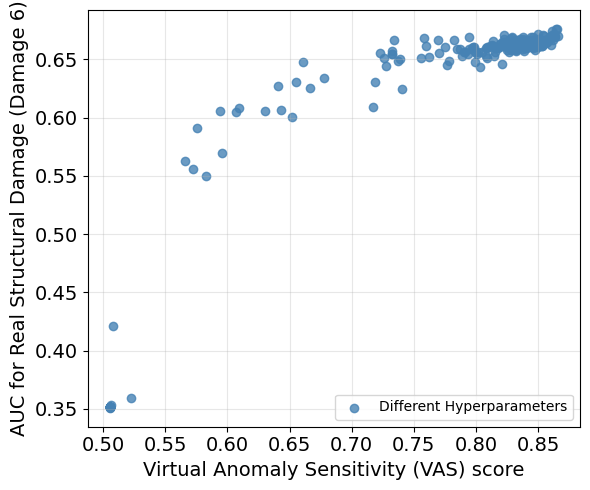

In [41]:
import mlflow
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Load all runs from MLflow (adjust experiment_ids if needed)
df = mlflow.search_runs()

# 2. Extract relevant metrics from the DataFrame
vas = df["metrics.harmonic_mean_va"]
real_anomaly_auc = df["metrics.aucs_real_anomaly"]

# 3. Create a figure and axis
plt.figure(figsize=(6, 5))  # slightly taller than wide

# 4. Scatter plot of VAS vs. Real Anomaly AUC
plt.scatter(vas, real_anomaly_auc, color='steelblue', alpha=0.8, label="Different Hyperparameters")



# 8. Add legend and grid
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.xlabel("Virtual Anomaly Sensitivity (VAS) score",fontsize=14)
plt.ylabel("AUC for Real Structural Damage (Damage 6)",fontsize=14)
# increase x and y ticks font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# 9. Show the plot
plt.tight_layout()
plt.show()


In [81]:

best_model_path = "file:///home/owilab/Documents/YacineB/Code/hannover-pylon/mlruns/0/afb6566539f641e6b1bf89a9c60e1583/artifacts/autoencoder-epoch=142-val_loss=0.0001-v6.ckpt"
best_model = OneToOneTrainingModule.load_from_checkpoint(best_model_path)

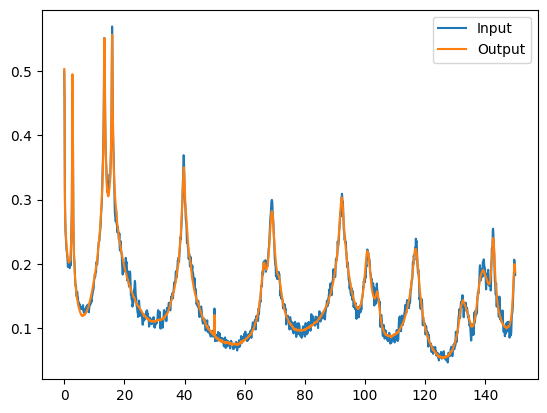

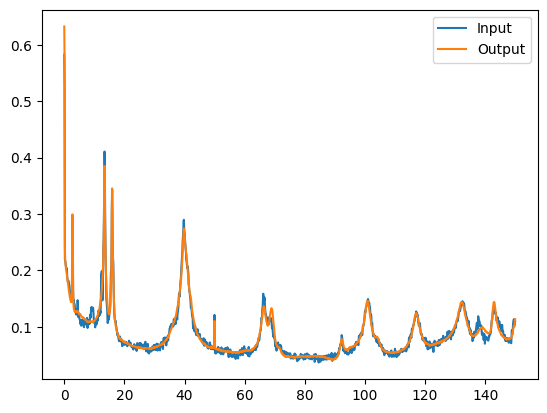

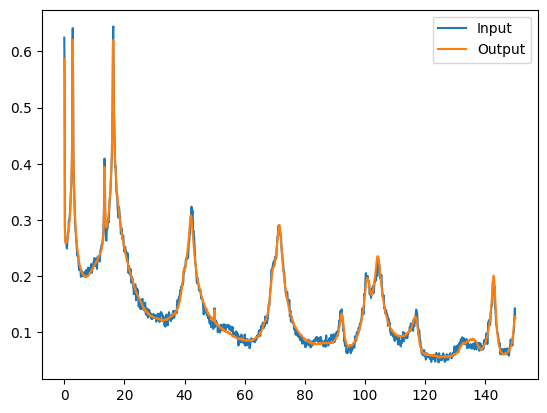

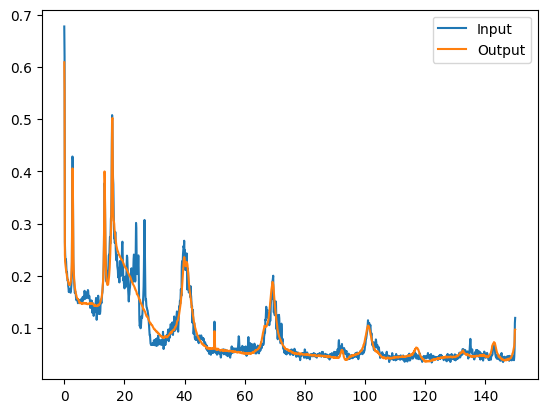

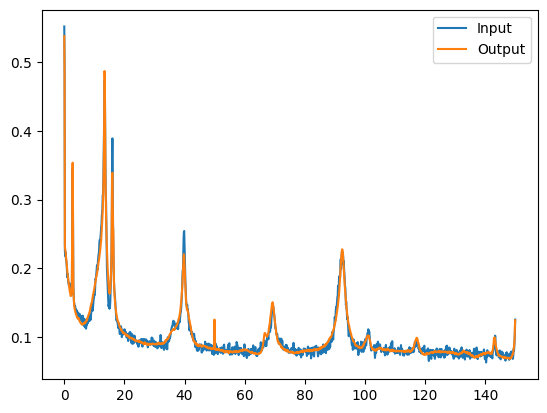

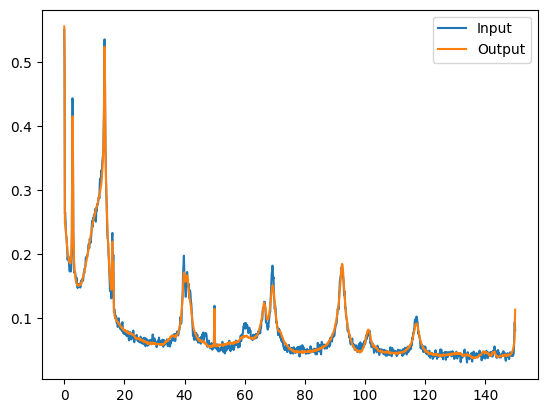

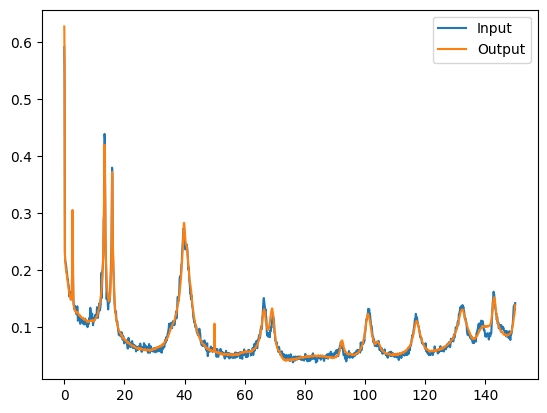

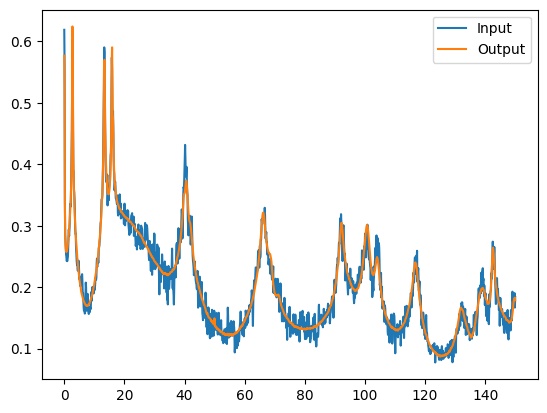

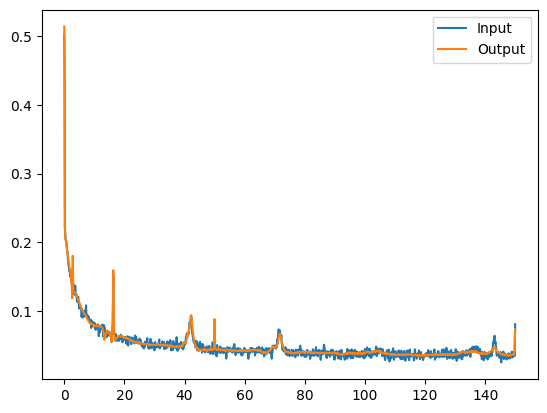

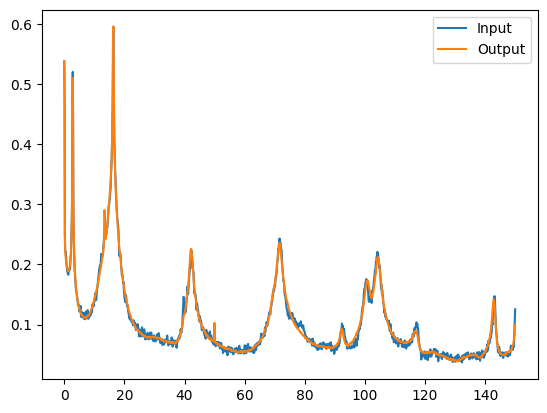

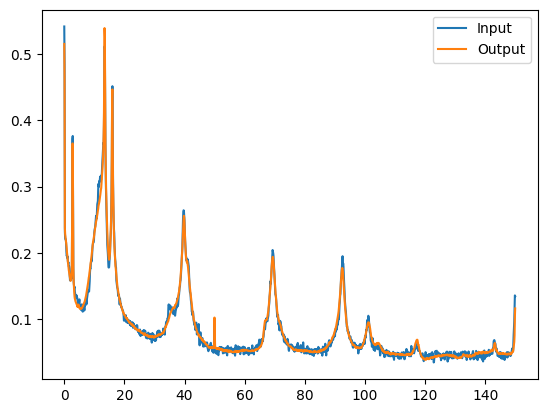

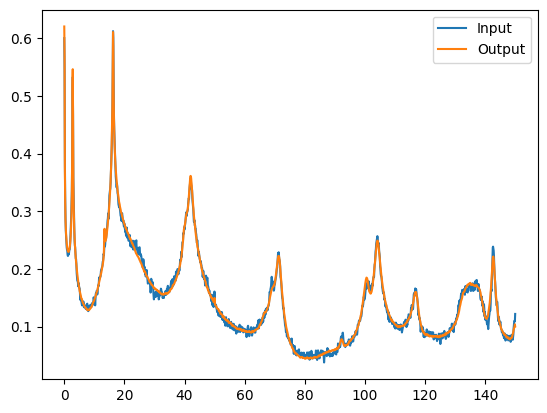

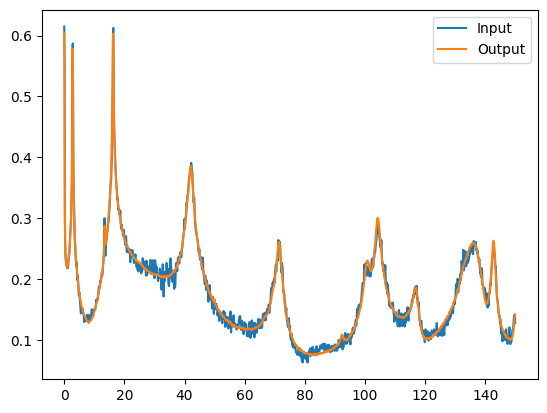

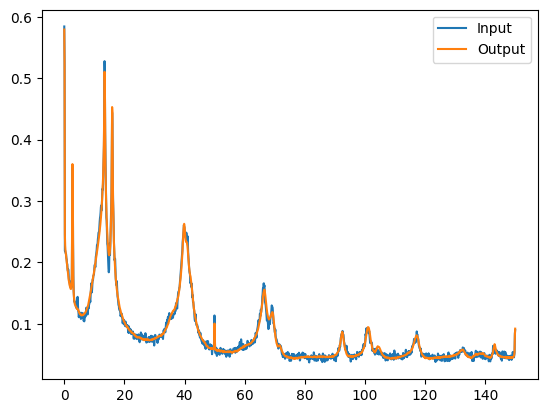

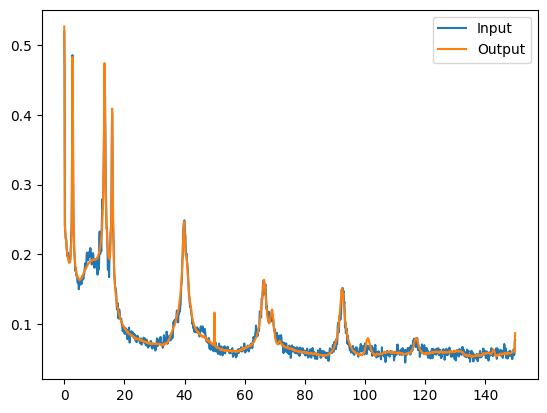

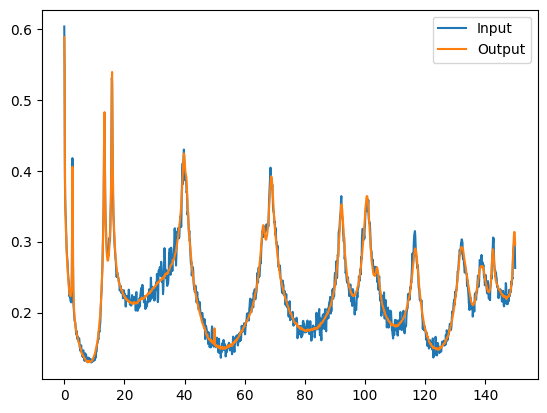

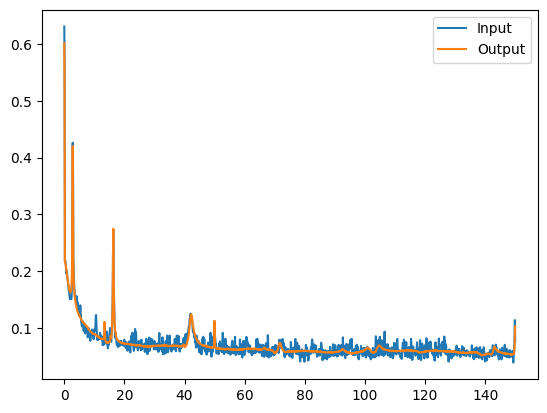

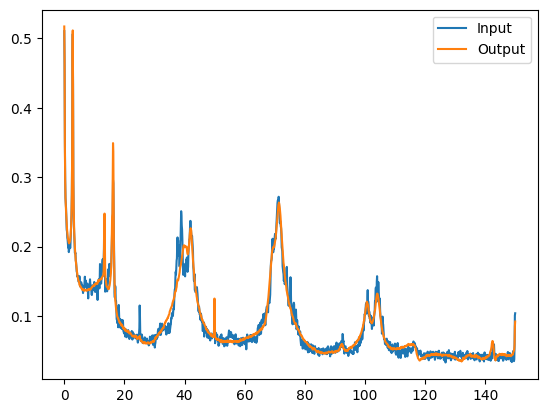

In [82]:
best_model.eval()
batch = next(iter(data_loader.val_dataloader()))
psd_out = best_model(batch)
psd_in = batch['psd']
psd_out = psd_out['reconstruction']                                        

for i in range(18):
    plt.figure()
    plt.plot(freq_axis[0:1490], psd_in[i].detach().numpy(), label='Input')
    plt.plot(freq_axis[0:1490], psd_out[i].cpu().detach().numpy(), label='Output')
    plt.legend()
    plt.show()
    plt.close()

In [83]:
import torch
import torch.nn as nn

class Detector(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.model.eval()  # Set the model to evaluation mode
        self.device = next(model.parameters()).device

    def mse(self, x_dict):
        # Ensure the input tensor is on the same device as the model.
        x = x_dict["psd"].to(self.device)
        with torch.no_grad():
            # The autoencoder returns a dict; we extract the reconstruction.
            out = self.model({"psd": x})
        x_hat = out["reconstruction"]
        
        # Compute the element-wise squared error.
        error = (x - x_hat) ** 2
        
        # Compute the 90th quantile along the feature dimension (dim=1).
        quantile_error = torch.quantile(error, q=0.9, dim=1)
        return quantile_error

    def forward(self, x_dict):
        return self.mse(x_dict)

In [84]:
best_model
detector = Detector(best_model)

# Get a batch from your data loader (which yields a dict with key "psd").
batch = next(iter(data_loader.val_dataloader()))

# Compute the damage metric for this batch.
damage_metric = detector(batch)  # returns a tensor of shape (B,)

print("Damage metric (90th percentile reconstruction error) per sample:")
print(damage_metric)

Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 731, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 729, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-r1m__g2a'


Damage metric (90th percentile reconstruction error) per sample:
tensor([1.8898e-04, 1.2691e-04, 1.5636e-04, 5.2091e-04, 1.1430e-04, 1.0148e-04,
        1.1804e-04, 6.6920e-04, 5.1945e-05, 9.6068e-05, 8.3985e-05, 1.1555e-04,
        1.9792e-04, 7.3321e-05, 9.6685e-05, 2.2089e-04, 1.9597e-04, 2.1971e-04,
        1.8572e-04, 8.3476e-05, 1.7105e-04, 1.0946e-04, 2.0863e-04, 9.2147e-05,
        5.9686e-05, 1.6714e-04, 1.1706e-04, 5.3985e-05, 1.7713e-04, 1.7273e-04,
        4.7741e-04, 1.8666e-04, 1.0361e-04, 1.3691e-04, 1.3687e-04, 6.6978e-05,
        1.0184e-04, 5.1191e-05, 4.7758e-05, 1.8971e-04, 1.8228e-04, 1.6316e-04,
        1.4945e-04, 5.0608e-05, 1.7296e-04, 1.4726e-04, 6.6926e-04, 9.3776e-05,
        1.6318e-04, 1.5416e-04, 5.6489e-05, 1.8510e-03, 2.1101e-04, 5.4937e-05,
        1.2106e-04, 1.2457e-04, 7.9354e-05, 8.3092e-05, 4.3725e-05, 1.9384e-04,
        1.6720e-04, 4.8468e-05, 2.1118e-04, 3.0838e-05, 6.9020e-05, 1.5445e-04,
        1.6949e-04, 4.7602e-05, 4.3007e-05, 1.2398e-04,

In [85]:
freq_axis = np.linspace(0, 825.5, 8197)
db_path = Path(settings.path.processed,'Welch(n_fft=16392, fs=1651, max_freq=825.5).db')
columns= ['psd','direction','level','date']
transform_func = [nn.Sequential(FromBuffer(),CutPSD(freq_axis=freq_axis,freq_range=(0,150)),NormLayer(min_val=-5.46,max_val=4.96))] + [nn.Identity()]*3
query_key = f'''
    SELECT id FROM data
    WHERE sensor = "accel"
    AND corrupted = 0
'''
data_loader = dm.PSDDataModule(db_path= db_path,table_name='data',
                               columns=columns,transform_func=transform_func,
                               query_key=query_key, batch_size=24000, return_dict=True, cached=False)
data_loader.setup()


In [86]:
import pandas as pd
import torch

# Initialize an empty list to store DataFrames.
df_list = []

# Loop over all batches from the data loader.
for batch in data_loader.all_dataloader():
    # Unpack the batch. (Assuming the order is: psds, dates, directions, levels)
    psds, dates, directions, levels = batch['psd'], batch['date'], batch['direction'], batch['level']
    print(dates[0])
    # Run the detector. The detector expects a dict with key "psd".
    mse_vals = detector(batch)
    
    # Convert the mse_vals tensor to a NumPy array.
    mse_vals_np = mse_vals.cpu().numpy() if mse_vals.is_cuda else mse_vals.numpy()
    
    # Ensure dates, directions, and levels are in NumPy array format.
    dates_np = dates.cpu().numpy() if isinstance(dates, torch.Tensor) else dates
    directions_np = directions.cpu().numpy() if isinstance(directions, torch.Tensor) else directions
    levels_np = levels.cpu().numpy() if isinstance(levels, torch.Tensor) else levels
    
    # Create a temporary DataFrame for the current batch.
    df_temp = pd.DataFrame({
        'date': dates_np,
        'mse': mse_vals_np,
        'direction': directions_np,
        'level': levels_np
    })
    
    # Append the temporary DataFrame to the list.
    df_list.append(df_temp)

# Concatenate all the DataFrames in the list into a single DataFrame.
df_res = pd.concat(df_list, axis=0, ignore_index=True)

# Now you can work with df_res as needed.
print(df_res.head())


2020-08-01 00:02:00
2020-08-10 06:57:00
2020-08-19 13:42:00
2020-08-28 20:37:00
2020-09-07 04:22:00
2020-09-16 10:52:00
2020-09-25 17:37:00
2020-10-04 23:42:00
2020-10-18 14:37:00
2020-10-27 22:16:00
2020-11-06 05:41:00
2020-11-15 17:45:00
2020-11-25 00:00:00
2020-12-04 06:15:00
2020-12-13 12:40:00
2020-12-22 18:55:00
2021-01-01 01:30:00
2021-01-10 07:55:00
2021-01-24 17:17:00
2021-02-02 23:52:00
2021-02-12 06:17:00
2021-02-21 13:03:00
2021-03-02 19:28:00
2021-03-12 01:43:00
2021-03-21 08:28:00
2021-03-30 17:11:00
2021-04-08 23:16:00
2021-04-18 05:31:00
2021-04-27 11:36:00
2021-05-06 18:22:00
2021-05-16 01:07:00
2021-05-25 07:22:00
2021-06-03 13:47:00
2021-06-12 21:12:00
2021-06-22 05:14:00
2021-07-01 13:12:00
2021-07-10 19:27:00
2021-07-20 01:42:00
2021-07-29 08:07:00
                  date       mse direction  level
0  2020-08-01 00:02:00  0.000107         x      1
1  2020-08-01 00:02:00  0.000126         y      1
2  2020-08-01 00:02:00  0.000093         x      2
3  2020-08-01 00:02:

In [87]:
import pandas as pd

# Convert the date column to datetime.
df_res['date'] = pd.to_datetime(df_res['date'])

# Define training period boundaries using your settings.
train_start = pd.to_datetime(settings.state.healthy_train.start)
train_end   = pd.to_datetime(settings.state.healthy_train.end)

def normalize_sensor(group):
    """
    For a given sensor group, normalize the 'mse' column using the training period's min and max.
    """
    # Create a mask for rows within the training period.
    train_mask = (group['date'] >= train_start) & (group['date'] <= train_end)
    
    if train_mask.any():
        train_min = group.loc[train_mask, 'mse'].quantile(0.01)
        train_max = group.loc[train_mask, 'mse'].quantile(0.98)
        if train_max - train_min != 0:
            group['mse'] = (group['mse'] - train_min) / (train_max - train_min)
        else:
            group['mse'] = 0.0  # Avoid division by zero.
    else:
        # If no training data is available for this sensor group, you can decide to leave it as is or set to NaN.
        group['mse'] = group['mse']  # or: group['mse'] = np.nan
    return group

# Group the DataFrame by sensor. Here, we assume that 'direction' indicates the sensor.
df_normalized = df_res.groupby('direction', group_keys=False).apply(normalize_sensor)

# Display the first few rows of the normalized DataFrame.
print(df_normalized.head())


                 date       mse direction  level
0 2020-08-01 00:02:00  0.112544         x      1
1 2020-08-01 00:02:00  0.094776         y      1
2 2020-08-01 00:02:00  0.088055         x      2
3 2020-08-01 00:02:00  0.100435         y      2
4 2020-08-01 00:02:00  0.101193         x      3


/tmp/ipykernel_4042211/221262152.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_normalized = df_res.groupby('direction', group_keys=False).apply(normalize_sensor)


In [ ]:
df_normalized['mse'].quantile(0.9)

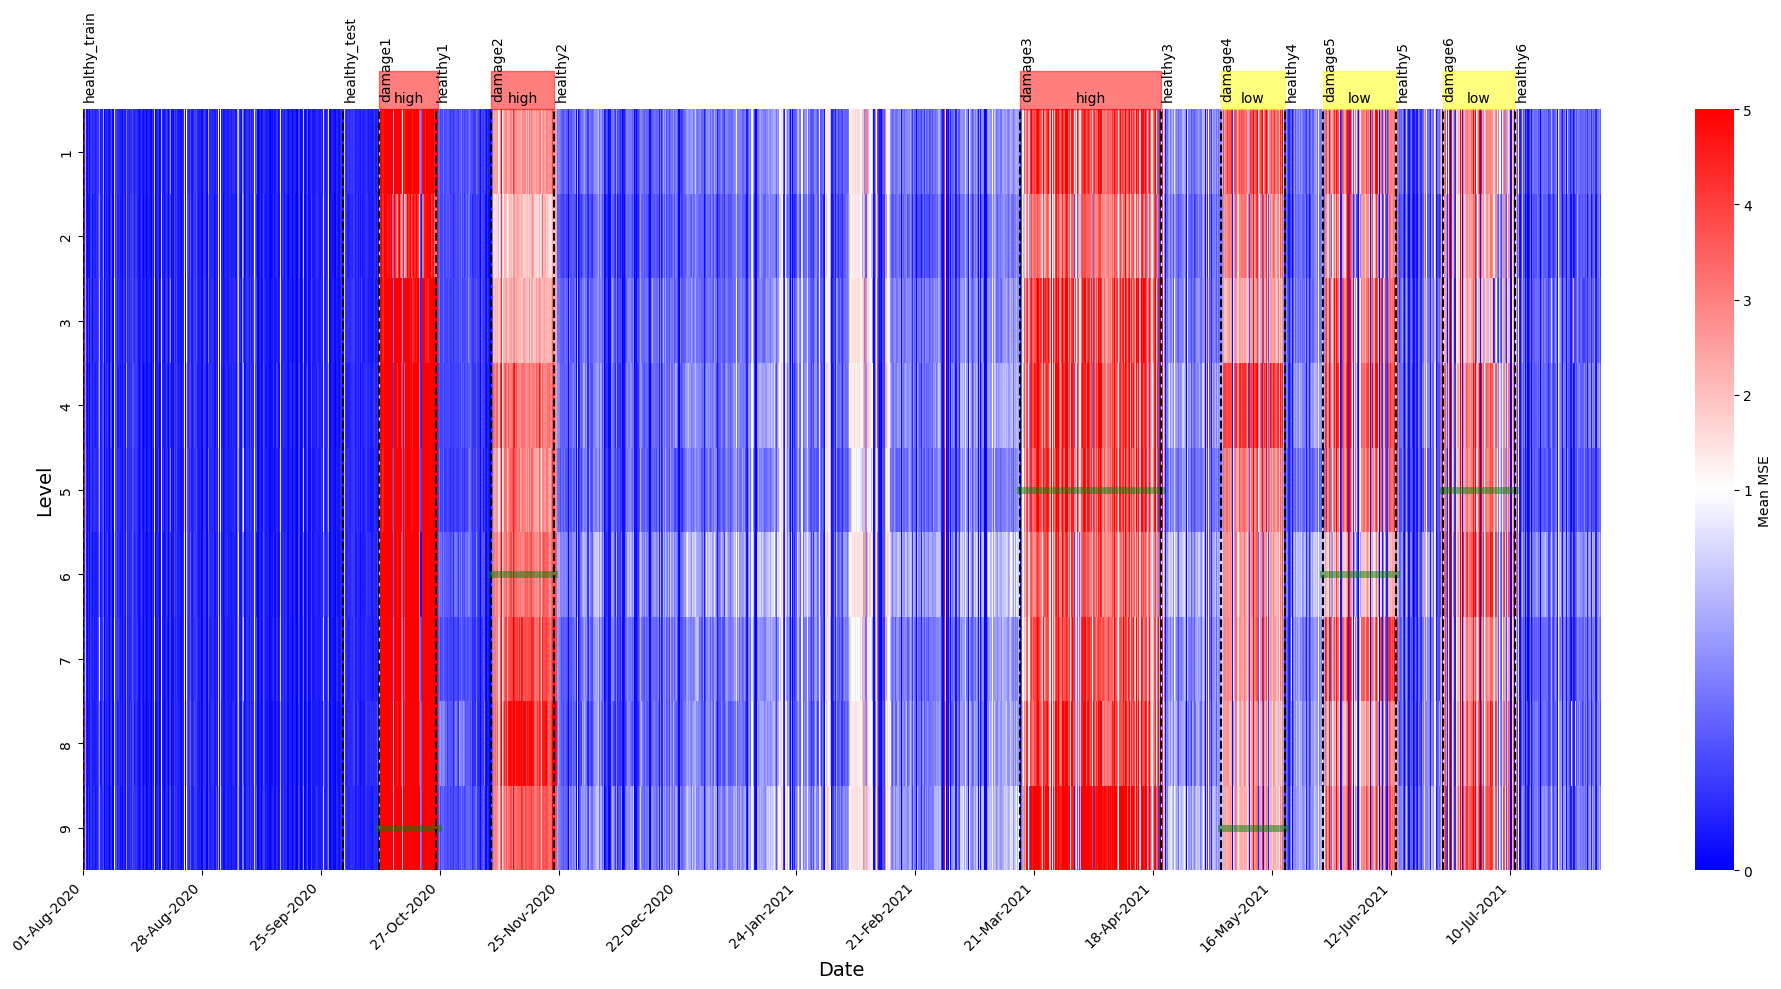

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors


# Ensure the date column is in datetime format.
df_normalized['date'] = pd.to_datetime(df_normalized['date'])

# Optionally, select a single sensor direction for the control chart.
# For instance, if you want to focus on the "y" direction:
df_control = df_normalized[df_normalized['direction'] == 'y']

# =============================================================================
# 2. Pivot the DataFrame for a Heatmap
# =============================================================================
# Create a pivot table with sensor level as the index, date as columns, and mean mse as values.
df_pivot = df_control.pivot_table(index='level', columns='date', values='mse', aggfunc='mean')
#df_pivot = df_pivot.rolling('1h').mean().T
# Ensure the pivot table's columns are datetime objects.
df_pivot.columns = pd.to_datetime(df_pivot.columns)

# =============================================================================
# 3. Create a Custom Date Formatter for the x-axis
# =============================================================================
def create_date_formatter(column_dates):
    """Return a custom formatter function for datetime labels."""
    def custom_date_format(x, pos=None):
        try:
            idx = int(x)
            if 0 <= idx < len(column_dates):
                return column_dates[idx].strftime('%d-%b-%Y')
            return ''
        except Exception:
            return ''
    return FuncFormatter(custom_date_format)

# =============================================================================
# 4. Define Custom Colormap and Norm
# =============================================================================
# Create a custom colormap from blue to white to red.
custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_bwr', ['blue', 'white', 'red'])
# Use TwoSlopeNorm to center the colormap at 1, with vmin=0 and vmax=2.
norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=1, vmax=5)

# =============================================================================
# 5. Plot the Control Chart (Heatmap)
# =============================================================================
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

sns.heatmap(
    df_pivot,
    cmap=custom_cmap,                # Use the custom colormap.
    norm=norm,                       # Apply the normalization so that white is at 1.
    cbar_kws={'label': 'Mean MSE'},   # Label for the color bar.
    ax=ax
)

ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Level', fontsize=14)

# Create a list of dates from the pivot table columns.
dates_list = list(df_pivot.columns)
ax.xaxis.set_major_formatter(create_date_formatter(dates_list))
ax.xaxis.set_major_locator(MaxNLocator(nbins=15))  # Limit the number of x-axis ticks

# Rotate x-axis labels for better readability.
plt.xticks(rotation=45, ha='right')

# =============================================================================
# 6. (Optional) Annotate Events on the Chart
# =============================================================================
# If you have events defined in your settings, you can annotate the plot.
# For example, if events are stored as a dictionary in settings.state:
# events = {
#     "Event1": {"start": "2020-01-10", "end": "2020-01-12", "closest_sensor": 3, "severity": "high"},
#     "Event2": {"start": "2020-02-05", "end": "2020-02-07", "closest_sensor": 2, "severity": "low"}
# }
events = settings.state.to_dict()
for event_i, event_info in events.items():
    start = pd.to_datetime(event_info['start'])
    end = pd.to_datetime(event_info['end'])
    # Find approximate x-axis indices corresponding to start and end dates.
    idx_start = np.searchsorted(df_pivot.columns, start)
    idx_end = np.searchsorted(df_pivot.columns, end)
    
    # Draw a vertical line at the event start.
    ax.axvline(idx_start, color='black', linestyle='--', label=f'{event_i} start')
    ax.text(idx_start, -0.1, f'{event_i}', rotation=90, va='bottom', ha='left')
    
    # Draw a horizontal line at the sensor level closest to the event (if provided).
    level = event_info.get('closest_sensor', None)
    if level is not None:
        ax.axhline(level - 0.5, xmin=idx_start/len(df_pivot.columns), xmax=idx_end/len(df_pivot.columns),
                   color='green', linestyle='-', lw=5, alpha=0.5)
    
    # Draw a rectangle above the plot indicating severity.
    severity = event_info.get('severity', None)
    if severity is not None:
        color = 'red' if severity == 'high' else 'yellow'
        box_height = 0.05  # Height of the severity box.
        ax.add_patch(Rectangle(
            (idx_start, 1),       # Position above the plot.
            width=idx_end - idx_start,
            height=box_height,
            color=color,
            alpha=0.5,
            transform=ax.get_xaxis_transform(),
            clip_on=False
        ))
        ax.text((idx_start + idx_end) / 2, -0.1 + box_height, severity,
                ha='center', va='bottom', color='black')

# =============================================================================
# 7. Finalize and Show the Plot
# =============================================================================
plt.tight_layout()
plt.show()


In [90]:
df_normalized['sensor_name'] = df_normalized['direction'] + df_normalized['level'].astype(str)

In [91]:
import pandas as pd
import numpy as np
from sklearn.covariance import OAS

df_agg= df_normalized[df_normalized['direction']=="y"].pivot(index='date', columns='sensor_name', values='mse') 
df_agg.index = pd.to_datetime(df_agg.index)
train_start = pd.to_datetime(settings.state.healthy_train.start)
train_end = pd.to_datetime(settings.state.healthy_train.end)
train_mask = (df_agg.index >= train_start) & (df_agg.index <= train_end)
df_train = df_agg.loc[train_mask]
oas = OAS(store_precision=True, assume_centered=False)
oas.fit(df_train)
df_agg['mahal'] = np.sqrt(oas.mahalanobis(df_agg))

# --- 6. (Optional) Inspect the Results ---


In [92]:
import pandas as pd 
import sqlite3
db_path = Path(settings.path.processed,'Welch(n_fft=16392, fs=1651, max_freq=825.5).db')
conn = sqlite3.connect(db_path)
# Read the 'meteo_data' table into a DataFrame
data_meteo = pd.read_sql('SELECT * FROM meteo_data', conn)
df_plot_meteo = data_meteo.pivot_table(index='date', columns='channel_name', values='value')
df_plot_meteo.index = pd.to_datetime(df_plot_meteo.index)
# Close the database connection
conn.close()

In [93]:
negative_mask = df_plot_meteo['airTemperatureAt2m'] < 0

start_indices = df_plot_meteo.index[negative_mask & ~negative_mask.shift(fill_value=False)]
end_indices = df_plot_meteo.index[~negative_mask & negative_mask.shift(fill_value=False)]

# Ensure lengths match (handle open-ended cases)
if len(end_indices) < len(start_indices):
    end_indices = end_indices.append(pd.Index([df_plot_meteo.index[-1]]))

# Create a DataFrame with stardf_plot_meteot and end times of subzero temperature regions
date_subzero_temperature = pd.DataFrame({'start_time': start_indices, 'end_time': end_indices})


In [94]:
sensor_cols = df_agg.filter(regex=r'^y\d+$').columns
df_agg['mean_mse'] = df_agg[sensor_cols].mean(axis=1)



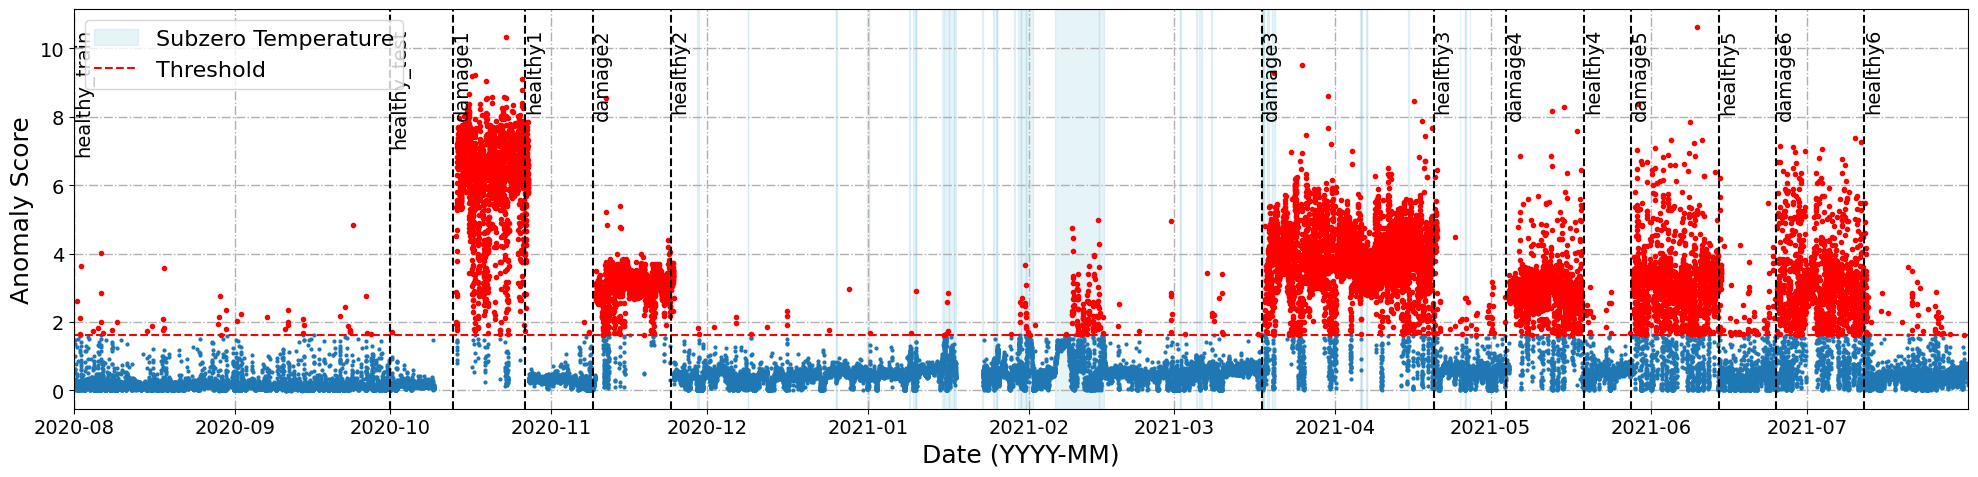

In [95]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ---------------------------
# Update Publication Quality Settings with Increased Fonts
# ---------------------------
plt.rcParams.update({
    'font.size': 14,         # Base font size
    'axes.labelsize': 18,    # X and Y label font size
    'axes.titlesize': 20,    # Axes title font size
    'legend.fontsize': 16,   # Legend font size
    'xtick.labelsize': 14,   # X-tick label size
    'ytick.labelsize': 14,   # Y-tick label size
    'lines.linewidth': 1.5,
    'grid.linestyle': '-.',
    'grid.linewidth': 1,
})

# Define the column of interest (e.g., mean_mse).
col_of_interest = 'mean_mse'

# ---------------------------
# 1. Create Figure and Plot Main Control Chart
# ---------------------------
fig, ax = plt.subplots(figsize=(20, 5))

# Plot anomaly scores as individual points.
ax.plot(
    df_agg.index, 
    df_agg[col_of_interest],
    'o', 
    markersize=2, 
    color='tab:blue', 
)

# Compute threshold (99.5th percentile over the training period).
train_start = pd.to_datetime(settings.state.healthy_train.start)
train_end = pd.to_datetime(settings.state.healthy_train.end)
df_train = df_agg.loc[train_start:train_end]
threshold = df_train[col_of_interest].quantile(0.995)

# Plot the threshold as a horizontal dashed red line.
ax.axhline(threshold, color='red', linestyle='--', label='Threshold')

# Highlight points exceeding the threshold.
exceed_mask = df_agg[col_of_interest] > threshold
ax.plot(
    df_agg.index[exceed_mask],
    df_agg.loc[exceed_mask, col_of_interest],
    'o', 
    markersize=3, 
    color='red',
)

# ---------------------------
# 2. Shade Subzero Temperature Regions
# ---------------------------
# Assume 'date_subzero_temperature' is a DataFrame with 'start_time' and 'end_time' columns.
for _, row in date_subzero_temperature.iterrows():
    ax.axvspan(
        row['start_time'], 
        row['end_time'], 
        color='lightblue', 
        alpha=0.3, 
        zorder=0
    )

# Create a patch for the legend.
subzero_patch = mpatches.Patch(color='lightblue', alpha=0.3, label='Subzero Temperature')

# ---------------------------
# 3. Add Legend and Annotate Events
# ---------------------------
# Combine existing legend handles with the subzero patch.
handles, labels = ax.get_legend_handles_labels()
handles.insert(0, subzero_patch)
labels.insert(0, 'Subzero Temperature')
ax.legend(handles, labels, loc='upper left', frameon=True)

# Annotate events from settings, if any.
for event_i, event_info in settings.state.to_dict().items():
    start = pd.to_datetime(event_info['start'])
    # Draw a vertical dashed line at the event start.
    ax.axvline(start, color='black', linestyle='--', label=f'{event_i} start')
    # Optionally, add text annotation near the top of the plot.
    ax.text(
        start, 
        ax.get_ylim()[1] * 0.95, 
        f'{event_i}', 
        rotation=90, 
        va='top', 
        ha='left'
    )

# ---------------------------
# 4. Final Touches
# ---------------------------
ax.set_xmargin(0)
ax.set_xlabel('Date (YYYY-MM)', fontsize=18)  # Increased label font size
ax.set_ylabel('Anomaly Score', fontsize=18)    # Increased label font size
ax.grid(True)

plt.tight_layout()

# Save the figure at high resolution (300 dpi) for journal publication.
plt.savefig("journal_plot.png", dpi=300)
plt.show()


In [96]:
df_plot_meteo.index = df_plot_meteo.index + pd.Timedelta(minutes=10)   
df_merge_temp = pd.merge_asof(df_agg,df_plot_meteo, 
                            left_index=True, right_index=True, direction='nearest')


In [97]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Example: Focus on level=1 data or a specific label. Adjust as needed.
# (If you already have df_res_level_meteo, skip re-assigning it.)
df_plot = df_merge_temp.copy()

# Drop rows missing MSE or Temperature.
df_plot = df_plot.dropna(subset=['mean_mse', 'airTemperatureAt2m'])


In [98]:
from hannover_pylon.utils.evaluation import label_dataframe_event 
df_plot['label']=label_dataframe_event(df_plot.index,events=settings.state.to_dict())
df_plot['label'].unique()

array(['healthy_train', 'healthy_test', 'damage1', 'healthy1', 'damage2',
       'healthy2', 'damage3', 'healthy3', 'damage4', 'healthy4',
       'damage5', 'healthy5', 'damage6', 'healthy6'], dtype=object)

/tmp/ipykernel_4042211/1878487454.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_healthy_2.groupby('temp_bin')


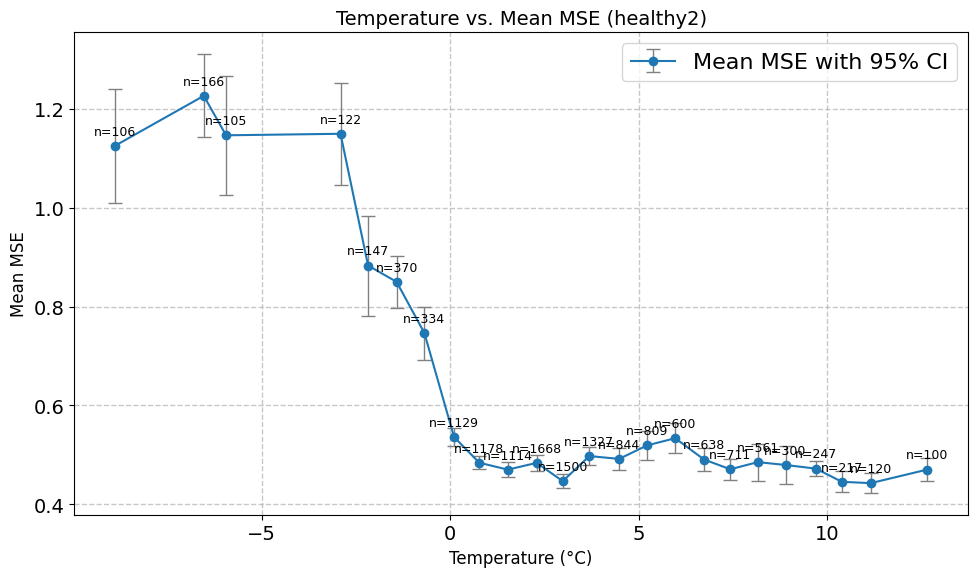

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import t, pearsonr

# Assume df_plot is your merged DataFrame that contains:
# - 'airTemperatureAt2m': temperature readings,
# - 'mean_mse': the 2-hour rolling median of MSE (or your chosen aggregated anomaly score),
# - 'label': event/health label.

# Filter to the desired label (for example, "healthy2")
df_healthy_2 = df_plot[df_plot['label'] == 'healthy2'].copy()

# Create bins for temperature.
# Here we use 50 bins; adjust this number as needed.
df_healthy_2['temp_bin'] = pd.cut(df_healthy_2['airTemperatureAt2m'], bins=50)

# Group by these temperature bins.
grouped = df_healthy_2.groupby('temp_bin')

# Compute aggregated statistics per bin.
mean_temp = grouped['airTemperatureAt2m'].mean()        # Mean temperature in each bin
mean_mse = grouped['mean_mse'].mean()                     # Mean MSE in each bin
std_mse = grouped['mean_mse'].std()                       # Standard deviation of MSE
count_mse = grouped['mean_mse'].count()                   # Number of observations per bin

# Compute the standard error of the mean.
sem_mse = std_mse / np.sqrt(count_mse)

# Compute the t-critical value for a 95% confidence interval for each bin.
confidence_level = 0.95
# Degrees of freedom per bin
dof = count_mse - 1
dof[dof < 1] = np.nan  # Avoid errors for bins with too few samples
t_crit = t.ppf((1 + confidence_level) / 2, dof)

# Compute the margin of error.
margin_of_error = t_crit * sem_mse

# Filter out bins with fewer than 100 samples.
valid_bins = count_mse >= 100
mean_temp_valid = mean_temp[valid_bins]
mean_mse_valid = mean_mse[valid_bins]
margin_error_valid = margin_of_error[valid_bins]
count_valid = count_mse[valid_bins]

# Plot the binned data with error bars.
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(
    mean_temp_valid, 
    mean_mse_valid, 
    yerr=margin_error_valid,
    fmt='o-', capsize=5, ecolor='gray', elinewidth=1, markeredgewidth=1,
    label='Mean MSE with 95% CI'
)

ax.set_xlabel('Temperature (°C)', fontsize=12)
ax.set_ylabel('Mean MSE', fontsize=12)
ax.set_title('Temperature vs. Mean MSE (healthy2)', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.7)

# Annotate each point with the sample size.
for x, y, n in zip(mean_temp_valid, mean_mse_valid, count_valid):
    ax.annotate(f'n={int(n)}', xy=(x, y), xytext=(0, 8),
                textcoords='offset points', ha='center', fontsize=9)



plt.legend()
plt.tight_layout()
plt.show()


In [102]:
from evaluation_lumo.evaluation import compute_tr_by_events, compute_median_variation, prepare_dataframe
from hannover_pylon.modelling.finalexp.plot import display_damage_vs_healthy_table 
scores = compute_tr_by_events(df_agg.index,df_agg['mean_mse'])[0]
display_damage_vs_healthy_table(scores)
scores = compute_median_variation(df_agg.index,df_agg['mean_mse'])    
display_damage_vs_healthy_table(scores)


                              Damage vs. Healthy                              
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Damage Event         ┃ Damage Score ┃ Healthy Event        ┃ Healthy Score ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ damage1              │       0.9665 │ healthy1             │        0.0033 │
│ damage2              │       0.9479 │ healthy2             │        0.0448 │
│ damage3              │       0.8986 │ healthy3             │        0.0289 │
│ damage4              │       0.8404 │ healthy4             │        0.0185 │
│ damage5              │       0.7179 │ healthy5             │        0.0534 │
│ damage6              │       0.7045 │ healthy6             │        0.0239 │
│                      │              │ healthy_test         │        0.0017 │
│                      │              │ healthy_train        │        0.0100 │
└──────────────────────┴──────────────┴──────────────────────┴───────────────┘

             Others              
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Event                ┃  Score ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ no_event             │ 0.5237 │
└──────────────────────┴────────┘

                              Damage vs. Healthy                              
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Damage Event         ┃ Damage Score ┃ Healthy Event        ┃ Healthy Score ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ damage1              │      36.9282 │ healthy1             │        1.7394 │
│ damage2              │      18.0236 │ healthy2             │        2.8464 │
│ damage3              │      21.7232 │ healthy3             │        3.3784 │
│ damage4              │      16.2237 │ healthy4             │        3.0893 │
│ damage5              │      15.7857 │ healthy5             │        2.3999 │
│ damage6              │      15.1760 │ healthy6             │        2.3488 │
│                      │              │ healthy_test         │        0.8694 │
│                      │              │ healthy_train        │        0.7728 │
└──────────────────────┴──────────────┴──────────────────────┴───────────────┘

             Others              
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Event                ┃  Score ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ no_event             │ 9.3597 │
└──────────────────────┴────────┘